## Import Packages

In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2## Import Packages
%matplotlib inline

## Camera Calibration

In [2]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
%matplotlib qt

nx = 9
ny = 6
# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((ny*nx,3), np.float32)
objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for idx, fname in enumerate(images):
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (nx,ny), None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        cv2.drawChessboardCorners(img, (nx,ny), corners, ret)
        #write_name = 'corners_found'+str(idx)+'.jpg'
        #cv2.imwrite(write_name, img)
        cv2.imshow('img', img)
        cv2.waitKey(500)

cv2.destroyAllWindows()

In [2]:
import pickle

img = cv2.imread('test_images/test0_0.jpg')
img_size = (img.shape[1], img.shape[0])

def CameraCalibration(objpoints, imgpoints, img_size):

    # Do camera calibration given object points and image points
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)
    
    return ret, mtx, dist, rvecs, tvecs

    # Save the camera calibration result for later use (we won't worry about rvecs / tvecs)

ret, mtx, dist, rvecs, tvecs = CameraCalibration(objpoints, imgpoints, img_size)    
    
dist_pickle = {}
dist_pickle = {}
dist_pickle["mtx"] = mtx
dist_pickle["dist"] = dist
pickle.dump( dist_pickle, open( "camera_cal/camera_cal.p", "wb" ) )

NameError: name 'objpoints' is not defined

## Distortion Correction

In [3]:
def DistortionCorrection(img, mtx, dist):
    dst = cv2.undistort(img, mtx, dist, None, mtx)
    return dst

## Color and Gradient Threshold

In [4]:
import numpy as np
import cv2
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
%matplotlib inline

image = mpimg.imread('signs_vehicles_xygrad.png')


def abs_sobel_thresh(image, channel = 'gray', orient='x', sobel_kernel=3, thresh=(0, 255)):
    # Calculate directional gradient
    # Apply threshold
    if channel == 'gray':
        img = grayscale(image)
    elif channel == 'sat':
        img = s_channel(image)
        
    if orient == 'x':
        sobelx = cv2.Sobel(img, cv2.CV_64F, 1, 0)
        abs_sobel = np.absolute(sobelx)
    elif orient == 'y':
        sobely = cv2.Sobel(img, cv2.CV_64F, 0, 1)
        abs_sobel = np.absolute(sobely)
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    grad_binary = np.zeros_like(scaled_sobel)
    grad_binary[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    return grad_binary

def mag_thresh_binary(image, channel = 'gray', sobel_kernel=3, mag_thresh=(0, 255)):
    # Calculate gradient magnitude
    # Apply threshold
    if channel == 'gray':
        img = grayscale(image)
    elif channel == 'sat':
        img = s_channel(image)
        
    sobelx = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(img, cv2.CV_64F, 0 , 1, ksize=sobel_kernel)
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    scale_factor = np.max(gradmag)/255
    gradmag = (gradmag/scale_factor).astype(np.uint8)
    mag_binary = np.zeros_like(gradmag)
    mag_binary[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1
    return mag_binary

def dir_threshold(image, channel = 'gray', sobel_kernel=3, thresh=(0, np.pi/2)):
    # Calculate gradient direction
    # Apply threshold
    if channel == 'gray':
        img = grayscale(image)
        
    elif channel == 'sat':
        img = s_channel(image)
        
    sobelx = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize = sobel_kernel)
    sobely = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize = sobel_kernel)
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)
    dirgrad = np.arctan2(abs_sobely, abs_sobelx)
    dir_binary = np.zeros_like(dirgrad)
    dir_binary[(dirgrad >= thresh[0]) & (dirgrad <= thresh[1])] = 1
    return dir_binary

def s_channel(image):
    img = np.copy(image)
    hsv = cv2. cvtColor(image, cv2.COLOR_RGB2HLS).astype(np.float)
    l_channel = hsv[:,:,1]
    s_channel = hsv[:,:,2]
    
    return s_channel

def grayscale(image):
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    return gray
# Choose a Sobel kernel size
ksize = 3 # Choose a larger odd number to smooth gradient measurements

def combined_grad(image, sat, ksize, thresh, mag_thresh, dir_binary):
# Apply each of the thresholding functions
    gradx = abs_sobel_thresh(image, channel = 'sat', orient='x', sobel_kernel=ksize, thresh=(50, 175))
    grady = abs_sobel_thresh(image, channel = 'sat', orient='y', sobel_kernel=ksize, thresh=(50, 175))
    mag_binary = mag_thresh_binary(image, channel = 'sat', sobel_kernel=ksize, mag_thresh=(50,175))
    dir_binary = dir_threshold(image, channel = 'sat', sobel_kernel=ksize, thresh=(0.7, 1.3))

    gradx_gray = abs_sobel_thresh(image, channel = 'gray', orient='x', sobel_kernel=ksize, thresh=(50, 175))
    grady_gray = abs_sobel_thresh(image, channel = 'gray', orient='y', sobel_kernel=ksize, thresh=(50, 175))
    mag_binary_gray = mag_thresh_binary(image, channel = 'gray', sobel_kernel=ksize, mag_thresh=(50, 175))
    dir_binary_gray = dir_threshold(image, channel = 'gray', sobel_kernel=ksize, thresh=(0.7, 1.3))

    combined = np.zeros_like(dir_binary)
    combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1)) | ((gradx_gray == 1) & (grady_gray == 1)) | ((mag_binary_gray == 1) & (dir_binary_gray == 1))] = 1
    
    return combined




In [ ]:
f, ([ax1,ax2],[ax3,ax4],[ax5,ax6]) = plt.subplots(3, 2, figsize=(24, 23), gridspec_kw={'hspace':0.5})
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(combined, cmap='gray')
ax2.set_title('Combined', fontsize=50)
ax3.imshow(gradx, cmap='gray')
ax3.set_title('Sobel Gradient X', fontsize=50)
ax4.imshow(grady, cmap='gray')
ax4.set_title('Sobel Gradient Y', fontsize=50)
ax5.imshow(mag_binary, cmap='gray')
ax5.set_title('Magnitude of Gradient', fontsize=50)
ax6.imshow(dir_binary, cmap='gray')
ax6.set_title('Thresholded Grad. Dir.', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

SyntaxError: invalid syntax (<ipython-input-116-61d063b6746d>, line 3)

## Region of Interest Mask

In [5]:
def region_of_interest(image, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(image)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(image.shape) > 2:
        channel_count = image.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(image, mask)
    return masked_image, mask



## Hough Transform

In [6]:
def Hough_Trans(image, rho, theta, threshold, min_line_len, max_line_gap, center, line_image):
    
    image = np.uint8(255*image/np.max(image))
    lines = cv2.HoughLinesP(image, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    l_lines_x = []
    r_lines_x = []
    l_lines_y = []
    r_lines_y = []
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(line_image,(x1,y1),(x2,y2),(255,0,0),10)
            if (x1 < center) & (x2 < center):
                l_lines_x.append(x1)
                l_lines_y.append(y1)
                l_lines_x.append(x2)
                l_lines_y.append(y2)
            elif (x1 > center) & (x2 > center):
                r_lines_x.append(x1)
                r_lines_y.append(y1)
                r_lines_x.append(x2)
                r_lines_y.append(y2)
    if len(l_lines_x)>0:            
        left_lane_line = np.polyfit(l_lines_x,l_lines_y,1) #left_lane_line = [m,b]
    else: 
        left_lane_line = [0,0]
    
    if len(r_lines_x)>0:
        right_lane_line = np.polyfit(r_lines_x,r_lines_y,1) #rightt_lane_line = [m,b]
    else: 
        right_lane_line = [0,0]
    
    return left_lane_line, right_lane_line, line_image




In [7]:
def source(left_lane_line, right_lane_line, top_line_perspective, bot_line_perspective):
    
    #corner1 = [(top_line_perspective-left_lane_line[1])/left_lane_line[0], top_line_perspective]
    #corner2 = [(top_line_perspective-right_lane_line[1])/right_lane_line[0], top_line_perspective]
    #corner3 = [(bot_line_perspective-left_lane_line[1])/left_lane_line[0], bot_line_perspective]
    #corner4 = [(bot_line_perspective-right_lane_line[1])/right_lane_line[0], bot_line_perspective]
    
    src = np.float32([(190, 720), (548, 480), (740, 480), (1130, 720)])
    
    return src

In [12]:
color_edges = masked_image
combo = cv2.addWeighted(color_edges, 0.8, line_image, 1, 0)
plt.imshow(combo)
print(l_lines_x)
print(l_lines_y)
print(r_lines_x)
print(r_lines_y)
print(lines)

NameError: name 'masked_image' is not defined

## Perspective Transform

In [8]:
#img_size = (combined.shape[1], combined.shape[0])
#offset = 200
#dst = np.float32([[offset, offset],
#                  [img_size[0]-offset, offset],
#                  [img_size[0]-offset, img_size[1]],
#                  [offset, img_size[1]]])

def corners_unwarp(img, src, dst, mtx, dist, img_size, offset):
    
    # For destination points, I'm arbitrarily choosing some points to be
    # a nice fit for displaying our warped result 
    # again, not exact, but close enough for our purposes
    # Given src and dst points, calculate the perspective transform matrix
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    # Warp the image using OpenCV warpPerspective()
    warped = cv2.warpPerspective(img, M, img_size)

    # Return the resulting image and matrix
    return warped, M, Minv

#top_down, M, Minv = corners_unwarp(combined, src, dst, mtx, dist, img_size, offset)
#f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
#f.tight_layout()
#ax1.imshow(combined)
#ax1.set_title('Original Image', fontsize=50)
#ax2.imshow(top_down)
#ax2.set_title('Warped Image', fontsize=50)
#plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
#print (dst)
#print(src)
#top_down = top_down.astype(dtype='uint8')

## Histogram

In [9]:
import numpy as np
np.set_printoptions(threshold=np.nan)

def find_lines(top_down):
    # Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image
    histogram = np.sum(top_down[top_down.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((top_down, top_down, top_down))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint


    # Choose the number of sliding windows
    nwindows = 7
    # Set height of windows
    window_height = np.int(top_down.shape[0]/nwindows)
    
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = top_down.nonzero() # Return the indices of the elements that are non-zero.
    nonzeroy = np.array(nonzero[0]) #array of y-coordinates of non zero elements of top_down
    nonzerox = np.array(nonzero[1]) #corresponding array of x-coordinates of non zero elements of top_down
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        #Identify window boundaries in x and y (and right and left)
        win_y_low = top_down.shape[0] - (window+1)*window_height 
        win_y_high = top_down.shape[0] - window*window_height #closer to bottom of frame
        win_xleft_low = leftx_current - margin #left side of left box
        win_xleft_high = leftx_current + margin #right side of left box
        win_xright_low = rightx_current - margin #left side of right box
        win_xright_high = rightx_current + margin
        #Draw the windows on the visualization image
        cv2.rectangle(out_img, (win_xleft_low, win_y_low),(win_xleft_high, win_y_high),(0,255,0),5)
        cv2.rectangle(out_img, (win_xright_low, win_y_low),(win_xright_high, win_y_high),(0,255,0),5)
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds]
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    return  left_fit, right_fit, leftx, lefty, rightx, righty, out_img
    plt.imshow(out_img)
    #plt.plot(histogram)

## Print Line of Best Fit with Left and Right Lane Pixels

In [10]:
def linefit(top_down, left_fit, right_fit):
    ploty = np.linspace(0, top_down.shape[0]-1, top_down.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    return ploty, left_fitx, right_fitx


#out_img[lefty, leftx] = [255, 0, 0]
#out_img[righty, rightx] = [0, 0, 255]
#plt.plot(left_fitx, ploty, color='yellow')
#plt.plot(right_fitx, ploty, color='yellow')
#plt.xlim(0, 1280)
#plt.ylim(720, 0)
#plt.imshow(out_img)
#print(out_img.max())


## Skipping Sliding Windows Step and Searching in Region

In [11]:
# Assume you now have a new warped binary image 
# from the next frame of video (also called "binary_warped")
# It's now much easier to find line pixels!
def nextframe(top_down, left_fit, right_fit):
    nonzero = top_down.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 100 #
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    # Fit a second order polynomial to each
    left_fit_next = np.polyfit(lefty, leftx, 2)
    right_fit_next = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, top_down.shape[0]-1, top_down.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    return left_fit_next, right_fit_next, ploty, left_fitx, right_fitx

In [17]:
# Create an image to draw on and an image to show the selection window
out_img = np.dstack((top_down, top_down, top_down))*255
window_img = np.zeros_like(out_img)
# Color in left and right line pixels
out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

# Generate a polygon to illustrate the search window area
# And recast the x and y points into usable format for cv2.fillPoly()
left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
left_line_pts = np.hstack((left_line_window1, left_line_window2))
right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
right_line_pts = np.hstack((right_line_window1, right_line_window2))

# Draw the lane onto the warped blank image
cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
plt.imshow(result)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

NameError: name 'top_down' is not defined

## Measuring Curvature and Offset

### Curvature

In [12]:
def Curvature(ploty, left_fit, right_fit):    
    # Define y-value where we want radius of curvature
    # I'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)
    left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
    right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
    #print('The radius of curvature is around ',left_curverad, right_curverad)
    # Example values: 1926.74 1908.48

    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension

    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    # Now our radius of curvature is in meters
    radius = (left_curverad+right_curverad)/2 
    #print(left_curverad, 'm', right_curverad, 'm')
    # Example values: 632.1 m    626.2 m
    
    return radius 

### Offset

## Drawing

In [13]:
image = mpimg.imread('signs_vehicles_xygrad.png')
#image = image.astype(np.uint8)

def drawing(image, top_down, left_fitx, right_fitx, ploty, Minv):
# Create an image to draw the lines on
    warp_zero = np.zeros_like(top_down).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0])) 
    # Combine the result with the original image
    newwarp = newwarp.astype(dtype = np.uint8)
    result = cv2.addWeighted(image, 1, newwarp, 0.3, 0)
    
    return result

    fig, ax = plt.subplots(figsize=(24, 9))
    ax.imshow(result)

## Loop Through All Test Images and Save

In [14]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [15]:
import os
import numpy as np
np.set_printoptions(threshold=np.nan)
test_list = os.listdir("test_images/")

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)
uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)
uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)
uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)
uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)
uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)
uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)
uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


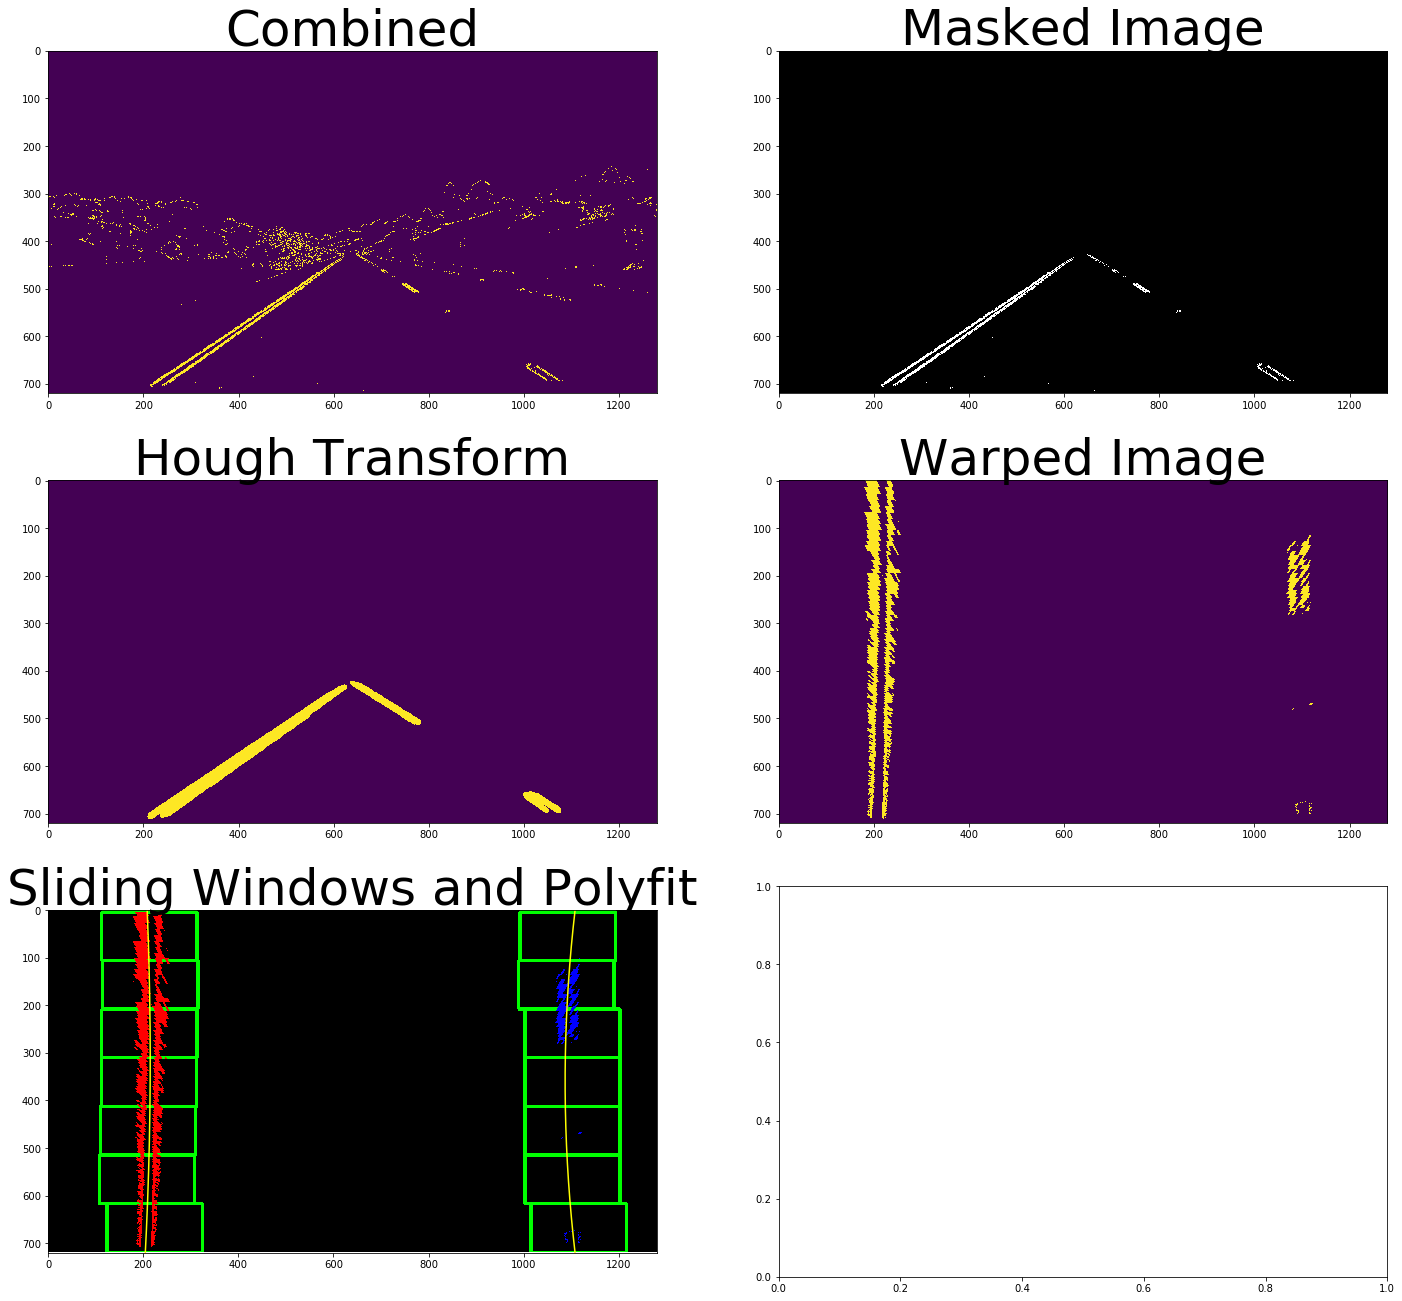

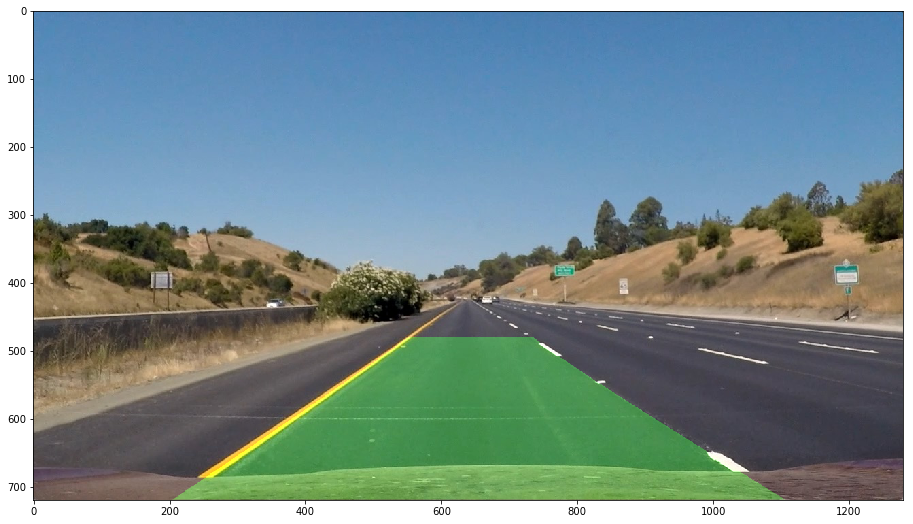

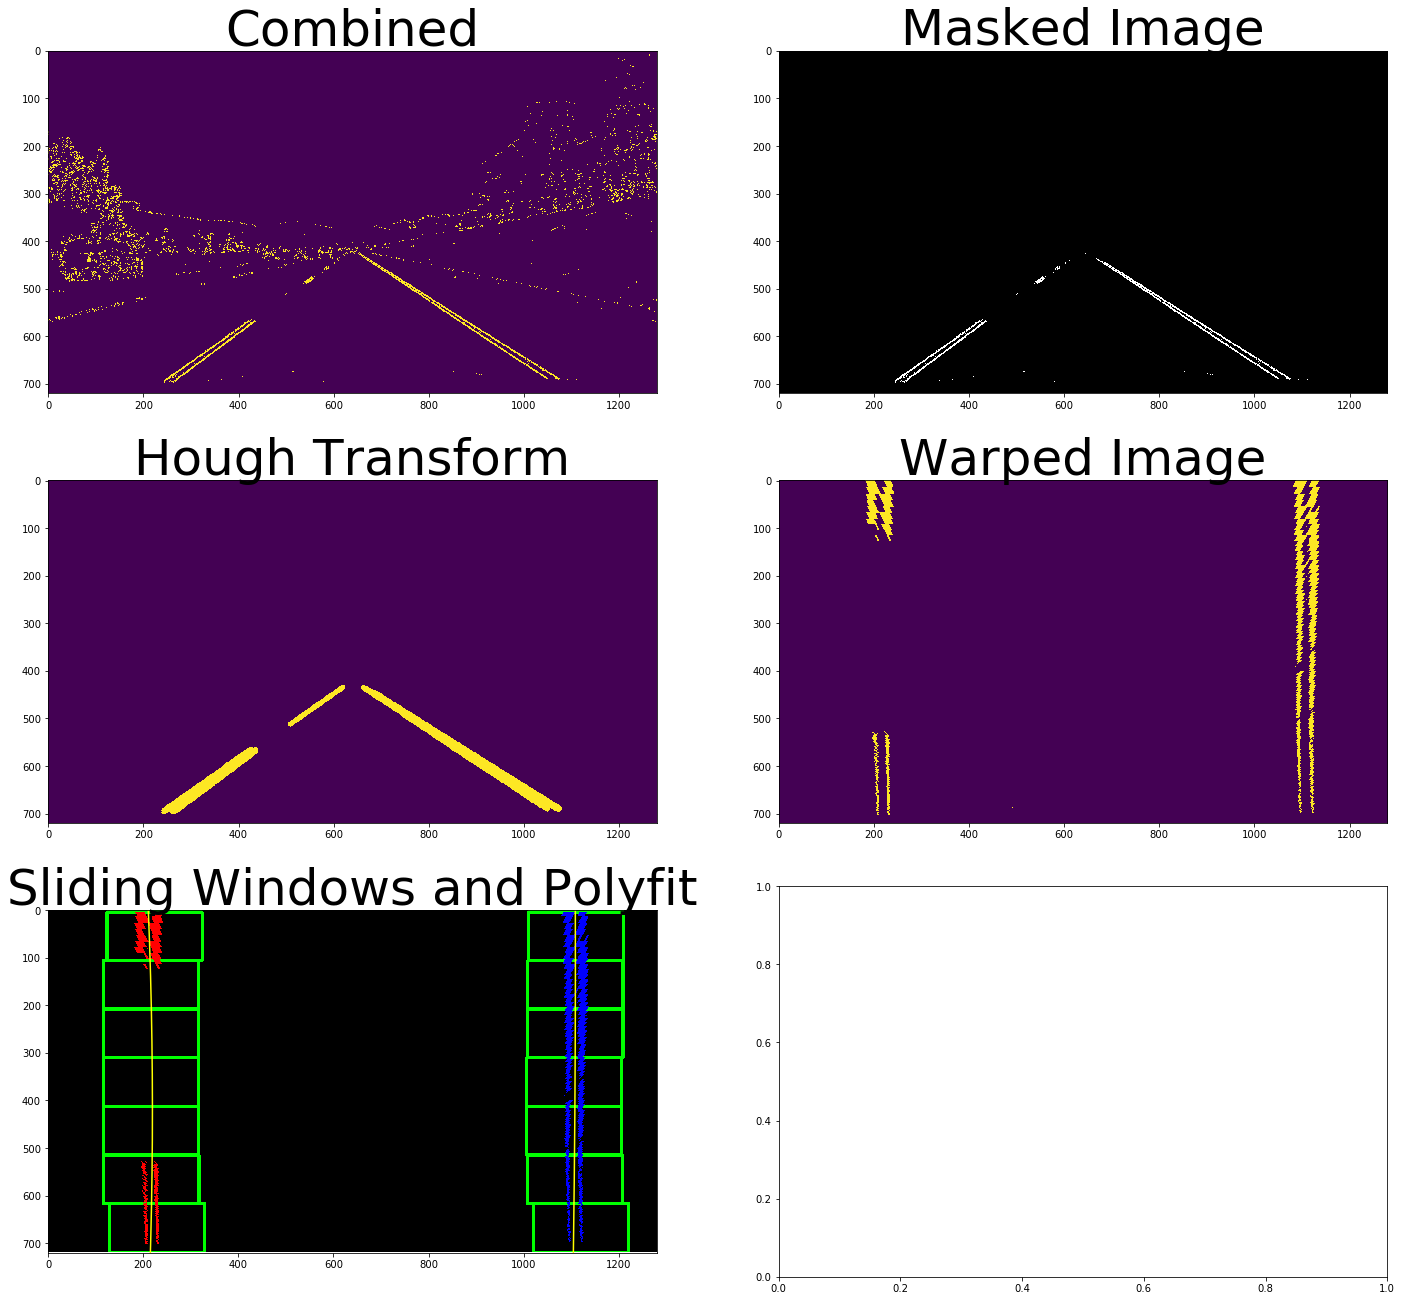

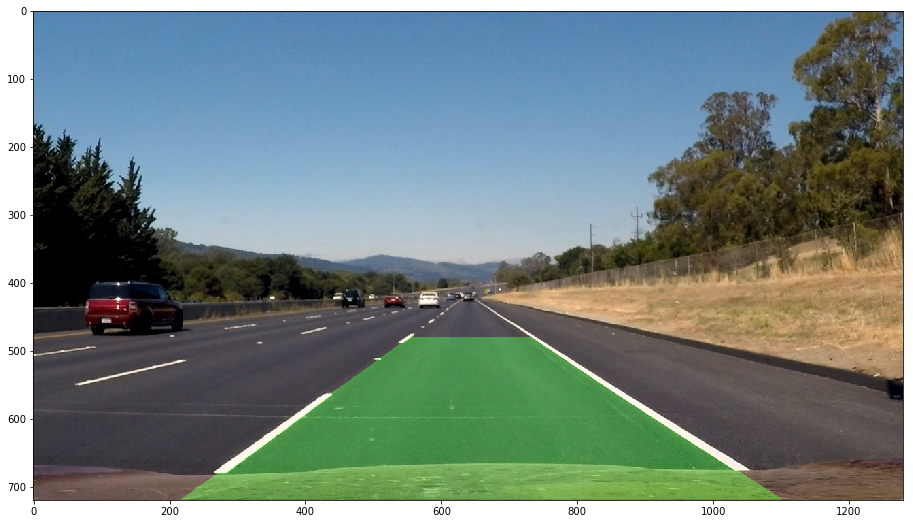

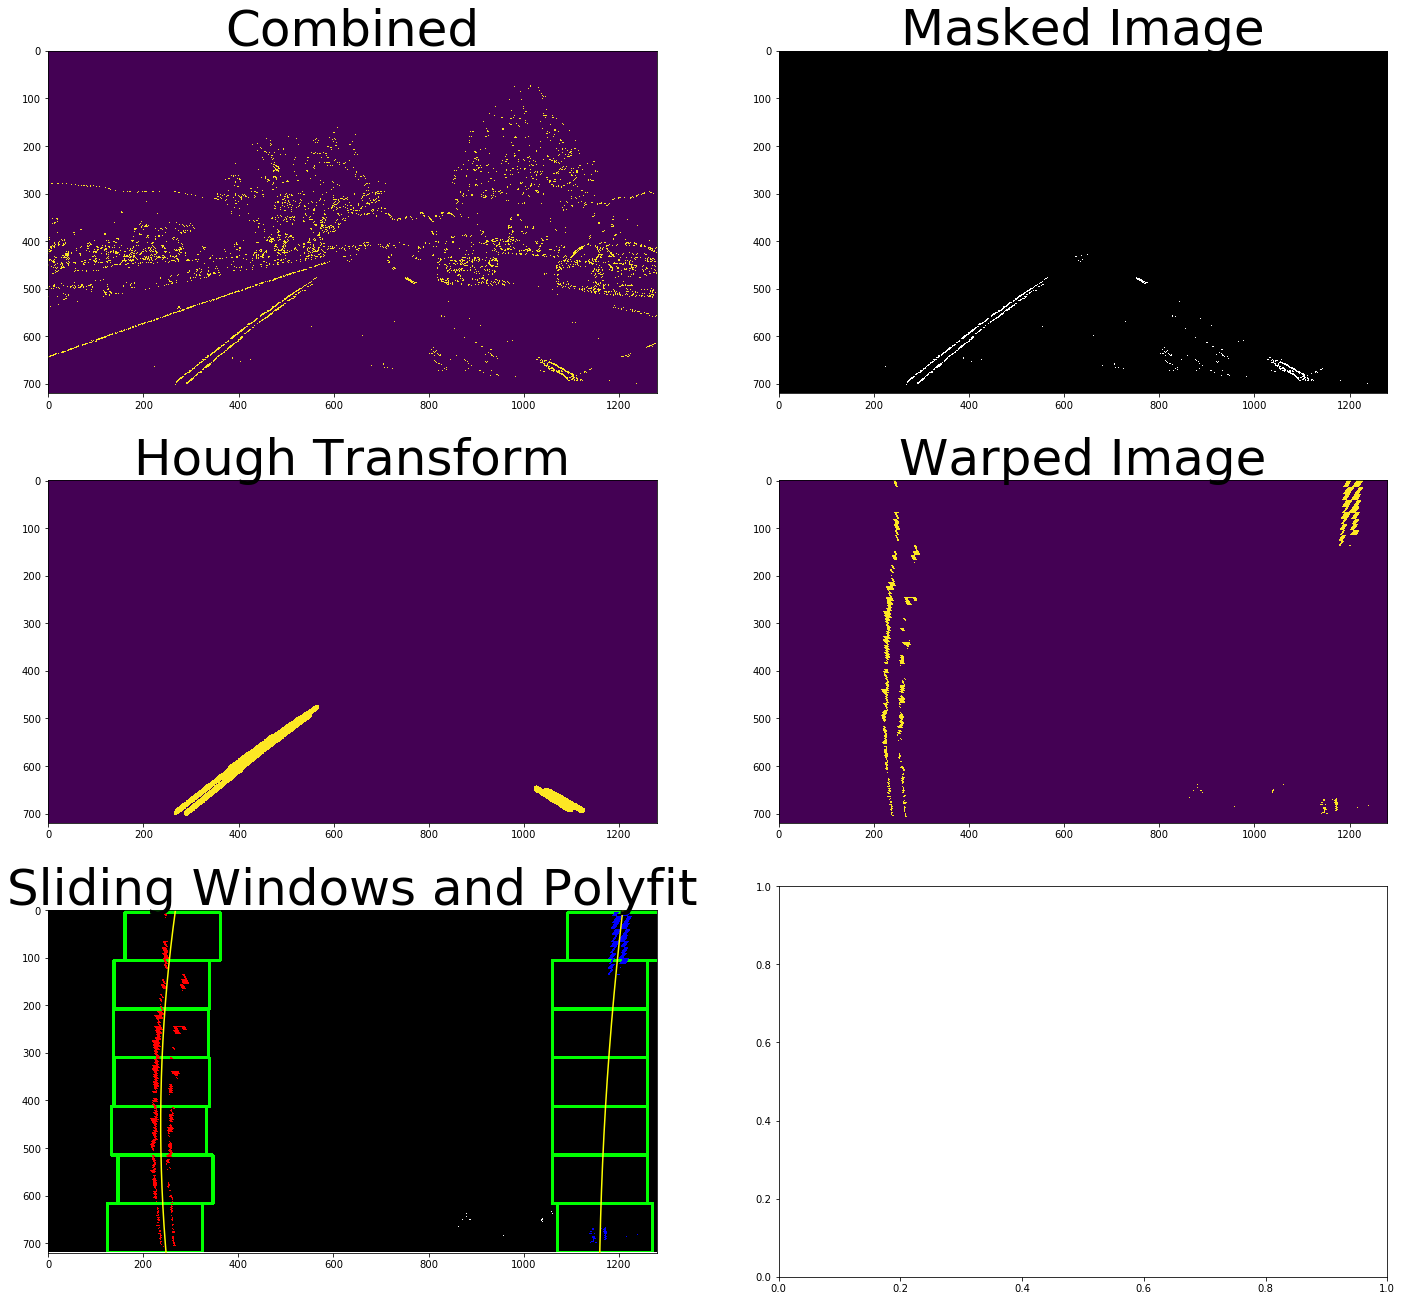

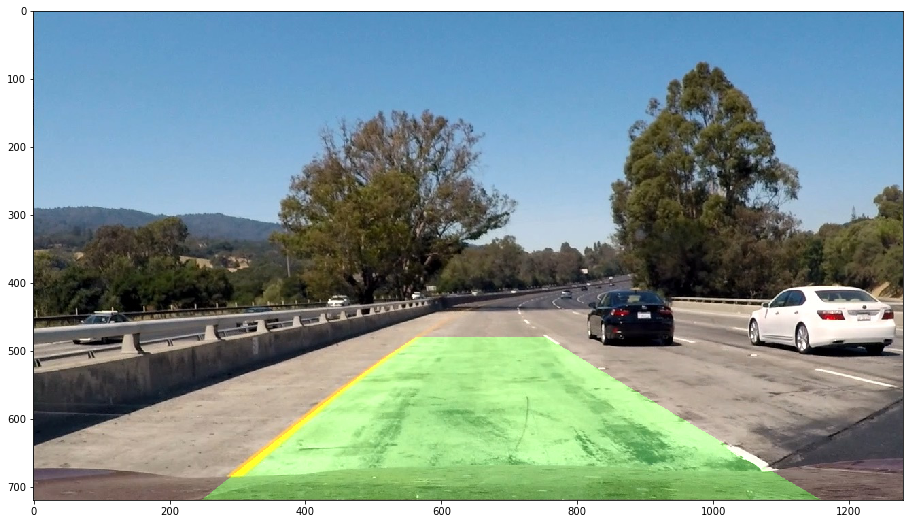

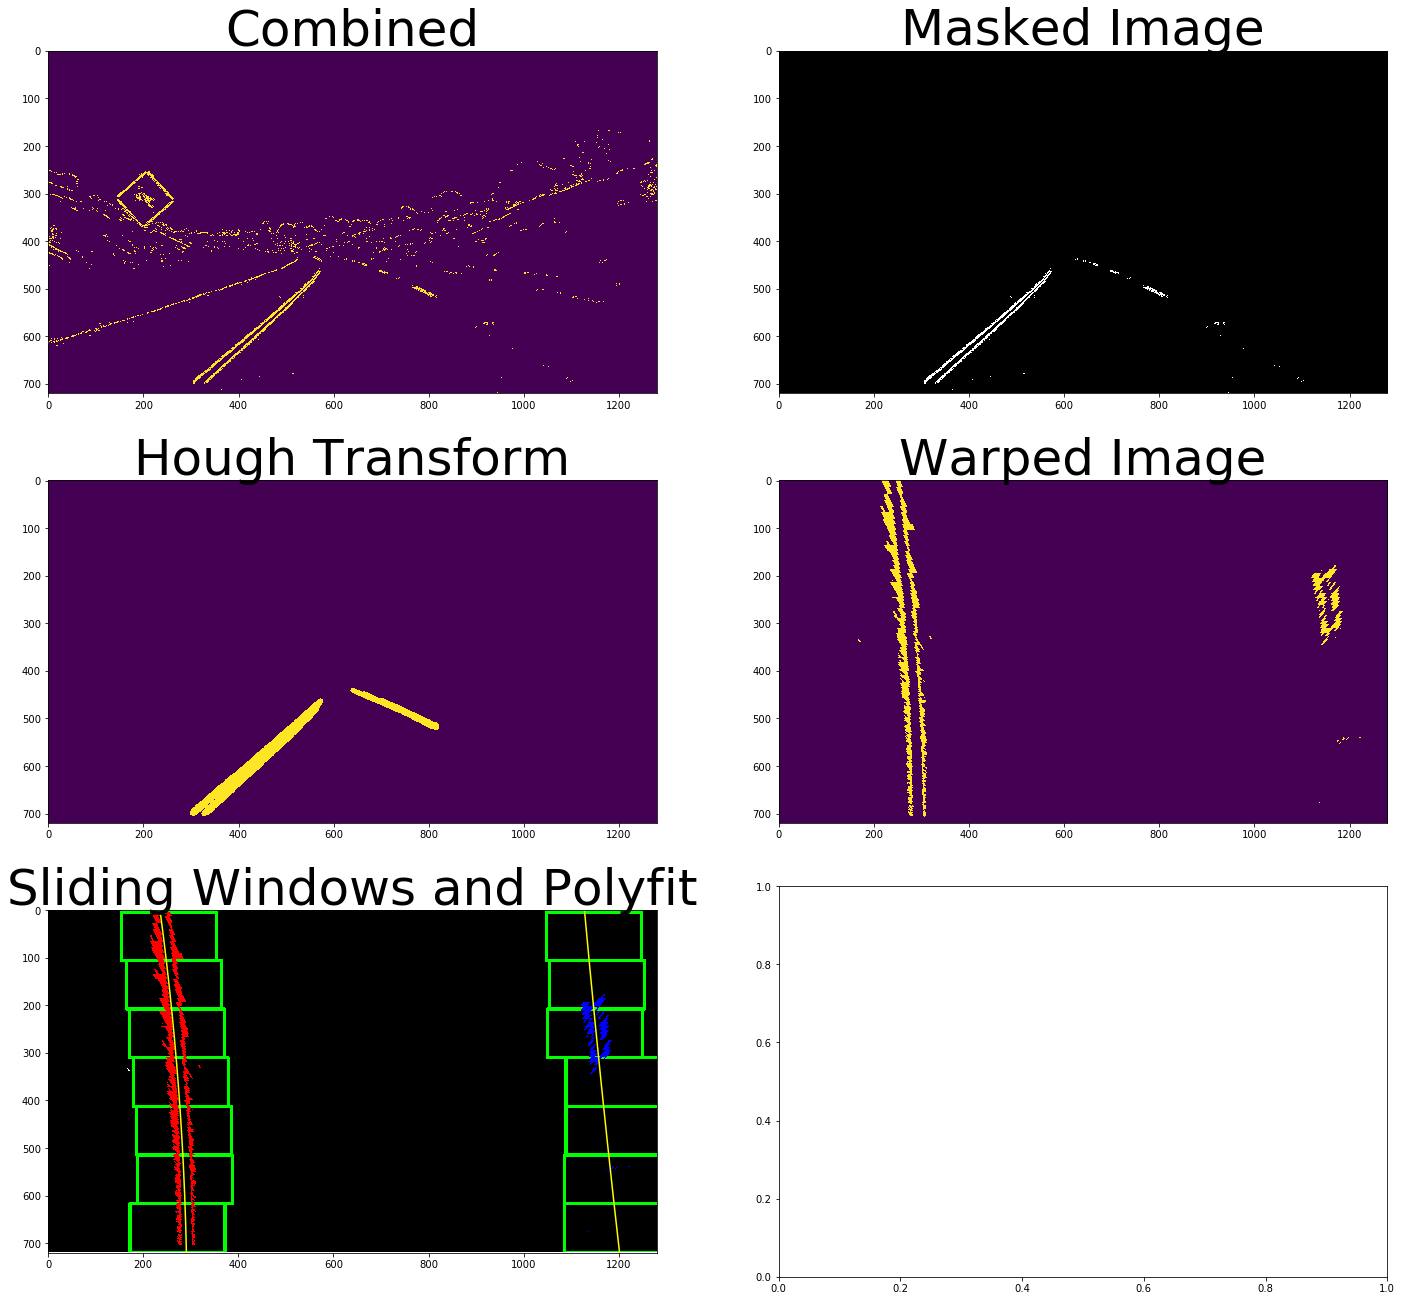

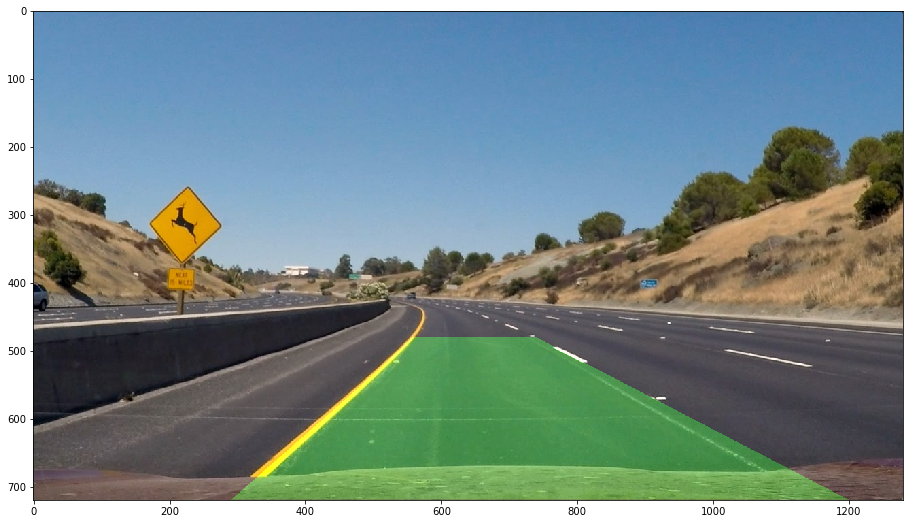

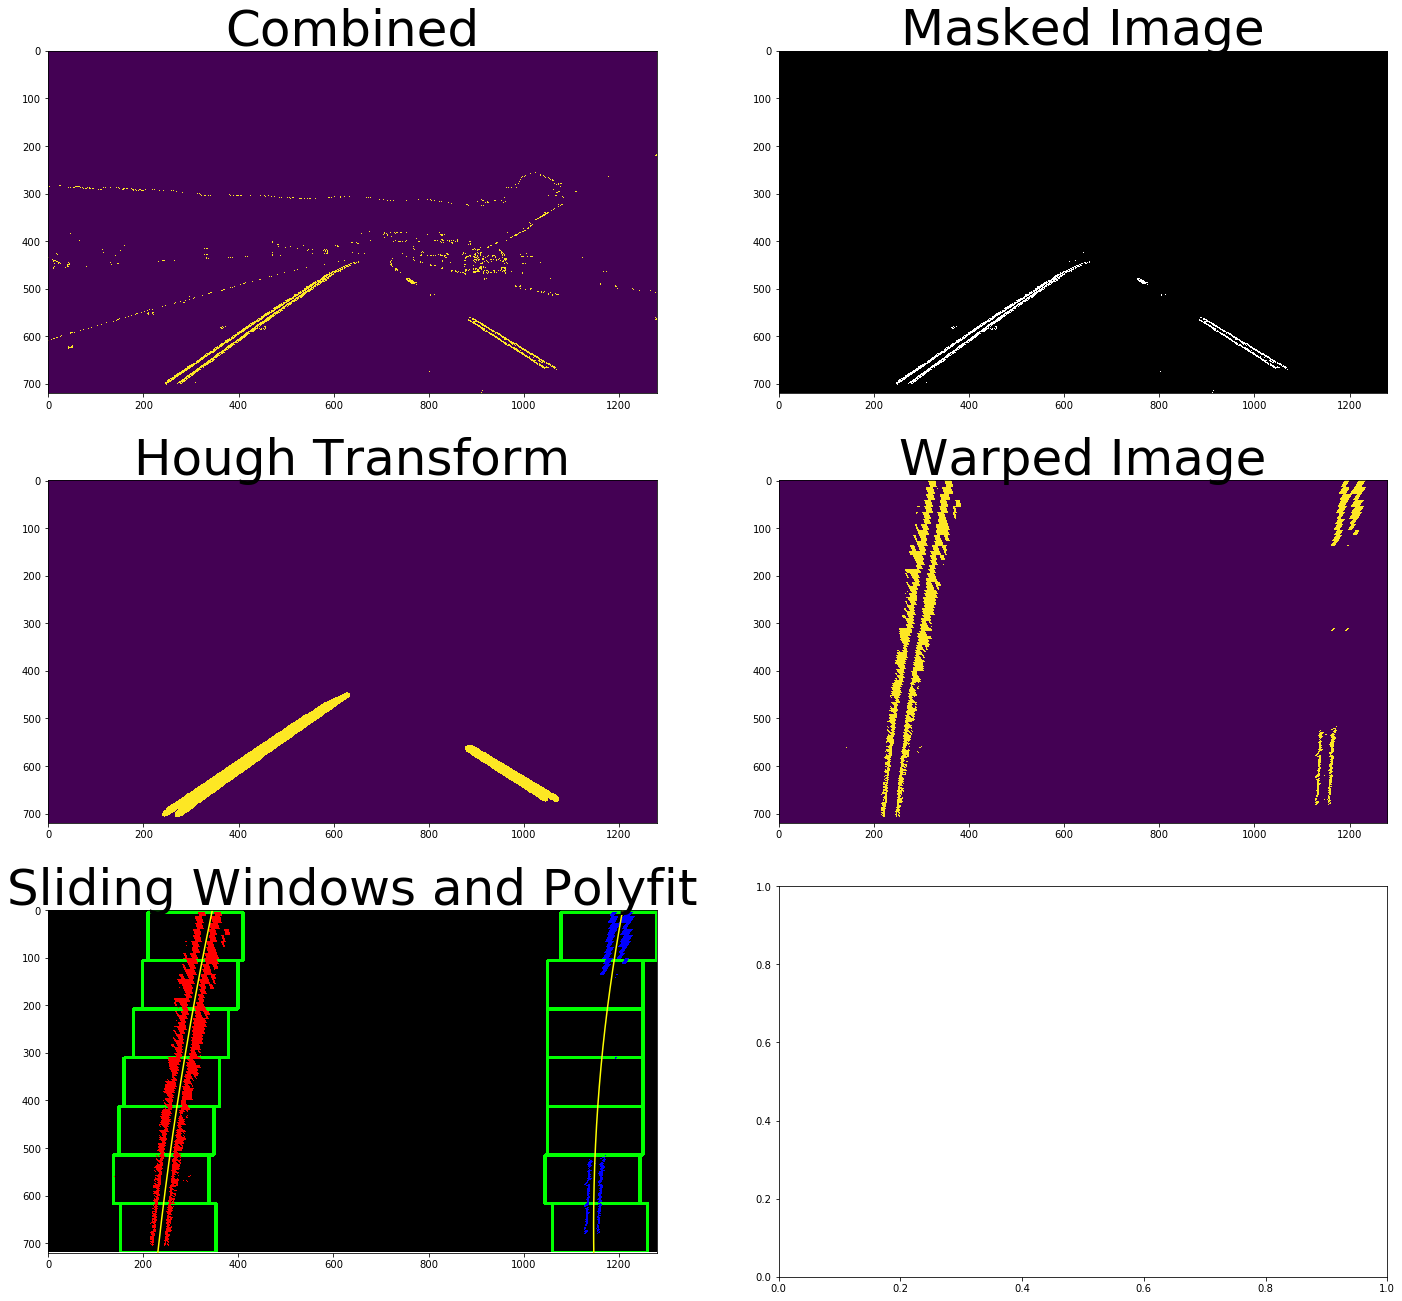

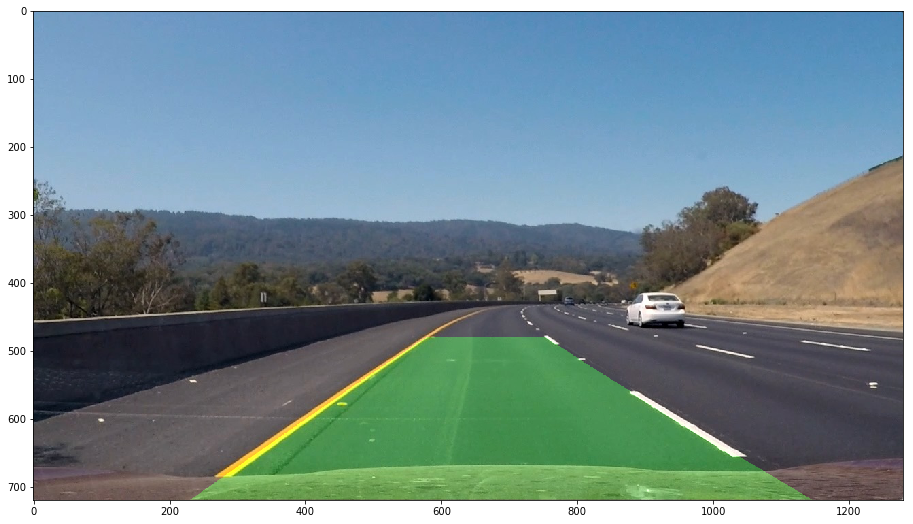

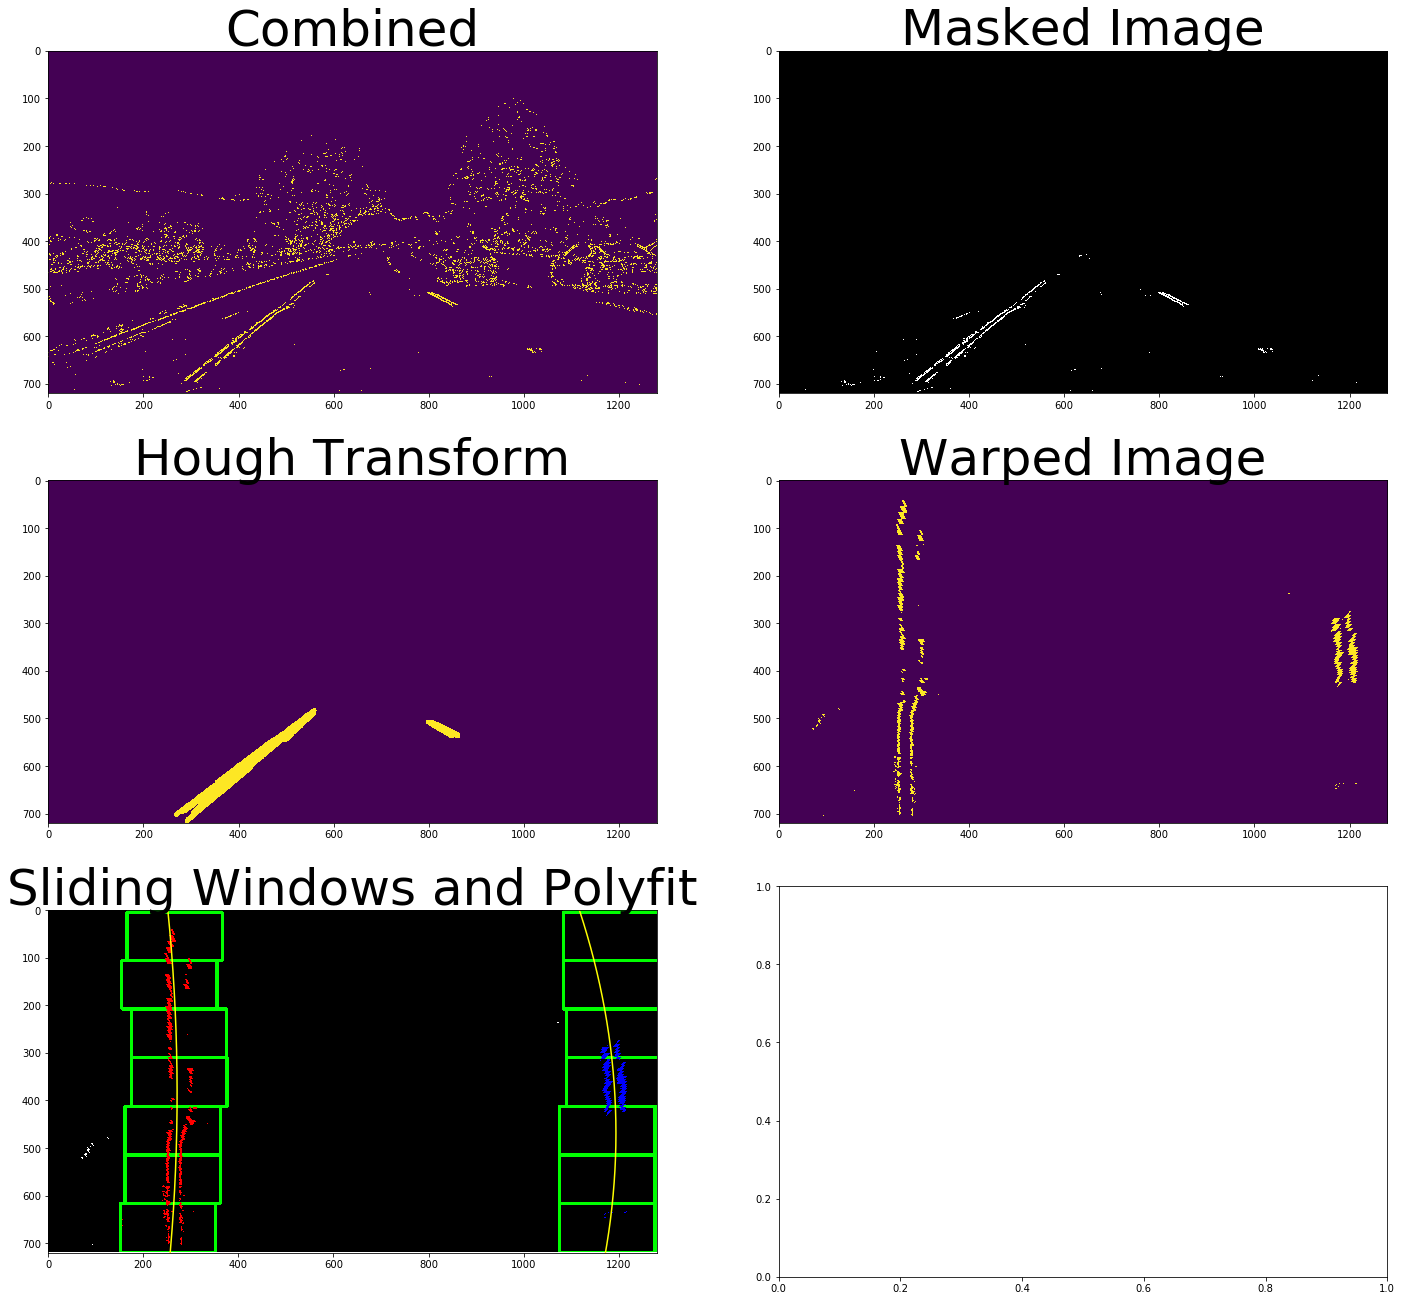

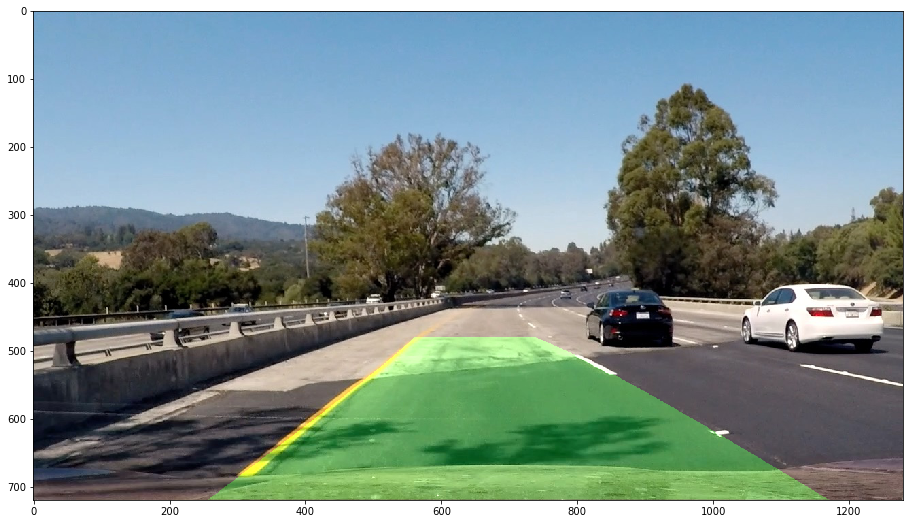

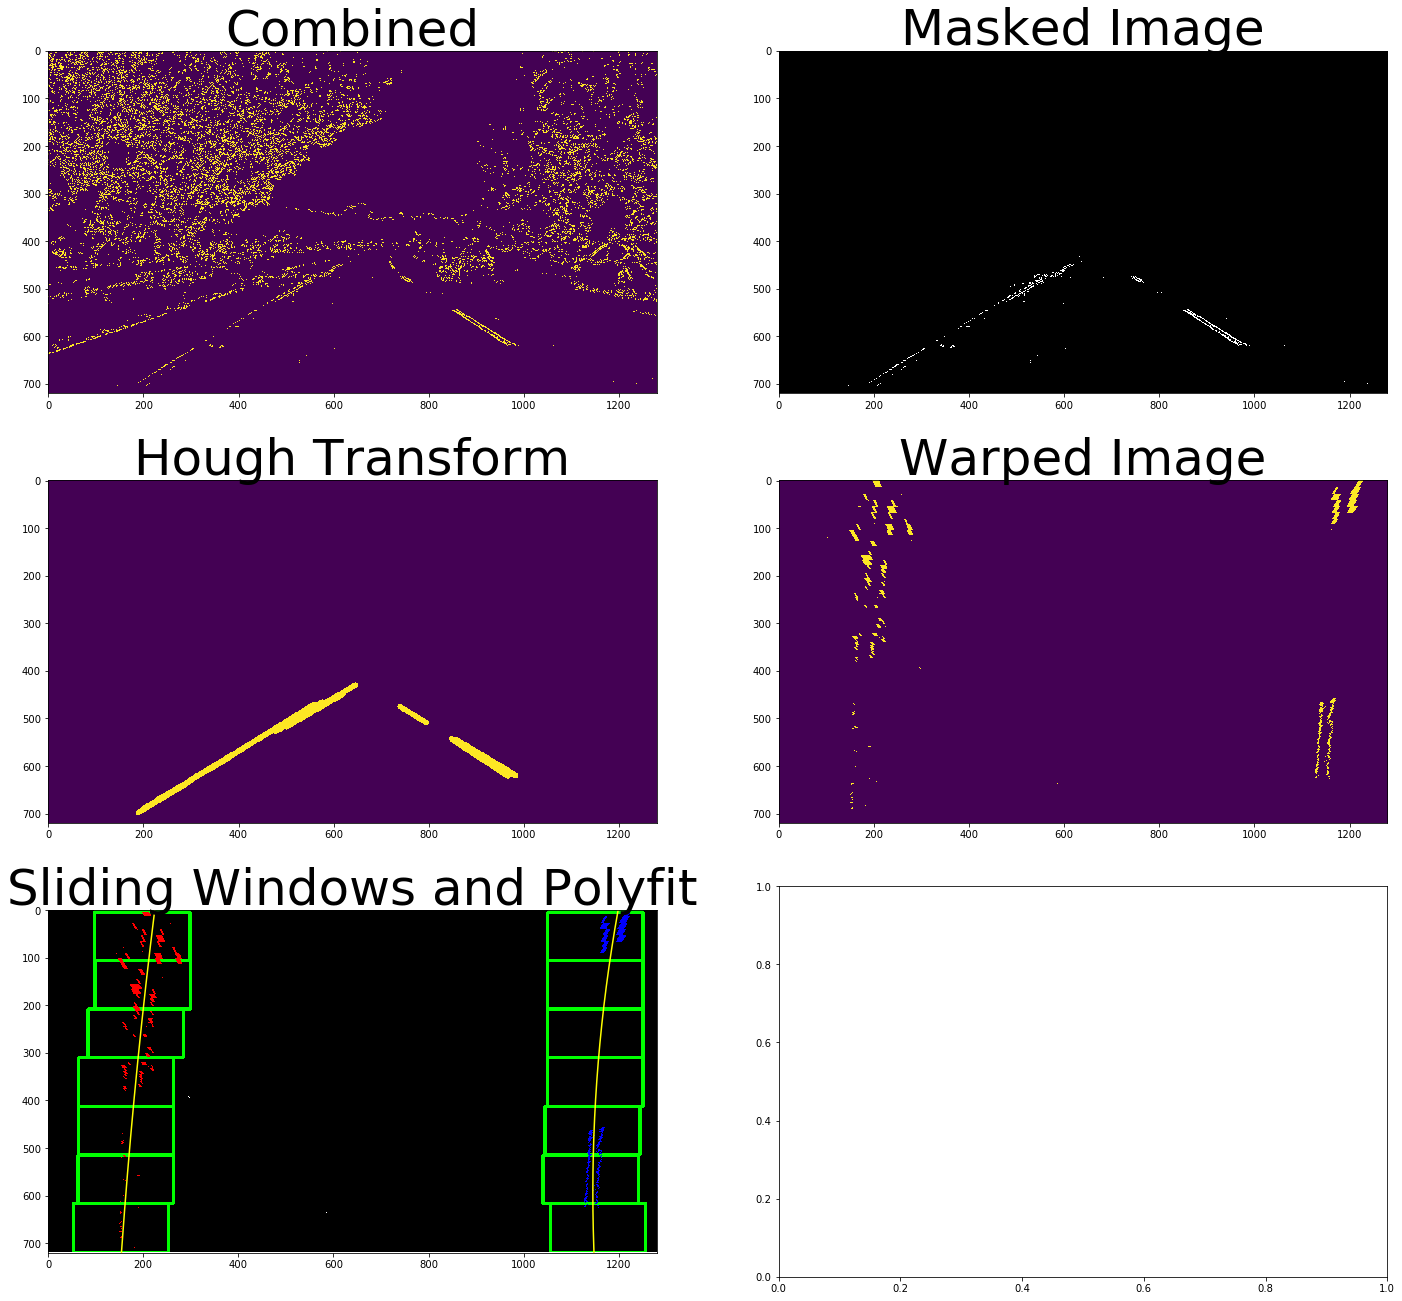

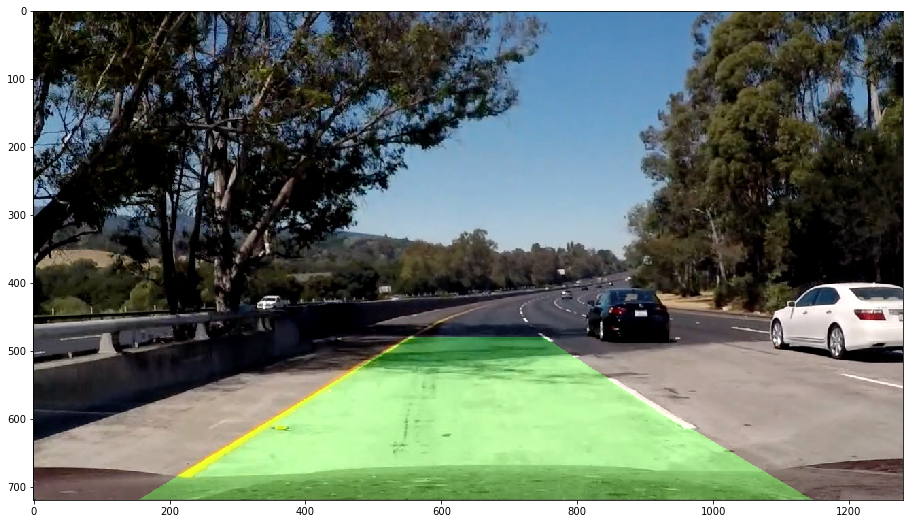

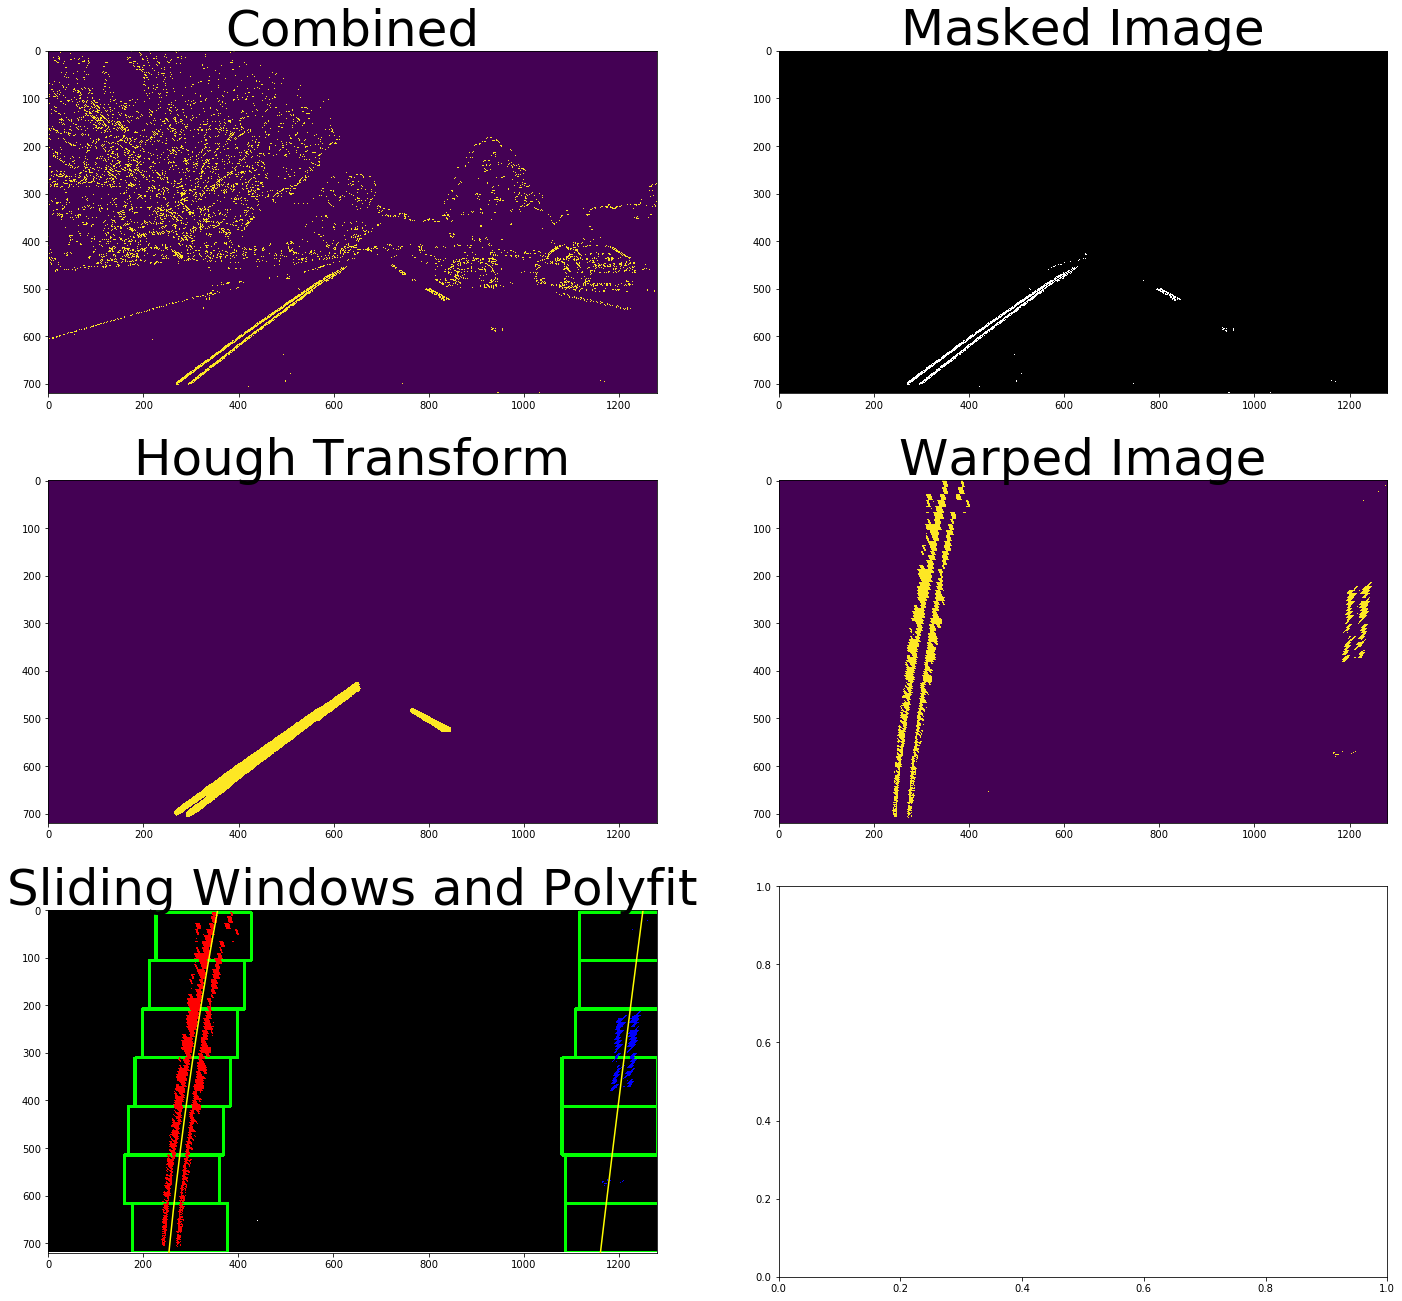

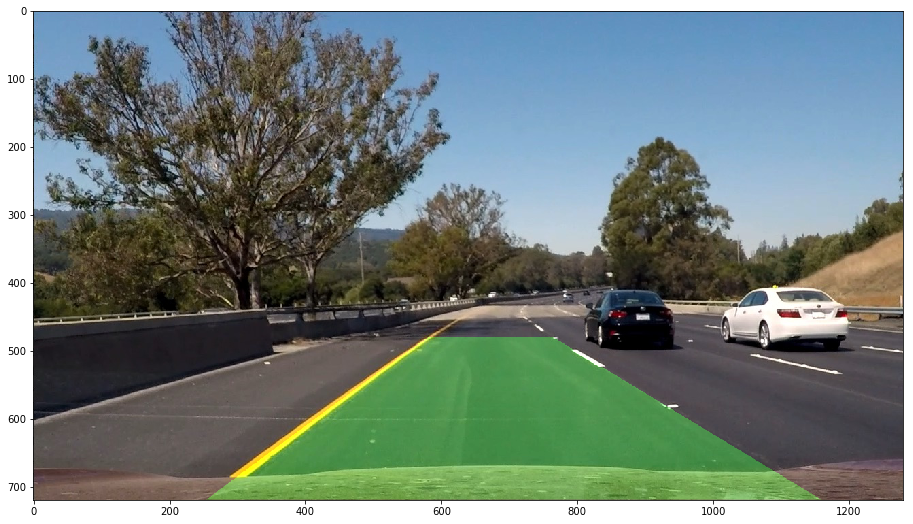

In [16]:
import pickle
dist_pickle = pickle.load( open( "camera_cal/camera_cal.p", "rb" ) )
mtx = dist_pickle["mtx"]
dist = dist_pickle["dist"]


channel = 'sat'
ksize = 3 # Choose a larger odd number to smooth gradient measurements
thresh = (50, 175)
mag_thresh = (50, 175)
dir_thresh=(0.7, 1.3)

for test_image in test_list:
    
    my_file_1 = test_image
    image = mpimg.imread('test_images/'+"%s"%(my_file_1))
    img_size = (image.shape[1], image.shape[0])
    
    
    print(image.dtype)
    print('This image is:', type(image), 'with dimensions:', image.shape)
    
    distort = DistortionCorrection(image, mtx, dist)
    
    
    combined = combined_grad(distort, channel, ksize, thresh, mag_thresh, dir_thresh)
    
    f,([ax1,ax2],[ax3,ax4],[ax5,ax6]) = plt.subplots(3,2, figsize=(24, 23), gridspec_kw={'hspace':0.1})
    ax1.imshow(combined)
    ax1.set_title('Combined', fontsize=50)
    #Region of Interest Vertices
    len_y = img_size[1]
    len_x = img_size[0]
    vertices = np.array([[(0,len_y), (len_x/2,425), (len_x,len_y)]], dtype=np.int32)
    
    
    masked_image, mask = region_of_interest(combined, vertices)

    
    #Hough Transform Parameters
    rho = 1
    theta = np.pi/180
    threshold = 50
    min_line_len = 30
    max_line_gap = 40
    line_image = np.copy(masked_image)*0
    center = masked_image.shape[1]/2
    
    ax2.imshow(masked_image, cmap = 'gray')
    ax2.set_title('Masked Image', fontsize=50)

    left_lane_line, right_lane_line, line_image = Hough_Trans(masked_image, rho, theta, threshold, min_line_len, max_line_gap, center, line_image)
    
    #Perspective Transform - Source Parameters
    top_line_perspective = 430
    bot_line_perspective = masked_image.shape[0]-30
    
    src = source(left_lane_line, right_lane_line, top_line_perspective, bot_line_perspective)
    
    color_edges = masked_image
    combo = cv2.addWeighted(color_edges, 0.8, line_image, 1, 0)
    ax3.imshow(combo)
    ax3.set_title('Hough Transform', fontsize=50)
    
    #Destination Parameters
    offset = 300
    dst = np.float32([(190, 720), (190, 0), (1130, 0), (1130, 720)])
    
    top_down, M, Minv = corners_unwarp(combined, src, dst, mtx, dist, img_size, offset)
    top_down = top_down.astype(dtype='uint8')
    
    ax4.imshow(top_down)
    ax4.set_title('Warped Image', fontsize=50)
    
    left_fit, right_fit, leftx, lefty, rightx, righty, out_img = find_lines(top_down)
    
    ploty = np.linspace(0, top_down.shape[0]-1, top_down.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]
    ax5.plot(left_fitx, ploty, color='yellow')
    ax5.plot(right_fitx, ploty, color='yellow')
    ax5.set_xlim([0, 1280])
    ax5.set_ylim([720, 0])
    ax5.set_title('Sliding Windows and Polyfit', fontsize=50)
    ax5.imshow(out_img)
    #print(out_img.max())
    
    ploty, left_fitx, right_fitx = linefit(top_down, left_fit, right_fit)
    result = drawing(image, top_down, left_fitx, right_fitx, ploty, Minv)
    fig, ax = plt.subplots(figsize=(24, 9))
    ax.imshow(result)
    

In [18]:
print(left_fit) 
print(right_fit)

[  6.02227174e-05  -1.85683401e-01   3.56417516e+02]
[  8.79368260e-06  -1.30575922e-01   1.25078578e+03]


## Test on Videos

In [26]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [27]:
import pickle
dist_pickle = pickle.load( open( "camera_cal/camera_cal.p", "rb" ) )
mtx = dist_pickle["mtx"]
dist = dist_pickle["dist"]

### Curvature

### Line Class

In [21]:
import collections

class Line():
    def __init__(self, n=5):
        # number of previous frames to save line data from
        self.n = n
        # number of fits in buffer
        self.n_buffered = 0
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = deque([], maxlen=n)
        # y values of the last n fits of the line
        self.recent_yfitted = deque([], maxlen=n)
        

        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None
    

### Pipeline

In [28]:
def process_image(image):
    
    #BINARY IMAGE
    
    img_size = (image.shape[1], image.shape[0])
    
    distort = DistortionCorrection(image, mtx, dist)
    
    channel = 'sat'
    ksize = 3 # Choose a larger odd number to smooth gradient measurements
    thresh = (50, 175)
    mag_thresh = (50, 175)
    dir_thresh=(0.7, 1.3)
    
    combined = combined_grad(distort, channel, ksize, thresh, mag_thresh, dir_thresh)
    mar
    
    #Perspective Transform - Source Parameters
    top_line_perspective = 480
    bot_line_perspective = masked_image.shape[0]-30
    
    src = source(left_lane_line, right_lane_line, top_line_perspective, bot_line_perspective)
    #this line above uses left_lane_line + right_lane_line from global variables
    
    #Destination Parameters
    offset = 200
    dst = np.float32([[offset, offset],
                  [img_size[0]-offset, offset],
                  [img_size[0]-offset, img_size[1]],
                  [offset, img_size[1]]])
    
    top_down, M, Minv = corners_unwarp(combined, src, dst, mtx, dist, img_size, offset)
    
    
    #LINE DETECTED IN LAST ITERATION?
    
    if l_global = True & r_global = True: #
        
        left_fit, right_fit, ploty, left_fitx, right_fitx = nextframe(top_down, left_line.current_fit, right_line.current_fit)
        
        if left_fit[0] = 0 & right_fit[0] = 0:

            #Region of Interest Vertices
            len_y = img_size[1]
            len_x = img_size[0]
            vertices = np.array([[(0,len_y), (len_x/2,425), (len_x,len_y)]], dtype=np.int32)

            masked_image, mask = region_of_interest(combined, vertices)

            #Hough Transform Parameters
            rho = 1
            theta = np.pi/180
            threshold = 50
            min_line_len = 30
            max_line_gap = 40
            line_image = np.copy(masked_image)*0
            center = masked_image.shape[1]/2

            left_lane_line, right_lane_line, line_image = Hough_Trans(masked_image, rho, theta, threshold, min_line_len, max_line_gap, center, line_image)

            if (left_lane_line[0] != 0) & (right_lane_line[0] != 0):

                left_fit, right_fit, leftx, lefty, rightx, righty, out_img = find_lines(top_down)

                ploty = np.linspace(0, top_down.shape[0]-1, top_down.shape[0] )
                left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
                right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

                out_img[lefty, leftx] = [255, 0, 0]
                out_img[righty, rightx] = [0, 0, 255]

                ploty, left_fitx, right_fitx = linefit(top_down, left_fit, right_fit)
                
            else:
                left_fitx = left_line.allx
                right_fitx = right_line.allx
                ploty = np.linspace(0, top_down.shape[0]-1, top_down.shape[0] )
                
        #result = drawing(image, top_down, left_fitx, right_fitx, ploty, Minv)
        
    else: 
        
        #Region of Interest Vertices
        len_y = img_size[1]
        len_x = img_size[0]
        vertices = np.array([[(0,len_y), (len_x/2,425), (len_x,len_y)]], dtype=np.int32)
    
    
        masked_image, mask = region_of_interest(combined, vertices)

    
        #Hough Transform Parameters
        rho = 1
        theta = np.pi/180
        threshold = 50
        min_line_len = 30
        max_line_gap = 40
        line_image = np.copy(masked_image)*0
        center = masked_image.shape[1]/2
        
        left_lane_line, right_lane_line, line_image = Hough_Trans(masked_image, rho, theta, threshold, min_line_len, max_line_gap, center, line_image)
        
        if (left_lane_line[0] != 0) & (right_lane_line[0] != 0):
        
            left_fit, right_fit, leftx, lefty, rightx, righty, out_img = find_lines(top_down)
    
            ploty = np.linspace(0, top_down.shape[0]-1, top_down.shape[0] )
            left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
            right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
            out_img[lefty, leftx] = [255, 0, 0]
            out_img[righty, rightx] = [0, 0, 255]
    
            ploty, left_fitx, right_fitx = linefit(top_down, left_fit, right_fit)
        
            #result = drawing(image, top_down, left_fitx, right_fitx, ploty, Minv)
        
        else:
            
            result = Line.image
            imagefailed = 'imagefailed'
            
    sanity_curve = False
    sanity_parallel = False
    sanity_hist = False
    
    # Sanity Check
    curve = Curvature(ploty, leftfit, rightfit)
    curve_range = 50
    if curve > (left_line.radius_of_curvature - curve_range) & curve < (right_line.radius_of_curvature + curve_range):
        sanity_curve = True
    
    bottom_gap = right_fitx[719]-left_fitx[719]
    top_gap = right_fitx[0]-left_fitx[0]
    gap_range = 75
    if np.abs(top_gap-bottom_gap)<gap_range:
        sanity_parallel = True
     
    hist_peak_range = 50 
    if left_fitx[719] > (left_line.allx[719] - hist_peak_range) & left_fitx[719] < (left_line.allx[719] + hist_peak_range) & right_fitx[719] > (right_line.allx[719] - hist_peak_range) & right_fitx[719] < (right_line.allx[719] - hist_peak_range):
        sanity_hist = True
    
    if sanity_curve & sanity_parallel & sanity_hist:
        
        left_line.detected = True
        right_line.detected = True
        
        left_line.current_fit = left_fit
        right_line.current_fit = right_fit
        
        left_line.allx = left_fitx
        right_line.allx = right_fitx
        
        left_line.ally = ploty
        right_line.ally = ploty
        
        left_line.recent_xfitted.append(left_fitx)
        right_line.recent_xfitted.append(right_fitx)
        
        left_line.recent_yfitted.append(ploty)
        right_line.recent_yfitted.append(ploty)

    final_left_fitx = left_line.recent_xfitted
    final_right_fitx = right_line.recent_yfitted
    ploty 
        result = drawing(image, top_down, left_fitx, right_fitx, ploty, Minv)
        
    return result
    

In [21]:
print(ploty.shape)

(720,)


In [29]:
l_global = False
r_global = False
l_fit_global = None
r_fit_global = None
l_fit_hist_global = []
r_fit_hist_global = []

white_output = 'test_videos_output/project_video_output.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)


uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)
[MoviePy] >>>> Building video test_videos_output/project_video_output.mp4
[MoviePy] Writing video test_videos_output/project_video_output.mp4


  0%|                                                                                              | 0/1261 [00:00<?, ?it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


  0%|                                                                                      | 1/1261 [00:00<09:22,  2.24it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


  0%|▏                                                                                     | 2/1261 [00:00<09:25,  2.23it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


  0%|▏                                                                                     | 3/1261 [00:01<09:17,  2.26it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


  0%|▎                                                                                     | 4/1261 [00:01<09:16,  2.26it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


  0%|▎                                                                                     | 5/1261 [00:02<09:19,  2.24it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


  0%|▍                                                                                     | 6/1261 [00:02<09:15,  2.26it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


  1%|▍                                                                                     | 7/1261 [00:03<09:09,  2.28it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


  1%|▌                                                                                     | 8/1261 [00:03<09:15,  2.25it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


  1%|▌                                                                                     | 9/1261 [00:04<09:21,  2.23it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


  1%|▋                                                                                    | 10/1261 [00:04<09:22,  2.22it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


  1%|▋                                                                                    | 11/1261 [00:04<09:18,  2.24it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


  1%|▊                                                                                    | 12/1261 [00:05<09:15,  2.25it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


  1%|▉                                                                                    | 13/1261 [00:05<09:09,  2.27it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


  1%|▉                                                                                    | 14/1261 [00:06<09:14,  2.25it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


  1%|█                                                                                    | 15/1261 [00:06<09:16,  2.24it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


  1%|█                                                                                    | 16/1261 [00:07<09:25,  2.20it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


  1%|█▏                                                                                   | 17/1261 [00:07<09:42,  2.13it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


  1%|█▏                                                                                   | 18/1261 [00:08<09:57,  2.08it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


  2%|█▎                                                                                   | 19/1261 [00:08<09:47,  2.11it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


  2%|█▎                                                                                   | 20/1261 [00:09<09:59,  2.07it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


  2%|█▍                                                                                   | 21/1261 [00:09<10:01,  2.06it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


  2%|█▍                                                                                   | 22/1261 [00:10<10:14,  2.02it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


  2%|█▌                                                                                   | 23/1261 [00:10<10:13,  2.02it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


  2%|█▌                                                                                   | 24/1261 [00:11<10:02,  2.05it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


  2%|█▋                                                                                   | 25/1261 [00:11<10:06,  2.04it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


  2%|█▊                                                                                   | 26/1261 [00:12<10:05,  2.04it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


  2%|█▊                                                                                   | 27/1261 [00:12<09:48,  2.10it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


  2%|█▉                                                                                   | 28/1261 [00:12<09:39,  2.13it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


  2%|█▉                                                                                   | 29/1261 [00:13<09:44,  2.11it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


  2%|██                                                                                   | 30/1261 [00:13<09:49,  2.09it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


  2%|██                                                                                   | 31/1261 [00:14<09:58,  2.06it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


  3%|██▏                                                                                  | 32/1261 [00:14<09:54,  2.07it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


  3%|██▏                                                                                  | 33/1261 [00:15<09:45,  2.10it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


  3%|██▎                                                                                  | 34/1261 [00:15<09:33,  2.14it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


  3%|██▎                                                                                  | 35/1261 [00:16<09:30,  2.15it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


  3%|██▍                                                                                  | 36/1261 [00:16<09:22,  2.18it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


  3%|██▍                                                                                  | 37/1261 [00:17<09:10,  2.22it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


  3%|██▌                                                                                  | 38/1261 [00:17<09:09,  2.22it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


  3%|██▋                                                                                  | 39/1261 [00:18<09:07,  2.23it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


  3%|██▋                                                                                  | 40/1261 [00:18<09:19,  2.18it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


  3%|██▊                                                                                  | 41/1261 [00:19<09:21,  2.17it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


  3%|██▊                                                                                  | 42/1261 [00:19<09:21,  2.17it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


  3%|██▉                                                                                  | 43/1261 [00:19<09:35,  2.11it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


  3%|██▉                                                                                  | 44/1261 [00:20<09:37,  2.11it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


  4%|███                                                                                  | 45/1261 [00:21<10:11,  1.99it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


  4%|███                                                                                  | 46/1261 [00:21<10:41,  1.89it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


  4%|███▏                                                                                 | 47/1261 [00:22<10:47,  1.88it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


  4%|███▏                                                                                 | 48/1261 [00:22<10:34,  1.91it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


  4%|███▎                                                                                 | 49/1261 [00:23<10:25,  1.94it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


  4%|███▎                                                                                 | 50/1261 [00:23<10:01,  2.01it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


  4%|███▍                                                                                 | 51/1261 [00:24<10:02,  2.01it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


  4%|███▌                                                                                 | 52/1261 [00:24<10:01,  2.01it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


  4%|███▌                                                                                 | 53/1261 [00:25<10:08,  1.98it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


  4%|███▋                                                                                 | 54/1261 [00:25<09:57,  2.02it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


  4%|███▋                                                                                 | 55/1261 [00:26<09:49,  2.05it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


  4%|███▊                                                                                 | 56/1261 [00:26<09:39,  2.08it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


  5%|███▊                                                                                 | 57/1261 [00:27<09:35,  2.09it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


  5%|███▉                                                                                 | 58/1261 [00:27<09:38,  2.08it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


  5%|███▉                                                                                 | 59/1261 [00:27<09:35,  2.09it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


  5%|████                                                                                 | 60/1261 [00:28<09:36,  2.08it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


  5%|████                                                                                 | 61/1261 [00:28<09:34,  2.09it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


  5%|████▏                                                                                | 62/1261 [00:29<09:32,  2.10it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


  5%|████▏                                                                                | 63/1261 [00:29<09:35,  2.08it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


  5%|████▎                                                                                | 64/1261 [00:30<09:32,  2.09it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


  5%|████▍                                                                                | 65/1261 [00:30<09:28,  2.10it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


  5%|████▍                                                                                | 66/1261 [00:31<09:27,  2.11it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


  5%|████▌                                                                                | 67/1261 [00:31<09:22,  2.12it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


  5%|████▌                                                                                | 68/1261 [00:32<09:28,  2.10it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


  5%|████▋                                                                                | 69/1261 [00:32<09:29,  2.09it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


  6%|████▋                                                                                | 70/1261 [00:33<09:24,  2.11it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


  6%|████▊                                                                                | 71/1261 [00:33<09:29,  2.09it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


  6%|████▊                                                                                | 72/1261 [00:34<09:27,  2.10it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


  6%|████▉                                                                                | 73/1261 [00:34<09:24,  2.10it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


  6%|████▉                                                                                | 74/1261 [00:35<09:24,  2.10it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


  6%|█████                                                                                | 75/1261 [00:35<09:22,  2.11it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


  6%|█████                                                                                | 76/1261 [00:36<09:24,  2.10it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


  6%|█████▏                                                                               | 77/1261 [00:36<09:24,  2.10it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


  6%|█████▎                                                                               | 78/1261 [00:37<09:18,  2.12it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


  6%|█████▎                                                                               | 79/1261 [00:37<09:24,  2.09it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


  6%|█████▍                                                                               | 80/1261 [00:37<09:18,  2.12it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


  6%|█████▍                                                                               | 81/1261 [00:38<09:13,  2.13it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


  7%|█████▌                                                                               | 82/1261 [00:38<09:18,  2.11it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


  7%|█████▌                                                                               | 83/1261 [00:39<09:18,  2.11it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


  7%|█████▋                                                                               | 84/1261 [00:39<09:14,  2.12it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


  7%|█████▋                                                                               | 85/1261 [00:40<09:17,  2.11it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


  7%|█████▊                                                                               | 86/1261 [00:40<09:14,  2.12it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


  7%|█████▊                                                                               | 87/1261 [00:41<09:20,  2.10it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


  7%|█████▉                                                                               | 88/1261 [00:41<09:20,  2.09it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


  7%|█████▉                                                                               | 89/1261 [00:42<09:14,  2.11it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


  7%|██████                                                                               | 90/1261 [00:42<09:17,  2.10it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


  7%|██████▏                                                                              | 91/1261 [00:43<09:19,  2.09it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


  7%|██████▏                                                                              | 92/1261 [00:43<09:19,  2.09it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


  7%|██████▎                                                                              | 93/1261 [00:44<09:21,  2.08it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


  7%|██████▎                                                                              | 94/1261 [00:44<09:15,  2.10it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


  8%|██████▍                                                                              | 95/1261 [00:45<09:16,  2.09it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


  8%|██████▍                                                                              | 96/1261 [00:45<09:12,  2.11it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


  8%|██████▌                                                                              | 97/1261 [00:46<09:07,  2.13it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


  8%|██████▌                                                                              | 98/1261 [00:46<09:09,  2.12it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


  8%|██████▋                                                                              | 99/1261 [00:46<09:09,  2.12it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


  8%|██████▋                                                                             | 100/1261 [00:47<09:08,  2.12it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


  8%|██████▋                                                                             | 101/1261 [00:47<09:14,  2.09it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


  8%|██████▊                                                                             | 102/1261 [00:48<09:22,  2.06it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


  8%|██████▊                                                                             | 103/1261 [00:48<09:34,  2.02it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


  8%|██████▉                                                                             | 104/1261 [00:49<09:32,  2.02it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


  8%|██████▉                                                                             | 105/1261 [00:49<09:23,  2.05it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


  8%|███████                                                                             | 106/1261 [00:50<09:14,  2.08it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


  8%|███████▏                                                                            | 107/1261 [00:50<09:13,  2.09it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


  9%|███████▏                                                                            | 108/1261 [00:51<09:11,  2.09it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


  9%|███████▎                                                                            | 109/1261 [00:51<09:10,  2.09it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


  9%|███████▎                                                                            | 110/1261 [00:52<09:06,  2.11it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


  9%|███████▍                                                                            | 111/1261 [00:52<09:12,  2.08it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


  9%|███████▍                                                                            | 112/1261 [00:53<09:13,  2.08it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


  9%|███████▌                                                                            | 113/1261 [00:53<09:18,  2.06it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


  9%|███████▌                                                                            | 114/1261 [00:54<09:12,  2.08it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


  9%|███████▋                                                                            | 115/1261 [00:54<09:16,  2.06it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


  9%|███████▋                                                                            | 116/1261 [00:55<09:10,  2.08it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


  9%|███████▊                                                                            | 117/1261 [00:55<09:08,  2.09it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


  9%|███████▊                                                                            | 118/1261 [00:56<09:14,  2.06it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


  9%|███████▉                                                                            | 119/1261 [00:56<09:04,  2.10it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 10%|███████▉                                                                            | 120/1261 [00:57<08:59,  2.11it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 10%|████████                                                                            | 121/1261 [00:57<09:11,  2.07it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 10%|████████▏                                                                           | 122/1261 [00:58<09:05,  2.09it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 10%|████████▏                                                                           | 123/1261 [00:58<09:10,  2.07it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 10%|████████▎                                                                           | 124/1261 [00:59<09:02,  2.09it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 10%|████████▎                                                                           | 125/1261 [00:59<09:19,  2.03it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 10%|████████▍                                                                           | 126/1261 [01:00<09:19,  2.03it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 10%|████████▍                                                                           | 127/1261 [01:00<09:21,  2.02it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 10%|████████▌                                                                           | 128/1261 [01:01<09:14,  2.04it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 10%|████████▌                                                                           | 129/1261 [01:01<09:10,  2.06it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 10%|████████▋                                                                           | 130/1261 [01:01<09:14,  2.04it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 10%|████████▋                                                                           | 131/1261 [01:02<09:10,  2.05it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 10%|████████▊                                                                           | 132/1261 [01:02<09:10,  2.05it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 11%|████████▊                                                                           | 133/1261 [01:03<09:10,  2.05it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 11%|████████▉                                                                           | 134/1261 [01:03<09:05,  2.07it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 11%|████████▉                                                                           | 135/1261 [01:04<08:57,  2.09it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 11%|█████████                                                                           | 136/1261 [01:04<08:53,  2.11it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 11%|█████████▏                                                                          | 137/1261 [01:05<08:53,  2.11it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 11%|█████████▏                                                                          | 138/1261 [01:05<08:50,  2.12it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 11%|█████████▎                                                                          | 139/1261 [01:06<08:50,  2.12it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 11%|█████████▎                                                                          | 140/1261 [01:06<08:47,  2.13it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 11%|█████████▍                                                                          | 141/1261 [01:07<08:47,  2.12it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 11%|█████████▍                                                                          | 142/1261 [01:07<08:51,  2.10it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 11%|█████████▌                                                                          | 143/1261 [01:08<08:51,  2.10it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 11%|█████████▌                                                                          | 144/1261 [01:08<08:47,  2.12it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 11%|█████████▋                                                                          | 145/1261 [01:09<08:45,  2.12it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 12%|█████████▋                                                                          | 146/1261 [01:09<08:45,  2.12it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 12%|█████████▊                                                                          | 147/1261 [01:10<08:42,  2.13it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 12%|█████████▊                                                                          | 148/1261 [01:10<08:44,  2.12it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 12%|█████████▉                                                                          | 149/1261 [01:10<08:44,  2.12it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 12%|█████████▉                                                                          | 150/1261 [01:11<08:39,  2.14it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 12%|██████████                                                                          | 151/1261 [01:11<08:46,  2.11it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 12%|██████████▏                                                                         | 152/1261 [01:12<08:43,  2.12it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 12%|██████████▏                                                                         | 153/1261 [01:12<08:42,  2.12it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 12%|██████████▎                                                                         | 154/1261 [01:13<08:43,  2.11it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 12%|██████████▎                                                                         | 155/1261 [01:13<08:41,  2.12it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 12%|██████████▍                                                                         | 156/1261 [01:14<08:43,  2.11it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 12%|██████████▍                                                                         | 157/1261 [01:14<08:42,  2.11it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 13%|██████████▌                                                                         | 158/1261 [01:15<08:39,  2.12it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 13%|██████████▌                                                                         | 159/1261 [01:15<08:36,  2.13it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 13%|██████████▋                                                                         | 160/1261 [01:16<08:36,  2.13it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 13%|██████████▋                                                                         | 161/1261 [01:16<08:35,  2.14it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 13%|██████████▊                                                                         | 162/1261 [01:17<08:40,  2.11it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 13%|██████████▊                                                                         | 163/1261 [01:17<08:36,  2.12it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 13%|██████████▉                                                                         | 164/1261 [01:18<08:41,  2.10it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 13%|██████████▉                                                                         | 165/1261 [01:18<08:46,  2.08it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 13%|███████████                                                                         | 166/1261 [01:19<08:47,  2.08it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 13%|███████████                                                                         | 167/1261 [01:19<08:48,  2.07it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 13%|███████████▏                                                                        | 168/1261 [01:20<08:47,  2.07it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 13%|███████████▎                                                                        | 169/1261 [01:20<08:46,  2.07it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 13%|███████████▎                                                                        | 170/1261 [01:20<08:45,  2.08it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 14%|███████████▍                                                                        | 171/1261 [01:21<08:36,  2.11it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 14%|███████████▍                                                                        | 172/1261 [01:21<08:37,  2.11it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 14%|███████████▌                                                                        | 173/1261 [01:22<08:32,  2.12it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 14%|███████████▌                                                                        | 174/1261 [01:22<08:30,  2.13it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 14%|███████████▋                                                                        | 175/1261 [01:23<08:28,  2.14it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 14%|███████████▋                                                                        | 176/1261 [01:23<08:30,  2.12it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 14%|███████████▊                                                                        | 177/1261 [01:24<08:28,  2.13it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 14%|███████████▊                                                                        | 178/1261 [01:24<08:32,  2.11it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 14%|███████████▉                                                                        | 179/1261 [01:25<08:30,  2.12it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 14%|███████████▉                                                                        | 180/1261 [01:25<08:29,  2.12it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 14%|████████████                                                                        | 181/1261 [01:26<08:35,  2.10it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 14%|████████████                                                                        | 182/1261 [01:26<08:32,  2.11it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 15%|████████████▏                                                                       | 183/1261 [01:27<08:37,  2.08it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 15%|████████████▎                                                                       | 184/1261 [01:27<08:35,  2.09it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 15%|████████████▎                                                                       | 185/1261 [01:28<08:29,  2.11it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 15%|████████████▍                                                                       | 186/1261 [01:28<08:29,  2.11it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 15%|████████████▍                                                                       | 187/1261 [01:29<08:26,  2.12it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 15%|████████████▌                                                                       | 188/1261 [01:29<08:24,  2.13it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 15%|████████████▌                                                                       | 189/1261 [01:29<08:26,  2.11it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 15%|████████████▋                                                                       | 190/1261 [01:30<08:23,  2.13it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 15%|████████████▋                                                                       | 191/1261 [01:30<08:22,  2.13it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 15%|████████████▊                                                                       | 192/1261 [01:31<08:23,  2.12it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 15%|████████████▊                                                                       | 193/1261 [01:31<08:24,  2.12it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 15%|████████████▉                                                                       | 194/1261 [01:32<08:26,  2.11it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 15%|████████████▉                                                                       | 195/1261 [01:32<08:27,  2.10it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 16%|█████████████                                                                       | 196/1261 [01:33<08:21,  2.12it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 16%|█████████████                                                                       | 197/1261 [01:33<08:29,  2.09it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 16%|█████████████▏                                                                      | 198/1261 [01:34<08:27,  2.10it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 16%|█████████████▎                                                                      | 199/1261 [01:34<08:22,  2.11it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 16%|█████████████▎                                                                      | 200/1261 [01:35<08:20,  2.12it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 16%|█████████████▍                                                                      | 201/1261 [01:35<08:22,  2.11it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 16%|█████████████▍                                                                      | 202/1261 [01:36<08:27,  2.09it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 16%|█████████████▌                                                                      | 203/1261 [01:36<08:29,  2.08it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 16%|█████████████▌                                                                      | 204/1261 [01:37<08:25,  2.09it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 16%|█████████████▋                                                                      | 205/1261 [01:37<08:25,  2.09it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 16%|█████████████▋                                                                      | 206/1261 [01:38<08:27,  2.08it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 16%|█████████████▊                                                                      | 207/1261 [01:38<08:27,  2.08it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 16%|█████████████▊                                                                      | 208/1261 [01:39<08:25,  2.08it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 17%|█████████████▉                                                                      | 209/1261 [01:39<08:19,  2.10it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 17%|█████████████▉                                                                      | 210/1261 [01:39<08:19,  2.10it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 17%|██████████████                                                                      | 211/1261 [01:40<08:27,  2.07it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 17%|██████████████                                                                      | 212/1261 [01:40<08:29,  2.06it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 17%|██████████████▏                                                                     | 213/1261 [01:41<08:29,  2.06it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 17%|██████████████▎                                                                     | 214/1261 [01:41<08:21,  2.09it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 17%|██████████████▎                                                                     | 215/1261 [01:42<08:22,  2.08it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 17%|██████████████▍                                                                     | 216/1261 [01:42<08:20,  2.09it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 17%|██████████████▍                                                                     | 217/1261 [01:43<08:21,  2.08it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 17%|██████████████▌                                                                     | 218/1261 [01:43<08:20,  2.09it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 17%|██████████████▌                                                                     | 219/1261 [01:44<08:16,  2.10it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 17%|██████████████▋                                                                     | 220/1261 [01:44<08:15,  2.10it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 18%|██████████████▋                                                                     | 221/1261 [01:45<08:13,  2.11it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 18%|██████████████▊                                                                     | 222/1261 [01:45<08:12,  2.11it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 18%|██████████████▊                                                                     | 223/1261 [01:46<08:10,  2.12it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 18%|██████████████▉                                                                     | 224/1261 [01:46<08:12,  2.11it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 18%|██████████████▉                                                                     | 225/1261 [01:47<08:13,  2.10it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 18%|███████████████                                                                     | 226/1261 [01:47<08:13,  2.10it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 18%|███████████████                                                                     | 227/1261 [01:48<08:11,  2.10it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 18%|███████████████▏                                                                    | 228/1261 [01:48<08:18,  2.07it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 18%|███████████████▎                                                                    | 229/1261 [01:49<08:15,  2.08it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 18%|███████████████▎                                                                    | 230/1261 [01:49<08:19,  2.06it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 18%|███████████████▍                                                                    | 231/1261 [01:50<08:14,  2.08it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 18%|███████████████▍                                                                    | 232/1261 [01:50<08:11,  2.09it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 18%|███████████████▌                                                                    | 233/1261 [01:50<08:10,  2.09it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 19%|███████████████▌                                                                    | 234/1261 [01:51<08:08,  2.10it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 19%|███████████████▋                                                                    | 235/1261 [01:51<08:05,  2.11it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 19%|███████████████▋                                                                    | 236/1261 [01:52<08:05,  2.11it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 19%|███████████████▊                                                                    | 237/1261 [01:52<08:04,  2.11it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 19%|███████████████▊                                                                    | 238/1261 [01:53<08:09,  2.09it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 19%|███████████████▉                                                                    | 239/1261 [01:53<08:10,  2.08it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 19%|███████████████▉                                                                    | 240/1261 [01:54<08:08,  2.09it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 19%|████████████████                                                                    | 241/1261 [01:54<08:14,  2.06it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 19%|████████████████                                                                    | 242/1261 [01:55<08:18,  2.05it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 19%|████████████████▏                                                                   | 243/1261 [01:55<08:42,  1.95it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 19%|████████████████▎                                                                   | 244/1261 [01:56<08:36,  1.97it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 19%|████████████████▎                                                                   | 245/1261 [01:56<08:38,  1.96it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 20%|████████████████▍                                                                   | 246/1261 [01:57<08:25,  2.01it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 20%|████████████████▍                                                                   | 247/1261 [01:57<08:15,  2.05it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 20%|████████████████▌                                                                   | 248/1261 [01:58<08:05,  2.09it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 20%|████████████████▌                                                                   | 249/1261 [01:58<08:05,  2.09it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 20%|████████████████▋                                                                   | 250/1261 [01:59<08:01,  2.10it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 20%|████████████████▋                                                                   | 251/1261 [01:59<08:06,  2.08it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 20%|████████████████▊                                                                   | 252/1261 [02:00<08:16,  2.03it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 20%|████████████████▊                                                                   | 253/1261 [02:00<08:19,  2.02it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 20%|████████████████▉                                                                   | 254/1261 [02:01<08:16,  2.03it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 20%|████████████████▉                                                                   | 255/1261 [02:01<08:04,  2.07it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 20%|█████████████████                                                                   | 256/1261 [02:02<07:59,  2.10it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 20%|█████████████████                                                                   | 257/1261 [02:02<08:00,  2.09it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 20%|█████████████████▏                                                                  | 258/1261 [02:03<07:50,  2.13it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 21%|█████████████████▎                                                                  | 259/1261 [02:03<07:50,  2.13it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 21%|█████████████████▎                                                                  | 260/1261 [02:04<08:05,  2.06it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 21%|█████████████████▍                                                                  | 261/1261 [02:04<08:22,  1.99it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 21%|█████████████████▍                                                                  | 262/1261 [02:05<08:18,  2.01it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 21%|█████████████████▌                                                                  | 263/1261 [02:05<08:15,  2.01it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 21%|█████████████████▌                                                                  | 264/1261 [02:06<08:21,  1.99it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 21%|█████████████████▋                                                                  | 265/1261 [02:06<08:22,  1.98it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 21%|█████████████████▋                                                                  | 266/1261 [02:07<08:12,  2.02it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 21%|█████████████████▊                                                                  | 267/1261 [02:07<08:14,  2.01it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 21%|█████████████████▊                                                                  | 268/1261 [02:08<08:08,  2.03it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 21%|█████████████████▉                                                                  | 269/1261 [02:08<08:04,  2.05it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 21%|█████████████████▉                                                                  | 270/1261 [02:09<08:12,  2.01it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 21%|██████████████████                                                                  | 271/1261 [02:09<08:16,  1.99it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 22%|██████████████████                                                                  | 272/1261 [02:10<08:10,  2.01it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 22%|██████████████████▏                                                                 | 273/1261 [02:10<08:07,  2.03it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 22%|██████████████████▎                                                                 | 274/1261 [02:11<08:00,  2.06it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 22%|██████████████████▎                                                                 | 275/1261 [02:11<07:58,  2.06it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 22%|██████████████████▍                                                                 | 276/1261 [02:12<08:02,  2.04it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 22%|██████████████████▍                                                                 | 277/1261 [02:12<07:56,  2.06it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 22%|██████████████████▌                                                                 | 278/1261 [02:13<08:13,  1.99it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 22%|██████████████████▌                                                                 | 279/1261 [02:13<08:09,  2.01it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 22%|██████████████████▋                                                                 | 280/1261 [02:14<08:20,  1.96it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 22%|██████████████████▋                                                                 | 281/1261 [02:14<08:23,  1.95it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 22%|██████████████████▊                                                                 | 282/1261 [02:15<08:20,  1.96it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 22%|██████████████████▊                                                                 | 283/1261 [02:15<08:20,  1.95it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 23%|██████████████████▉                                                                 | 284/1261 [02:16<08:16,  1.97it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 23%|██████████████████▉                                                                 | 285/1261 [02:16<08:13,  1.98it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 23%|███████████████████                                                                 | 286/1261 [02:17<08:03,  2.02it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 23%|███████████████████                                                                 | 287/1261 [02:17<07:57,  2.04it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 23%|███████████████████▏                                                                | 288/1261 [02:18<07:55,  2.05it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 23%|███████████████████▎                                                                | 289/1261 [02:18<07:57,  2.03it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 23%|███████████████████▎                                                                | 290/1261 [02:19<07:57,  2.03it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 23%|███████████████████▍                                                                | 291/1261 [02:19<07:52,  2.05it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 23%|███████████████████▍                                                                | 292/1261 [02:19<07:54,  2.04it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 23%|███████████████████▌                                                                | 293/1261 [02:20<07:48,  2.07it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 23%|███████████████████▌                                                                | 294/1261 [02:20<07:45,  2.08it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 23%|███████████████████▋                                                                | 295/1261 [02:21<07:42,  2.09it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 23%|███████████████████▋                                                                | 296/1261 [02:21<07:39,  2.10it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 24%|███████████████████▊                                                                | 297/1261 [02:22<07:38,  2.10it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 24%|███████████████████▊                                                                | 298/1261 [02:22<07:41,  2.08it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 24%|███████████████████▉                                                                | 299/1261 [02:23<07:37,  2.10it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 24%|███████████████████▉                                                                | 300/1261 [02:23<07:38,  2.09it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 24%|████████████████████                                                                | 301/1261 [02:24<07:39,  2.09it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 24%|████████████████████                                                                | 302/1261 [02:24<07:36,  2.10it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 24%|████████████████████▏                                                               | 303/1261 [02:25<07:40,  2.08it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 24%|████████████████████▎                                                               | 304/1261 [02:25<07:36,  2.10it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 24%|████████████████████▎                                                               | 305/1261 [02:26<07:36,  2.09it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 24%|████████████████████▍                                                               | 306/1261 [02:26<07:34,  2.10it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 24%|████████████████████▍                                                               | 307/1261 [02:27<07:32,  2.11it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 24%|████████████████████▌                                                               | 308/1261 [02:27<07:32,  2.11it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 25%|████████████████████▌                                                               | 309/1261 [02:28<07:31,  2.11it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 25%|████████████████████▋                                                               | 310/1261 [02:28<07:28,  2.12it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 25%|████████████████████▋                                                               | 311/1261 [02:29<07:30,  2.11it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 25%|████████████████████▊                                                               | 312/1261 [02:29<07:30,  2.11it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 25%|████████████████████▊                                                               | 313/1261 [02:29<07:28,  2.11it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 25%|████████████████████▉                                                               | 314/1261 [02:30<07:29,  2.11it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 25%|████████████████████▉                                                               | 315/1261 [02:30<07:29,  2.11it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 25%|█████████████████████                                                               | 316/1261 [02:31<07:31,  2.09it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 25%|█████████████████████                                                               | 317/1261 [02:31<07:29,  2.10it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 25%|█████████████████████▏                                                              | 318/1261 [02:32<07:26,  2.11it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 25%|█████████████████████▏                                                              | 319/1261 [02:32<07:28,  2.10it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 25%|█████████████████████▎                                                              | 320/1261 [02:33<07:27,  2.10it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 25%|█████████████████████▍                                                              | 321/1261 [02:33<07:31,  2.08it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 26%|█████████████████████▍                                                              | 322/1261 [02:34<07:29,  2.09it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 26%|█████████████████████▌                                                              | 323/1261 [02:34<07:25,  2.10it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 26%|█████████████████████▌                                                              | 324/1261 [02:35<07:24,  2.11it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 26%|█████████████████████▋                                                              | 325/1261 [02:35<07:21,  2.12it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 26%|█████████████████████▋                                                              | 326/1261 [02:36<07:18,  2.13it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 26%|█████████████████████▊                                                              | 327/1261 [02:36<07:20,  2.12it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 26%|█████████████████████▊                                                              | 328/1261 [02:37<07:28,  2.08it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 26%|█████████████████████▉                                                              | 329/1261 [02:37<07:31,  2.06it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 26%|█████████████████████▉                                                              | 330/1261 [02:38<07:30,  2.06it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 26%|██████████████████████                                                              | 331/1261 [02:38<07:29,  2.07it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 26%|██████████████████████                                                              | 332/1261 [02:39<07:30,  2.06it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 26%|██████████████████████▏                                                             | 333/1261 [02:39<07:25,  2.08it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 26%|██████████████████████▏                                                             | 334/1261 [02:39<07:22,  2.09it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 27%|██████████████████████▎                                                             | 335/1261 [02:40<07:24,  2.09it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 27%|██████████████████████▍                                                             | 336/1261 [02:40<07:18,  2.11it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 27%|██████████████████████▍                                                             | 337/1261 [02:41<07:21,  2.09it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 27%|██████████████████████▌                                                             | 338/1261 [02:41<07:17,  2.11it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 27%|██████████████████████▌                                                             | 339/1261 [02:42<07:15,  2.12it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 27%|██████████████████████▋                                                             | 340/1261 [02:42<07:17,  2.10it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 27%|██████████████████████▋                                                             | 341/1261 [02:43<07:14,  2.12it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 27%|██████████████████████▊                                                             | 342/1261 [02:43<07:16,  2.10it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 27%|██████████████████████▊                                                             | 343/1261 [02:44<07:19,  2.09it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 27%|██████████████████████▉                                                             | 344/1261 [02:44<07:16,  2.10it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 27%|██████████████████████▉                                                             | 345/1261 [02:45<07:15,  2.10it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 27%|███████████████████████                                                             | 346/1261 [02:45<07:17,  2.09it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 28%|███████████████████████                                                             | 347/1261 [02:46<07:18,  2.08it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 28%|███████████████████████▏                                                            | 348/1261 [02:46<07:19,  2.08it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 28%|███████████████████████▏                                                            | 349/1261 [02:47<07:15,  2.09it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 28%|███████████████████████▎                                                            | 350/1261 [02:47<07:15,  2.09it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 28%|███████████████████████▍                                                            | 351/1261 [02:48<07:13,  2.10it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 28%|███████████████████████▍                                                            | 352/1261 [02:48<07:11,  2.11it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 28%|███████████████████████▌                                                            | 353/1261 [02:49<07:14,  2.09it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 28%|███████████████████████▌                                                            | 354/1261 [02:49<07:11,  2.10it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 28%|███████████████████████▋                                                            | 355/1261 [02:49<07:10,  2.10it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 28%|███████████████████████▋                                                            | 356/1261 [02:50<07:13,  2.09it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 28%|███████████████████████▊                                                            | 357/1261 [02:50<07:12,  2.09it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 28%|███████████████████████▊                                                            | 358/1261 [02:51<07:10,  2.10it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 28%|███████████████████████▉                                                            | 359/1261 [02:51<07:09,  2.10it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 29%|███████████████████████▉                                                            | 360/1261 [02:52<07:11,  2.09it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 29%|████████████████████████                                                            | 361/1261 [02:52<07:15,  2.07it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 29%|████████████████████████                                                            | 362/1261 [02:53<07:09,  2.09it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 29%|████████████████████████▏                                                           | 363/1261 [02:53<07:11,  2.08it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 29%|████████████████████████▏                                                           | 364/1261 [02:54<07:08,  2.09it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 29%|████████████████████████▎                                                           | 365/1261 [02:54<07:11,  2.08it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 29%|████████████████████████▍                                                           | 366/1261 [02:55<07:12,  2.07it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 29%|████████████████████████▍                                                           | 367/1261 [02:55<07:08,  2.08it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 29%|████████████████████████▌                                                           | 368/1261 [02:56<07:09,  2.08it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 29%|████████████████████████▌                                                           | 369/1261 [02:56<07:05,  2.10it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 29%|████████████████████████▋                                                           | 370/1261 [02:57<07:09,  2.07it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 29%|████████████████████████▋                                                           | 371/1261 [02:57<07:09,  2.07it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 30%|████████████████████████▊                                                           | 372/1261 [02:58<07:04,  2.09it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 30%|████████████████████████▊                                                           | 373/1261 [02:58<07:06,  2.08it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 30%|████████████████████████▉                                                           | 374/1261 [02:59<07:03,  2.09it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 30%|████████████████████████▉                                                           | 375/1261 [02:59<07:06,  2.08it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 30%|█████████████████████████                                                           | 376/1261 [03:00<07:07,  2.07it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 30%|█████████████████████████                                                           | 377/1261 [03:00<07:02,  2.09it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 30%|█████████████████████████▏                                                          | 378/1261 [03:01<07:03,  2.08it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 30%|█████████████████████████▏                                                          | 379/1261 [03:01<07:03,  2.08it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 30%|█████████████████████████▎                                                          | 380/1261 [03:02<07:04,  2.08it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 30%|█████████████████████████▍                                                          | 381/1261 [03:02<07:09,  2.05it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 30%|█████████████████████████▍                                                          | 382/1261 [03:02<07:03,  2.08it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 30%|█████████████████████████▌                                                          | 383/1261 [03:03<07:03,  2.07it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 30%|█████████████████████████▌                                                          | 384/1261 [03:03<07:03,  2.07it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 31%|█████████████████████████▋                                                          | 385/1261 [03:04<07:03,  2.07it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 31%|█████████████████████████▋                                                          | 386/1261 [03:04<07:02,  2.07it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 31%|█████████████████████████▊                                                          | 387/1261 [03:05<06:57,  2.10it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 31%|█████████████████████████▊                                                          | 388/1261 [03:05<06:56,  2.10it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 31%|█████████████████████████▉                                                          | 389/1261 [03:06<06:51,  2.12it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 31%|█████████████████████████▉                                                          | 390/1261 [03:06<06:49,  2.13it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 31%|██████████████████████████                                                          | 391/1261 [03:07<06:51,  2.12it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 31%|██████████████████████████                                                          | 392/1261 [03:07<06:51,  2.11it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 31%|██████████████████████████▏                                                         | 393/1261 [03:08<06:55,  2.09it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 31%|██████████████████████████▏                                                         | 394/1261 [03:08<06:57,  2.08it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 31%|██████████████████████████▎                                                         | 395/1261 [03:09<06:53,  2.10it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 31%|██████████████████████████▍                                                         | 396/1261 [03:09<06:52,  2.09it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 31%|██████████████████████████▍                                                         | 397/1261 [03:10<06:50,  2.11it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 32%|██████████████████████████▌                                                         | 398/1261 [03:10<06:48,  2.11it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 32%|██████████████████████████▌                                                         | 399/1261 [03:11<06:50,  2.10it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 32%|██████████████████████████▋                                                         | 400/1261 [03:11<06:48,  2.11it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 32%|██████████████████████████▋                                                         | 401/1261 [03:12<06:52,  2.08it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 32%|██████████████████████████▊                                                         | 402/1261 [03:12<06:52,  2.08it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 32%|██████████████████████████▊                                                         | 403/1261 [03:12<06:48,  2.10it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 32%|██████████████████████████▉                                                         | 404/1261 [03:13<06:48,  2.10it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 32%|██████████████████████████▉                                                         | 405/1261 [03:13<06:46,  2.11it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 32%|███████████████████████████                                                         | 406/1261 [03:14<06:48,  2.09it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 32%|███████████████████████████                                                         | 407/1261 [03:14<07:02,  2.02it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 32%|███████████████████████████▏                                                        | 408/1261 [03:15<07:06,  2.00it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 32%|███████████████████████████▏                                                        | 409/1261 [03:15<06:59,  2.03it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 33%|███████████████████████████▎                                                        | 410/1261 [03:16<06:55,  2.05it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 33%|███████████████████████████▍                                                        | 411/1261 [03:16<06:53,  2.05it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 33%|███████████████████████████▍                                                        | 412/1261 [03:17<06:48,  2.08it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 33%|███████████████████████████▌                                                        | 413/1261 [03:17<06:45,  2.09it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 33%|███████████████████████████▌                                                        | 414/1261 [03:18<06:44,  2.09it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 33%|███████████████████████████▋                                                        | 415/1261 [03:18<06:42,  2.10it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 33%|███████████████████████████▋                                                        | 416/1261 [03:19<06:46,  2.08it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 33%|███████████████████████████▊                                                        | 417/1261 [03:19<06:43,  2.09it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 33%|███████████████████████████▊                                                        | 418/1261 [03:20<06:43,  2.09it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 33%|███████████████████████████▉                                                        | 419/1261 [03:20<06:42,  2.09it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 33%|███████████████████████████▉                                                        | 420/1261 [03:21<06:40,  2.10it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 33%|████████████████████████████                                                        | 421/1261 [03:21<06:45,  2.07it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 33%|████████████████████████████                                                        | 422/1261 [03:22<06:42,  2.08it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 34%|████████████████████████████▏                                                       | 423/1261 [03:22<06:42,  2.08it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 34%|████████████████████████████▏                                                       | 424/1261 [03:23<06:42,  2.08it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 34%|████████████████████████████▎                                                       | 425/1261 [03:23<06:37,  2.10it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 34%|████████████████████████████▍                                                       | 426/1261 [03:24<06:37,  2.10it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 34%|████████████████████████████▍                                                       | 427/1261 [03:24<06:35,  2.11it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 34%|████████████████████████████▌                                                       | 428/1261 [03:24<06:31,  2.13it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 34%|████████████████████████████▌                                                       | 429/1261 [03:25<06:35,  2.10it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 34%|████████████████████████████▋                                                       | 430/1261 [03:25<06:35,  2.10it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 34%|████████████████████████████▋                                                       | 431/1261 [03:26<06:39,  2.08it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 34%|████████████████████████████▊                                                       | 432/1261 [03:26<06:39,  2.08it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 34%|████████████████████████████▊                                                       | 433/1261 [03:27<06:35,  2.10it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 34%|████████████████████████████▉                                                       | 434/1261 [03:27<06:33,  2.10it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 34%|████████████████████████████▉                                                       | 435/1261 [03:28<06:31,  2.11it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 35%|█████████████████████████████                                                       | 436/1261 [03:28<06:27,  2.13it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 35%|█████████████████████████████                                                       | 437/1261 [03:29<06:32,  2.10it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 35%|█████████████████████████████▏                                                      | 438/1261 [03:29<06:34,  2.09it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 35%|█████████████████████████████▏                                                      | 439/1261 [03:30<06:34,  2.08it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 35%|█████████████████████████████▎                                                      | 440/1261 [03:30<06:34,  2.08it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 35%|█████████████████████████████▍                                                      | 441/1261 [03:31<06:30,  2.10it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 35%|█████████████████████████████▍                                                      | 442/1261 [03:31<06:30,  2.10it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 35%|█████████████████████████████▌                                                      | 443/1261 [03:32<06:27,  2.11it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 35%|█████████████████████████████▌                                                      | 444/1261 [03:32<06:29,  2.10it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 35%|█████████████████████████████▋                                                      | 445/1261 [03:33<06:30,  2.09it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 35%|█████████████████████████████▋                                                      | 446/1261 [03:33<06:30,  2.09it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 35%|█████████████████████████████▊                                                      | 447/1261 [03:34<06:28,  2.09it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 36%|█████████████████████████████▊                                                      | 448/1261 [03:34<06:29,  2.09it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 36%|█████████████████████████████▉                                                      | 449/1261 [03:35<06:29,  2.09it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 36%|█████████████████████████████▉                                                      | 450/1261 [03:35<06:30,  2.08it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 36%|██████████████████████████████                                                      | 451/1261 [03:35<06:26,  2.10it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 36%|██████████████████████████████                                                      | 452/1261 [03:36<06:29,  2.08it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 36%|██████████████████████████████▏                                                     | 453/1261 [03:36<06:32,  2.06it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 36%|██████████████████████████████▏                                                     | 454/1261 [03:37<06:31,  2.06it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 36%|██████████████████████████████▎                                                     | 455/1261 [03:37<06:29,  2.07it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 36%|██████████████████████████████▍                                                     | 456/1261 [03:38<06:23,  2.10it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 36%|██████████████████████████████▍                                                     | 457/1261 [03:38<06:22,  2.10it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 36%|██████████████████████████████▌                                                     | 458/1261 [03:39<06:22,  2.10it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 36%|██████████████████████████████▌                                                     | 459/1261 [03:39<06:25,  2.08it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 36%|██████████████████████████████▋                                                     | 460/1261 [03:40<06:24,  2.08it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 37%|██████████████████████████████▋                                                     | 461/1261 [03:40<06:21,  2.10it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 37%|██████████████████████████████▊                                                     | 462/1261 [03:41<06:22,  2.09it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 37%|██████████████████████████████▊                                                     | 463/1261 [03:41<06:21,  2.09it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 37%|██████████████████████████████▉                                                     | 464/1261 [03:42<06:16,  2.11it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 37%|██████████████████████████████▉                                                     | 465/1261 [03:42<06:14,  2.12it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 37%|███████████████████████████████                                                     | 466/1261 [03:43<06:14,  2.12it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 37%|███████████████████████████████                                                     | 467/1261 [03:43<06:13,  2.13it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 37%|███████████████████████████████▏                                                    | 468/1261 [03:44<06:14,  2.12it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 37%|███████████████████████████████▏                                                    | 469/1261 [03:44<06:13,  2.12it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 37%|███████████████████████████████▎                                                    | 470/1261 [03:45<06:18,  2.09it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 37%|███████████████████████████████▍                                                    | 471/1261 [03:45<06:18,  2.09it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 37%|███████████████████████████████▍                                                    | 472/1261 [03:45<06:13,  2.11it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 38%|███████████████████████████████▌                                                    | 473/1261 [03:46<06:16,  2.09it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 38%|███████████████████████████████▌                                                    | 474/1261 [03:46<06:17,  2.09it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 38%|███████████████████████████████▋                                                    | 475/1261 [03:47<06:17,  2.08it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 38%|███████████████████████████████▋                                                    | 476/1261 [03:47<06:16,  2.08it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 38%|███████████████████████████████▊                                                    | 477/1261 [03:48<06:15,  2.09it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 38%|███████████████████████████████▊                                                    | 478/1261 [03:48<06:17,  2.07it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 38%|███████████████████████████████▉                                                    | 479/1261 [03:49<06:16,  2.08it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 38%|███████████████████████████████▉                                                    | 480/1261 [03:49<06:18,  2.06it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 38%|████████████████████████████████                                                    | 481/1261 [03:50<06:20,  2.05it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 38%|████████████████████████████████                                                    | 482/1261 [03:50<06:21,  2.04it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 38%|████████████████████████████████▏                                                   | 483/1261 [03:51<06:20,  2.04it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 38%|████████████████████████████████▏                                                   | 484/1261 [03:51<06:13,  2.08it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 38%|████████████████████████████████▎                                                   | 485/1261 [03:52<06:11,  2.09it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 39%|████████████████████████████████▎                                                   | 486/1261 [03:52<06:09,  2.09it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 39%|████████████████████████████████▍                                                   | 487/1261 [03:53<06:06,  2.11it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 39%|████████████████████████████████▌                                                   | 488/1261 [03:53<06:08,  2.10it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 39%|████████████████████████████████▌                                                   | 489/1261 [03:54<06:09,  2.09it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 39%|████████████████████████████████▋                                                   | 490/1261 [03:54<06:12,  2.07it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 39%|████████████████████████████████▋                                                   | 491/1261 [03:55<06:13,  2.06it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 39%|████████████████████████████████▊                                                   | 492/1261 [03:55<06:22,  2.01it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 39%|████████████████████████████████▊                                                   | 493/1261 [03:56<06:20,  2.02it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 39%|████████████████████████████████▉                                                   | 494/1261 [03:56<06:25,  1.99it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 39%|████████████████████████████████▉                                                   | 495/1261 [03:57<06:22,  2.00it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 39%|█████████████████████████████████                                                   | 496/1261 [03:57<06:15,  2.04it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 39%|█████████████████████████████████                                                   | 497/1261 [03:58<06:11,  2.06it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 39%|█████████████████████████████████▏                                                  | 498/1261 [03:58<06:06,  2.08it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 40%|█████████████████████████████████▏                                                  | 499/1261 [03:59<06:08,  2.07it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 40%|█████████████████████████████████▎                                                  | 500/1261 [03:59<06:05,  2.08it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 40%|█████████████████████████████████▎                                                  | 501/1261 [04:00<06:04,  2.09it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 40%|█████████████████████████████████▍                                                  | 502/1261 [04:00<06:05,  2.08it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 40%|█████████████████████████████████▌                                                  | 503/1261 [04:01<06:03,  2.08it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 40%|█████████████████████████████████▌                                                  | 504/1261 [04:01<06:03,  2.08it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 40%|█████████████████████████████████▋                                                  | 505/1261 [04:01<06:04,  2.07it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 40%|█████████████████████████████████▋                                                  | 506/1261 [04:02<06:08,  2.05it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 40%|█████████████████████████████████▊                                                  | 507/1261 [04:02<06:08,  2.05it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 40%|█████████████████████████████████▊                                                  | 508/1261 [04:03<06:04,  2.07it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 40%|█████████████████████████████████▉                                                  | 509/1261 [04:03<06:06,  2.05it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 40%|█████████████████████████████████▉                                                  | 510/1261 [04:04<06:03,  2.07it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 41%|██████████████████████████████████                                                  | 511/1261 [04:04<06:05,  2.05it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 41%|██████████████████████████████████                                                  | 512/1261 [04:05<06:04,  2.06it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 41%|██████████████████████████████████▏                                                 | 513/1261 [04:05<06:07,  2.04it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 41%|██████████████████████████████████▏                                                 | 514/1261 [04:06<06:04,  2.05it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 41%|██████████████████████████████████▎                                                 | 515/1261 [04:06<06:06,  2.03it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 41%|██████████████████████████████████▎                                                 | 516/1261 [04:07<06:09,  2.02it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 41%|██████████████████████████████████▍                                                 | 517/1261 [04:07<06:06,  2.03it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 41%|██████████████████████████████████▌                                                 | 518/1261 [04:08<06:07,  2.02it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 41%|██████████████████████████████████▌                                                 | 519/1261 [04:08<06:02,  2.05it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 41%|██████████████████████████████████▋                                                 | 520/1261 [04:09<05:59,  2.06it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 41%|██████████████████████████████████▋                                                 | 521/1261 [04:09<05:54,  2.09it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 41%|██████████████████████████████████▊                                                 | 522/1261 [04:10<05:54,  2.08it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 41%|██████████████████████████████████▊                                                 | 523/1261 [04:10<05:57,  2.06it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 42%|██████████████████████████████████▉                                                 | 524/1261 [04:11<05:53,  2.08it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 42%|██████████████████████████████████▉                                                 | 525/1261 [04:11<05:51,  2.10it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 42%|███████████████████████████████████                                                 | 526/1261 [04:12<05:51,  2.09it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 42%|███████████████████████████████████                                                 | 527/1261 [04:12<05:53,  2.07it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 42%|███████████████████████████████████▏                                                | 528/1261 [04:13<05:52,  2.08it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 42%|███████████████████████████████████▏                                                | 529/1261 [04:13<05:50,  2.09it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 42%|███████████████████████████████████▎                                                | 530/1261 [04:14<05:50,  2.09it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 42%|███████████████████████████████████▎                                                | 531/1261 [04:14<05:51,  2.08it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 42%|███████████████████████████████████▍                                                | 532/1261 [04:15<05:50,  2.08it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 42%|███████████████████████████████████▌                                                | 533/1261 [04:15<05:52,  2.07it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 42%|███████████████████████████████████▌                                                | 534/1261 [04:16<05:48,  2.09it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 42%|███████████████████████████████████▋                                                | 535/1261 [04:16<05:47,  2.09it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 43%|███████████████████████████████████▋                                                | 536/1261 [04:16<05:44,  2.10it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 43%|███████████████████████████████████▊                                                | 537/1261 [04:17<05:39,  2.13it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 43%|███████████████████████████████████▊                                                | 538/1261 [04:17<05:41,  2.12it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 43%|███████████████████████████████████▉                                                | 539/1261 [04:18<05:42,  2.11it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 43%|███████████████████████████████████▉                                                | 540/1261 [04:18<05:41,  2.11it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 43%|████████████████████████████████████                                                | 541/1261 [04:19<05:43,  2.10it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 43%|████████████████████████████████████                                                | 542/1261 [04:19<05:39,  2.12it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 43%|████████████████████████████████████▏                                               | 543/1261 [04:20<05:41,  2.10it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 43%|████████████████████████████████████▏                                               | 544/1261 [04:20<05:43,  2.09it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 43%|████████████████████████████████████▎                                               | 545/1261 [04:21<05:39,  2.11it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 43%|████████████████████████████████████▎                                               | 546/1261 [04:21<05:40,  2.10it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 43%|████████████████████████████████████▍                                               | 547/1261 [04:22<05:41,  2.09it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 43%|████████████████████████████████████▌                                               | 548/1261 [04:22<05:55,  2.00it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 44%|████████████████████████████████████▌                                               | 549/1261 [04:23<05:50,  2.03it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 44%|████████████████████████████████████▋                                               | 550/1261 [04:23<05:54,  2.01it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 44%|████████████████████████████████████▋                                               | 551/1261 [04:24<05:51,  2.02it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 44%|████████████████████████████████████▊                                               | 552/1261 [04:24<05:54,  2.00it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 44%|████████████████████████████████████▊                                               | 553/1261 [04:25<05:58,  1.97it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 44%|████████████████████████████████████▉                                               | 554/1261 [04:25<05:59,  1.96it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 44%|████████████████████████████████████▉                                               | 555/1261 [04:26<05:59,  1.96it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 44%|█████████████████████████████████████                                               | 556/1261 [04:26<06:00,  1.96it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 44%|█████████████████████████████████████                                               | 557/1261 [04:27<05:56,  1.98it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 44%|█████████████████████████████████████▏                                              | 558/1261 [04:27<05:56,  1.97it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 44%|█████████████████████████████████████▏                                              | 559/1261 [04:28<05:54,  1.98it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 44%|█████████████████████████████████████▎                                              | 560/1261 [04:28<05:46,  2.02it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 44%|█████████████████████████████████████▎                                              | 561/1261 [04:29<05:36,  2.08it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 45%|█████████████████████████████████████▍                                              | 562/1261 [04:29<05:32,  2.10it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 45%|█████████████████████████████████████▌                                              | 563/1261 [04:30<05:26,  2.14it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 45%|█████████████████████████████████████▌                                              | 564/1261 [04:30<05:28,  2.12it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 45%|█████████████████████████████████████▋                                              | 565/1261 [04:31<05:36,  2.07it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 45%|█████████████████████████████████████▋                                              | 566/1261 [04:31<05:40,  2.04it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 45%|█████████████████████████████████████▊                                              | 567/1261 [04:32<05:53,  1.96it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 45%|█████████████████████████████████████▊                                              | 568/1261 [04:32<05:42,  2.03it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 45%|█████████████████████████████████████▉                                              | 569/1261 [04:33<05:41,  2.03it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 45%|█████████████████████████████████████▉                                              | 570/1261 [04:33<05:37,  2.04it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 45%|██████████████████████████████████████                                              | 571/1261 [04:34<05:42,  2.02it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 45%|██████████████████████████████████████                                              | 572/1261 [04:34<05:35,  2.06it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 45%|██████████████████████████████████████▏                                             | 573/1261 [04:35<05:38,  2.03it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 46%|██████████████████████████████████████▏                                             | 574/1261 [04:35<05:38,  2.03it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 46%|██████████████████████████████████████▎                                             | 575/1261 [04:36<05:28,  2.09it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 46%|██████████████████████████████████████▎                                             | 576/1261 [04:36<05:26,  2.10it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 46%|██████████████████████████████████████▍                                             | 577/1261 [04:36<05:23,  2.12it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 46%|██████████████████████████████████████▌                                             | 578/1261 [04:37<05:17,  2.15it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 46%|██████████████████████████████████████▌                                             | 579/1261 [04:37<05:19,  2.13it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 46%|██████████████████████████████████████▋                                             | 580/1261 [04:38<05:17,  2.15it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 46%|██████████████████████████████████████▋                                             | 581/1261 [04:38<05:14,  2.16it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 46%|██████████████████████████████████████▊                                             | 582/1261 [04:39<05:14,  2.16it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 46%|██████████████████████████████████████▊                                             | 583/1261 [04:39<05:12,  2.17it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 46%|██████████████████████████████████████▉                                             | 584/1261 [04:40<05:09,  2.18it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 46%|██████████████████████████████████████▉                                             | 585/1261 [04:40<05:07,  2.20it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 46%|███████████████████████████████████████                                             | 586/1261 [04:41<05:08,  2.19it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 47%|███████████████████████████████████████                                             | 587/1261 [04:41<05:09,  2.18it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 47%|███████████████████████████████████████▏                                            | 588/1261 [04:42<05:07,  2.19it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 47%|███████████████████████████████████████▏                                            | 589/1261 [04:42<05:08,  2.18it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 47%|███████████████████████████████████████▎                                            | 590/1261 [04:42<05:08,  2.18it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 47%|███████████████████████████████████████▎                                            | 591/1261 [04:43<05:07,  2.18it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 47%|███████████████████████████████████████▍                                            | 592/1261 [04:43<05:03,  2.20it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 47%|███████████████████████████████████████▌                                            | 593/1261 [04:44<05:05,  2.19it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 47%|███████████████████████████████████████▌                                            | 594/1261 [04:44<05:06,  2.18it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 47%|███████████████████████████████████████▋                                            | 595/1261 [04:45<05:05,  2.18it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 47%|███████████████████████████████████████▋                                            | 596/1261 [04:45<05:04,  2.18it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 47%|███████████████████████████████████████▊                                            | 597/1261 [04:46<05:05,  2.17it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 47%|███████████████████████████████████████▊                                            | 598/1261 [04:46<05:03,  2.19it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 48%|███████████████████████████████████████▉                                            | 599/1261 [04:47<04:59,  2.21it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 48%|███████████████████████████████████████▉                                            | 600/1261 [04:47<05:01,  2.19it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 48%|████████████████████████████████████████                                            | 601/1261 [04:47<04:55,  2.23it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 48%|████████████████████████████████████████                                            | 602/1261 [04:48<04:50,  2.27it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 48%|████████████████████████████████████████▏                                           | 603/1261 [04:48<04:55,  2.23it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 48%|████████████████████████████████████████▏                                           | 604/1261 [04:49<04:58,  2.20it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 48%|████████████████████████████████████████▎                                           | 605/1261 [04:49<05:01,  2.18it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 48%|████████████████████████████████████████▎                                           | 606/1261 [04:50<04:59,  2.19it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 48%|████████████████████████████████████████▍                                           | 607/1261 [04:50<04:57,  2.20it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 48%|████████████████████████████████████████▌                                           | 608/1261 [04:51<05:01,  2.17it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 48%|████████████████████████████████████████▌                                           | 609/1261 [04:51<04:58,  2.18it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 48%|████████████████████████████████████████▋                                           | 610/1261 [04:52<04:57,  2.18it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 48%|████████████████████████████████████████▋                                           | 611/1261 [04:52<04:57,  2.19it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 49%|████████████████████████████████████████▊                                           | 612/1261 [04:52<04:56,  2.19it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 49%|████████████████████████████████████████▊                                           | 613/1261 [04:53<04:50,  2.23it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 49%|████████████████████████████████████████▉                                           | 614/1261 [04:53<04:39,  2.31it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 49%|████████████████████████████████████████▉                                           | 615/1261 [04:54<04:32,  2.37it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 49%|█████████████████████████████████████████                                           | 616/1261 [04:54<04:26,  2.42it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 49%|█████████████████████████████████████████                                           | 617/1261 [04:55<04:29,  2.39it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 49%|█████████████████████████████████████████▏                                          | 618/1261 [04:55<04:34,  2.34it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 49%|█████████████████████████████████████████▏                                          | 619/1261 [04:55<04:41,  2.28it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 49%|█████████████████████████████████████████▎                                          | 620/1261 [04:56<04:45,  2.24it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 49%|█████████████████████████████████████████▎                                          | 621/1261 [04:56<04:46,  2.23it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 49%|█████████████████████████████████████████▍                                          | 622/1261 [04:57<04:51,  2.20it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 49%|█████████████████████████████████████████▌                                          | 623/1261 [04:57<04:50,  2.20it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 49%|█████████████████████████████████████████▌                                          | 624/1261 [04:58<04:51,  2.18it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 50%|█████████████████████████████████████████▋                                          | 625/1261 [04:58<04:54,  2.16it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 50%|█████████████████████████████████████████▋                                          | 626/1261 [04:59<04:54,  2.16it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 50%|█████████████████████████████████████████▊                                          | 627/1261 [04:59<04:52,  2.17it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 50%|█████████████████████████████████████████▊                                          | 628/1261 [05:00<04:49,  2.18it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 50%|█████████████████████████████████████████▉                                          | 629/1261 [05:00<04:45,  2.21it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 50%|█████████████████████████████████████████▉                                          | 630/1261 [05:00<04:36,  2.28it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 50%|██████████████████████████████████████████                                          | 631/1261 [05:01<04:30,  2.33it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 50%|██████████████████████████████████████████                                          | 632/1261 [05:01<04:33,  2.30it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 50%|██████████████████████████████████████████▏                                         | 633/1261 [05:02<04:36,  2.27it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 50%|██████████████████████████████████████████▏                                         | 634/1261 [05:02<04:41,  2.23it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 50%|██████████████████████████████████████████▎                                         | 635/1261 [05:03<04:42,  2.21it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 50%|██████████████████████████████████████████▎                                         | 636/1261 [05:03<04:45,  2.19it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 51%|██████████████████████████████████████████▍                                         | 637/1261 [05:04<04:43,  2.20it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 51%|██████████████████████████████████████████▍                                         | 638/1261 [05:04<04:44,  2.19it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 51%|██████████████████████████████████████████▌                                         | 639/1261 [05:04<04:46,  2.17it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 51%|██████████████████████████████████████████▋                                         | 640/1261 [05:05<04:43,  2.19it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 51%|██████████████████████████████████████████▋                                         | 641/1261 [05:05<04:47,  2.16it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 51%|██████████████████████████████████████████▊                                         | 642/1261 [05:06<04:41,  2.20it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 51%|██████████████████████████████████████████▊                                         | 643/1261 [05:06<04:36,  2.23it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 51%|██████████████████████████████████████████▉                                         | 644/1261 [05:07<04:37,  2.22it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 51%|██████████████████████████████████████████▉                                         | 645/1261 [05:07<04:41,  2.18it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 51%|███████████████████████████████████████████                                         | 646/1261 [05:08<04:42,  2.18it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 51%|███████████████████████████████████████████                                         | 647/1261 [05:08<04:40,  2.19it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 51%|███████████████████████████████████████████▏                                        | 648/1261 [05:09<04:42,  2.17it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 51%|███████████████████████████████████████████▏                                        | 649/1261 [05:09<04:41,  2.17it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 52%|███████████████████████████████████████████▎                                        | 650/1261 [05:10<04:41,  2.17it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 52%|███████████████████████████████████████████▎                                        | 651/1261 [05:10<04:40,  2.17it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 52%|███████████████████████████████████████████▍                                        | 652/1261 [05:10<04:40,  2.17it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 52%|███████████████████████████████████████████▍                                        | 653/1261 [05:11<04:38,  2.18it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 52%|███████████████████████████████████████████▌                                        | 654/1261 [05:11<04:31,  2.24it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 52%|███████████████████████████████████████████▋                                        | 655/1261 [05:12<04:21,  2.31it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 52%|███████████████████████████████████████████▋                                        | 656/1261 [05:12<04:20,  2.33it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 52%|███████████████████████████████████████████▊                                        | 657/1261 [05:13<04:27,  2.26it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 52%|███████████████████████████████████████████▊                                        | 658/1261 [05:13<04:27,  2.25it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 52%|███████████████████████████████████████████▉                                        | 659/1261 [05:14<04:29,  2.23it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 52%|███████████████████████████████████████████▉                                        | 660/1261 [05:14<04:29,  2.23it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 52%|████████████████████████████████████████████                                        | 661/1261 [05:14<04:32,  2.20it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 52%|████████████████████████████████████████████                                        | 662/1261 [05:15<04:32,  2.20it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 53%|████████████████████████████████████████████▏                                       | 663/1261 [05:15<04:31,  2.20it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 53%|████████████████████████████████████████████▏                                       | 664/1261 [05:16<04:32,  2.19it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 53%|████████████████████████████████████████████▎                                       | 665/1261 [05:16<04:35,  2.17it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 53%|████████████████████████████████████████████▎                                       | 666/1261 [05:17<04:32,  2.18it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 53%|████████████████████████████████████████████▍                                       | 667/1261 [05:17<04:23,  2.26it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 53%|████████████████████████████████████████████▍                                       | 668/1261 [05:18<04:20,  2.27it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 53%|████████████████████████████████████████████▌                                       | 669/1261 [05:18<04:24,  2.24it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 53%|████████████████████████████████████████████▋                                       | 670/1261 [05:18<04:24,  2.23it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 53%|████████████████████████████████████████████▋                                       | 671/1261 [05:19<04:26,  2.22it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 53%|████████████████████████████████████████████▊                                       | 672/1261 [05:19<04:28,  2.19it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 53%|████████████████████████████████████████████▊                                       | 673/1261 [05:20<04:31,  2.17it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 53%|████████████████████████████████████████████▉                                       | 674/1261 [05:20<04:29,  2.18it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 54%|████████████████████████████████████████████▉                                       | 675/1261 [05:21<04:27,  2.19it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 54%|█████████████████████████████████████████████                                       | 676/1261 [05:21<04:25,  2.20it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 54%|█████████████████████████████████████████████                                       | 677/1261 [05:22<04:27,  2.18it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 54%|█████████████████████████████████████████████▏                                      | 678/1261 [05:22<04:26,  2.19it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 54%|█████████████████████████████████████████████▏                                      | 679/1261 [05:23<04:20,  2.23it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 54%|█████████████████████████████████████████████▎                                      | 680/1261 [05:23<04:16,  2.27it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 54%|█████████████████████████████████████████████▎                                      | 681/1261 [05:23<04:19,  2.24it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 54%|█████████████████████████████████████████████▍                                      | 682/1261 [05:24<04:19,  2.23it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 54%|█████████████████████████████████████████████▍                                      | 683/1261 [05:24<04:19,  2.23it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 54%|█████████████████████████████████████████████▌                                      | 684/1261 [05:25<04:22,  2.20it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 54%|█████████████████████████████████████████████▋                                      | 685/1261 [05:25<04:22,  2.20it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 54%|█████████████████████████████████████████████▋                                      | 686/1261 [05:26<04:21,  2.20it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 54%|█████████████████████████████████████████████▊                                      | 687/1261 [05:26<04:22,  2.18it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 55%|█████████████████████████████████████████████▊                                      | 688/1261 [05:27<04:22,  2.18it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 55%|█████████████████████████████████████████████▉                                      | 689/1261 [05:27<04:21,  2.19it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 55%|█████████████████████████████████████████████▉                                      | 690/1261 [05:28<04:19,  2.20it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 55%|██████████████████████████████████████████████                                      | 691/1261 [05:28<04:21,  2.18it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 55%|██████████████████████████████████████████████                                      | 692/1261 [05:29<04:22,  2.16it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 55%|██████████████████████████████████████████████▏                                     | 693/1261 [05:29<04:20,  2.18it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 55%|██████████████████████████████████████████████▏                                     | 694/1261 [05:29<04:20,  2.18it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 55%|██████████████████████████████████████████████▎                                     | 695/1261 [05:30<04:21,  2.16it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 55%|██████████████████████████████████████████████▎                                     | 696/1261 [05:30<04:19,  2.18it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 55%|██████████████████████████████████████████████▍                                     | 697/1261 [05:31<04:16,  2.20it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 55%|██████████████████████████████████████████████▍                                     | 698/1261 [05:31<04:16,  2.19it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 55%|██████████████████████████████████████████████▌                                     | 699/1261 [05:32<04:17,  2.19it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 56%|██████████████████████████████████████████████▋                                     | 700/1261 [05:32<04:16,  2.19it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 56%|██████████████████████████████████████████████▋                                     | 701/1261 [05:33<04:17,  2.18it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 56%|██████████████████████████████████████████████▊                                     | 702/1261 [05:33<04:21,  2.14it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 56%|██████████████████████████████████████████████▊                                     | 703/1261 [05:34<04:19,  2.15it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 56%|██████████████████████████████████████████████▉                                     | 704/1261 [05:34<04:19,  2.14it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 56%|██████████████████████████████████████████████▉                                     | 705/1261 [05:35<04:17,  2.16it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 56%|███████████████████████████████████████████████                                     | 706/1261 [05:35<04:17,  2.16it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 56%|███████████████████████████████████████████████                                     | 707/1261 [05:35<04:18,  2.15it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 56%|███████████████████████████████████████████████▏                                    | 708/1261 [05:36<04:17,  2.15it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 56%|███████████████████████████████████████████████▏                                    | 709/1261 [05:36<04:14,  2.17it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 56%|███████████████████████████████████████████████▎                                    | 710/1261 [05:37<04:16,  2.15it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 56%|███████████████████████████████████████████████▎                                    | 711/1261 [05:37<04:16,  2.14it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 56%|███████████████████████████████████████████████▍                                    | 712/1261 [05:38<04:18,  2.13it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 57%|███████████████████████████████████████████████▍                                    | 713/1261 [05:38<04:17,  2.13it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 57%|███████████████████████████████████████████████▌                                    | 714/1261 [05:39<04:14,  2.15it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 57%|███████████████████████████████████████████████▋                                    | 715/1261 [05:39<04:11,  2.17it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 57%|███████████████████████████████████████████████▋                                    | 716/1261 [05:40<04:10,  2.17it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 57%|███████████████████████████████████████████████▊                                    | 717/1261 [05:40<04:13,  2.15it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 57%|███████████████████████████████████████████████▊                                    | 718/1261 [05:41<04:11,  2.16it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 57%|███████████████████████████████████████████████▉                                    | 719/1261 [05:41<04:10,  2.17it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 57%|███████████████████████████████████████████████▉                                    | 720/1261 [05:41<04:09,  2.17it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 57%|████████████████████████████████████████████████                                    | 721/1261 [05:42<04:10,  2.15it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 57%|████████████████████████████████████████████████                                    | 722/1261 [05:42<04:09,  2.16it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 57%|████████████████████████████████████████████████▏                                   | 723/1261 [05:43<04:09,  2.16it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 57%|████████████████████████████████████████████████▏                                   | 724/1261 [05:43<04:08,  2.16it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 57%|████████████████████████████████████████████████▎                                   | 725/1261 [05:44<04:06,  2.17it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 58%|████████████████████████████████████████████████▎                                   | 726/1261 [05:44<04:05,  2.18it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 58%|████████████████████████████████████████████████▍                                   | 727/1261 [05:45<04:05,  2.18it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 58%|████████████████████████████████████████████████▍                                   | 728/1261 [05:45<04:00,  2.22it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 58%|████████████████████████████████████████████████▌                                   | 729/1261 [05:46<03:56,  2.25it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 58%|████████████████████████████████████████████████▋                                   | 730/1261 [05:46<03:57,  2.24it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 58%|████████████████████████████████████████████████▋                                   | 731/1261 [05:46<03:59,  2.22it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 58%|████████████████████████████████████████████████▊                                   | 732/1261 [05:47<03:59,  2.21it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 58%|████████████████████████████████████████████████▊                                   | 733/1261 [05:47<03:58,  2.21it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 58%|████████████████████████████████████████████████▉                                   | 734/1261 [05:48<04:01,  2.19it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 58%|████████████████████████████████████████████████▉                                   | 735/1261 [05:48<04:03,  2.16it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 58%|█████████████████████████████████████████████████                                   | 736/1261 [05:49<04:01,  2.17it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 58%|█████████████████████████████████████████████████                                   | 737/1261 [05:49<04:04,  2.14it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 59%|█████████████████████████████████████████████████▏                                  | 738/1261 [05:50<04:05,  2.13it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 59%|█████████████████████████████████████████████████▏                                  | 739/1261 [05:50<04:02,  2.15it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 59%|█████████████████████████████████████████████████▎                                  | 740/1261 [05:51<03:58,  2.19it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 59%|█████████████████████████████████████████████████▎                                  | 741/1261 [05:51<03:54,  2.22it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 59%|█████████████████████████████████████████████████▍                                  | 742/1261 [05:52<03:55,  2.21it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 59%|█████████████████████████████████████████████████▍                                  | 743/1261 [05:52<03:55,  2.20it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 59%|█████████████████████████████████████████████████▌                                  | 744/1261 [05:52<03:55,  2.20it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 59%|█████████████████████████████████████████████████▋                                  | 745/1261 [05:53<03:56,  2.18it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 59%|█████████████████████████████████████████████████▋                                  | 746/1261 [05:53<03:56,  2.18it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 59%|█████████████████████████████████████████████████▊                                  | 747/1261 [05:54<03:56,  2.17it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 59%|█████████████████████████████████████████████████▊                                  | 748/1261 [05:54<03:58,  2.16it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 59%|█████████████████████████████████████████████████▉                                  | 749/1261 [05:55<03:59,  2.14it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 59%|█████████████████████████████████████████████████▉                                  | 750/1261 [05:55<04:00,  2.13it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 60%|██████████████████████████████████████████████████                                  | 751/1261 [05:56<04:04,  2.08it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 60%|██████████████████████████████████████████████████                                  | 752/1261 [05:56<03:57,  2.15it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 60%|██████████████████████████████████████████████████▏                                 | 753/1261 [05:57<03:49,  2.22it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 60%|██████████████████████████████████████████████████▏                                 | 754/1261 [05:57<03:45,  2.25it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 60%|██████████████████████████████████████████████████▎                                 | 755/1261 [05:57<03:47,  2.22it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 60%|██████████████████████████████████████████████████▎                                 | 756/1261 [05:58<03:48,  2.21it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 60%|██████████████████████████████████████████████████▍                                 | 757/1261 [05:58<03:46,  2.22it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 60%|██████████████████████████████████████████████████▍                                 | 758/1261 [05:59<03:51,  2.17it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 60%|██████████████████████████████████████████████████▌                                 | 759/1261 [05:59<03:49,  2.18it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 60%|██████████████████████████████████████████████████▋                                 | 760/1261 [06:00<03:47,  2.21it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 60%|██████████████████████████████████████████████████▋                                 | 761/1261 [06:00<03:50,  2.17it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 60%|██████████████████████████████████████████████████▊                                 | 762/1261 [06:01<03:50,  2.16it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 61%|██████████████████████████████████████████████████▊                                 | 763/1261 [06:01<03:48,  2.18it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 61%|██████████████████████████████████████████████████▉                                 | 764/1261 [06:02<03:40,  2.25it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 61%|██████████████████████████████████████████████████▉                                 | 765/1261 [06:02<03:37,  2.28it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 61%|███████████████████████████████████████████████████                                 | 766/1261 [06:02<03:38,  2.27it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 61%|███████████████████████████████████████████████████                                 | 767/1261 [06:03<03:41,  2.23it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 61%|███████████████████████████████████████████████████▏                                | 768/1261 [06:03<03:42,  2.22it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 61%|███████████████████████████████████████████████████▏                                | 769/1261 [06:04<03:43,  2.20it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 61%|███████████████████████████████████████████████████▎                                | 770/1261 [06:04<03:43,  2.20it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 61%|███████████████████████████████████████████████████▎                                | 771/1261 [06:05<03:43,  2.20it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 61%|███████████████████████████████████████████████████▍                                | 772/1261 [06:05<03:41,  2.21it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 61%|███████████████████████████████████████████████████▍                                | 773/1261 [06:06<03:42,  2.20it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 61%|███████████████████████████████████████████████████▌                                | 774/1261 [06:06<03:42,  2.19it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 61%|███████████████████████████████████████████████████▋                                | 775/1261 [06:07<03:40,  2.20it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 62%|███████████████████████████████████████████████████▋                                | 776/1261 [06:07<03:35,  2.25it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 62%|███████████████████████████████████████████████████▊                                | 777/1261 [06:07<03:32,  2.28it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 62%|███████████████████████████████████████████████████▊                                | 778/1261 [06:08<03:34,  2.26it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 62%|███████████████████████████████████████████████████▉                                | 779/1261 [06:08<03:35,  2.23it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 62%|███████████████████████████████████████████████████▉                                | 780/1261 [06:09<03:35,  2.24it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 62%|████████████████████████████████████████████████████                                | 781/1261 [06:09<03:35,  2.23it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 62%|████████████████████████████████████████████████████                                | 782/1261 [06:10<03:38,  2.19it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 62%|████████████████████████████████████████████████████▏                               | 783/1261 [06:10<03:37,  2.19it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 62%|████████████████████████████████████████████████████▏                               | 784/1261 [06:11<03:36,  2.20it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 62%|████████████████████████████████████████████████████▎                               | 785/1261 [06:11<03:37,  2.18it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 62%|████████████████████████████████████████████████████▎                               | 786/1261 [06:12<03:37,  2.18it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 62%|████████████████████████████████████████████████████▍                               | 787/1261 [06:12<03:35,  2.19it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 62%|████████████████████████████████████████████████████▍                               | 788/1261 [06:12<03:30,  2.24it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 63%|████████████████████████████████████████████████████▌                               | 789/1261 [06:13<03:27,  2.28it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 63%|████████████████████████████████████████████████████▌                               | 790/1261 [06:13<03:30,  2.24it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 63%|████████████████████████████████████████████████████▋                               | 791/1261 [06:14<03:30,  2.23it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 63%|████████████████████████████████████████████████████▊                               | 792/1261 [06:14<03:30,  2.23it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 63%|████████████████████████████████████████████████████▊                               | 793/1261 [06:15<03:33,  2.19it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 63%|████████████████████████████████████████████████████▉                               | 794/1261 [06:15<03:33,  2.18it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 63%|████████████████████████████████████████████████████▉                               | 795/1261 [06:16<03:32,  2.19it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 63%|█████████████████████████████████████████████████████                               | 796/1261 [06:16<03:32,  2.19it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 63%|█████████████████████████████████████████████████████                               | 797/1261 [06:17<03:32,  2.18it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 63%|█████████████████████████████████████████████████████▏                              | 798/1261 [06:17<03:32,  2.17it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 63%|█████████████████████████████████████████████████████▏                              | 799/1261 [06:17<03:31,  2.18it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 63%|█████████████████████████████████████████████████████▎                              | 800/1261 [06:18<03:27,  2.22it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 64%|█████████████████████████████████████████████████████▎                              | 801/1261 [06:18<03:25,  2.24it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 64%|█████████████████████████████████████████████████████▍                              | 802/1261 [06:19<03:28,  2.20it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 64%|█████████████████████████████████████████████████████▍                              | 803/1261 [06:19<03:27,  2.21it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 64%|█████████████████████████████████████████████████████▌                              | 804/1261 [06:20<03:26,  2.21it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 64%|█████████████████████████████████████████████████████▌                              | 805/1261 [06:20<03:28,  2.19it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 64%|█████████████████████████████████████████████████████▋                              | 806/1261 [06:21<03:27,  2.19it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 64%|█████████████████████████████████████████████████████▊                              | 807/1261 [06:21<03:25,  2.21it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 64%|█████████████████████████████████████████████████████▊                              | 808/1261 [06:21<03:25,  2.21it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 64%|█████████████████████████████████████████████████████▉                              | 809/1261 [06:22<03:24,  2.21it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 64%|█████████████████████████████████████████████████████▉                              | 810/1261 [06:22<03:22,  2.23it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 64%|██████████████████████████████████████████████████████                              | 811/1261 [06:23<03:22,  2.23it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 64%|██████████████████████████████████████████████████████                              | 812/1261 [06:23<03:24,  2.20it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 64%|██████████████████████████████████████████████████████▏                             | 813/1261 [06:24<03:24,  2.19it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 65%|██████████████████████████████████████████████████████▏                             | 814/1261 [06:24<03:22,  2.21it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 65%|██████████████████████████████████████████████████████▎                             | 815/1261 [06:25<03:21,  2.21it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 65%|██████████████████████████████████████████████████████▎                             | 816/1261 [06:25<03:21,  2.21it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 65%|██████████████████████████████████████████████████████▍                             | 817/1261 [06:26<03:21,  2.21it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 65%|██████████████████████████████████████████████████████▍                             | 818/1261 [06:26<03:21,  2.20it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 65%|██████████████████████████████████████████████████████▌                             | 819/1261 [06:27<03:26,  2.14it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 65%|██████████████████████████████████████████████████████▌                             | 820/1261 [06:27<03:26,  2.13it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 65%|██████████████████████████████████████████████████████▋                             | 821/1261 [06:27<03:28,  2.11it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 65%|██████████████████████████████████████████████████████▊                             | 822/1261 [06:28<03:30,  2.09it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 65%|██████████████████████████████████████████████████████▊                             | 823/1261 [06:28<03:30,  2.08it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 65%|██████████████████████████████████████████████████████▉                             | 824/1261 [06:29<03:33,  2.05it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 65%|██████████████████████████████████████████████████████▉                             | 825/1261 [06:29<03:33,  2.05it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 66%|███████████████████████████████████████████████████████                             | 826/1261 [06:30<03:37,  2.00it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 66%|███████████████████████████████████████████████████████                             | 827/1261 [06:30<03:35,  2.01it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 66%|███████████████████████████████████████████████████████▏                            | 828/1261 [06:31<03:32,  2.04it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 66%|███████████████████████████████████████████████████████▏                            | 829/1261 [06:31<03:26,  2.09it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 66%|███████████████████████████████████████████████████████▎                            | 830/1261 [06:32<03:21,  2.13it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 66%|███████████████████████████████████████████████████████▎                            | 831/1261 [06:32<03:20,  2.15it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 66%|███████████████████████████████████████████████████████▍                            | 832/1261 [06:33<03:18,  2.16it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 66%|███████████████████████████████████████████████████████▍                            | 833/1261 [06:33<03:19,  2.15it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 66%|███████████████████████████████████████████████████████▌                            | 834/1261 [06:34<03:18,  2.15it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 66%|███████████████████████████████████████████████████████▌                            | 835/1261 [06:34<03:14,  2.20it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 66%|███████████████████████████████████████████████████████▋                            | 836/1261 [06:35<03:10,  2.23it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 66%|███████████████████████████████████████████████████████▊                            | 837/1261 [06:35<03:10,  2.22it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 66%|███████████████████████████████████████████████████████▊                            | 838/1261 [06:35<03:09,  2.23it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 67%|███████████████████████████████████████████████████████▉                            | 839/1261 [06:36<03:10,  2.22it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 67%|███████████████████████████████████████████████████████▉                            | 840/1261 [06:36<03:11,  2.20it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 67%|████████████████████████████████████████████████████████                            | 841/1261 [06:37<03:11,  2.19it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 67%|████████████████████████████████████████████████████████                            | 842/1261 [06:37<03:12,  2.18it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 67%|████████████████████████████████████████████████████████▏                           | 843/1261 [06:38<03:11,  2.18it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 67%|████████████████████████████████████████████████████████▏                           | 844/1261 [06:38<03:10,  2.19it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 67%|████████████████████████████████████████████████████████▎                           | 845/1261 [06:39<03:08,  2.21it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 67%|████████████████████████████████████████████████████████▎                           | 846/1261 [06:39<03:09,  2.19it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 67%|████████████████████████████████████████████████████████▍                           | 847/1261 [06:40<03:06,  2.22it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 67%|████████████████████████████████████████████████████████▍                           | 848/1261 [06:40<03:03,  2.25it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 67%|████████████████████████████████████████████████████████▌                           | 849/1261 [06:40<03:03,  2.24it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 67%|████████████████████████████████████████████████████████▌                           | 850/1261 [06:41<03:06,  2.20it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 67%|████████████████████████████████████████████████████████▋                           | 851/1261 [06:41<03:07,  2.19it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 68%|████████████████████████████████████████████████████████▊                           | 852/1261 [06:42<03:06,  2.19it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 68%|████████████████████████████████████████████████████████▊                           | 853/1261 [06:42<03:05,  2.20it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 68%|████████████████████████████████████████████████████████▉                           | 854/1261 [06:43<03:05,  2.19it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 68%|████████████████████████████████████████████████████████▉                           | 855/1261 [06:43<03:04,  2.21it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 68%|█████████████████████████████████████████████████████████                           | 856/1261 [06:44<03:03,  2.21it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 68%|█████████████████████████████████████████████████████████                           | 857/1261 [06:44<03:05,  2.18it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 68%|█████████████████████████████████████████████████████████▏                          | 858/1261 [06:45<03:03,  2.20it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 68%|█████████████████████████████████████████████████████████▏                          | 859/1261 [06:45<03:01,  2.22it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 68%|█████████████████████████████████████████████████████████▎                          | 860/1261 [06:45<03:01,  2.20it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 68%|█████████████████████████████████████████████████████████▎                          | 861/1261 [06:46<03:03,  2.18it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 68%|█████████████████████████████████████████████████████████▍                          | 862/1261 [06:46<03:03,  2.18it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 68%|█████████████████████████████████████████████████████████▍                          | 863/1261 [06:47<03:01,  2.19it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 69%|█████████████████████████████████████████████████████████▌                          | 864/1261 [06:47<02:59,  2.21it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 69%|█████████████████████████████████████████████████████████▌                          | 865/1261 [06:48<02:59,  2.20it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 69%|█████████████████████████████████████████████████████████▋                          | 866/1261 [06:48<03:01,  2.17it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 69%|█████████████████████████████████████████████████████████▊                          | 867/1261 [06:49<02:59,  2.20it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 69%|█████████████████████████████████████████████████████████▊                          | 868/1261 [06:49<03:00,  2.18it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 69%|█████████████████████████████████████████████████████████▉                          | 869/1261 [06:50<02:59,  2.18it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 69%|█████████████████████████████████████████████████████████▉                          | 870/1261 [06:50<02:59,  2.18it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 69%|██████████████████████████████████████████████████████████                          | 871/1261 [06:50<02:59,  2.17it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 69%|██████████████████████████████████████████████████████████                          | 872/1261 [06:51<02:59,  2.16it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 69%|██████████████████████████████████████████████████████████▏                         | 873/1261 [06:51<02:58,  2.18it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 69%|██████████████████████████████████████████████████████████▏                         | 874/1261 [06:52<02:56,  2.20it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 69%|██████████████████████████████████████████████████████████▎                         | 875/1261 [06:52<02:55,  2.19it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 69%|██████████████████████████████████████████████████████████▎                         | 876/1261 [06:53<02:55,  2.19it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 70%|██████████████████████████████████████████████████████████▍                         | 877/1261 [06:53<02:54,  2.20it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 70%|██████████████████████████████████████████████████████████▍                         | 878/1261 [06:54<02:53,  2.20it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 70%|██████████████████████████████████████████████████████████▌                         | 879/1261 [06:54<02:53,  2.20it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 70%|██████████████████████████████████████████████████████████▌                         | 880/1261 [06:55<02:54,  2.19it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 70%|██████████████████████████████████████████████████████████▋                         | 881/1261 [06:55<02:53,  2.19it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 70%|██████████████████████████████████████████████████████████▊                         | 882/1261 [06:55<02:50,  2.23it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 70%|██████████████████████████████████████████████████████████▊                         | 883/1261 [06:56<02:46,  2.27it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 70%|██████████████████████████████████████████████████████████▉                         | 884/1261 [06:56<02:48,  2.24it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 70%|██████████████████████████████████████████████████████████▉                         | 885/1261 [06:57<02:47,  2.24it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 70%|███████████████████████████████████████████████████████████                         | 886/1261 [06:57<02:47,  2.24it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 70%|███████████████████████████████████████████████████████████                         | 887/1261 [06:58<02:47,  2.23it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 70%|███████████████████████████████████████████████████████████▏                        | 888/1261 [06:58<02:48,  2.21it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 70%|███████████████████████████████████████████████████████████▏                        | 889/1261 [06:59<02:47,  2.21it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 71%|███████████████████████████████████████████████████████████▎                        | 890/1261 [06:59<02:47,  2.22it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 71%|███████████████████████████████████████████████████████████▎                        | 891/1261 [07:00<02:47,  2.21it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 71%|███████████████████████████████████████████████████████████▍                        | 892/1261 [07:00<02:47,  2.20it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 71%|███████████████████████████████████████████████████████████▍                        | 893/1261 [07:00<02:46,  2.21it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 71%|███████████████████████████████████████████████████████████▌                        | 894/1261 [07:01<02:44,  2.23it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 71%|███████████████████████████████████████████████████████████▌                        | 895/1261 [07:01<02:41,  2.26it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 71%|███████████████████████████████████████████████████████████▋                        | 896/1261 [07:02<02:44,  2.22it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 71%|███████████████████████████████████████████████████████████▊                        | 897/1261 [07:02<02:44,  2.21it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 71%|███████████████████████████████████████████████████████████▊                        | 898/1261 [07:03<02:44,  2.21it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 71%|███████████████████████████████████████████████████████████▉                        | 899/1261 [07:03<02:46,  2.17it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 71%|███████████████████████████████████████████████████████████▉                        | 900/1261 [07:04<02:46,  2.17it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 71%|████████████████████████████████████████████████████████████                        | 901/1261 [07:04<02:45,  2.18it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 72%|████████████████████████████████████████████████████████████                        | 902/1261 [07:05<02:44,  2.19it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 72%|████████████████████████████████████████████████████████████▏                       | 903/1261 [07:05<02:43,  2.19it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 72%|████████████████████████████████████████████████████████████▏                       | 904/1261 [07:05<02:42,  2.19it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 72%|████████████████████████████████████████████████████████████▎                       | 905/1261 [07:06<02:43,  2.18it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 72%|████████████████████████████████████████████████████████████▎                       | 906/1261 [07:06<02:39,  2.23it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 72%|████████████████████████████████████████████████████████████▍                       | 907/1261 [07:07<02:37,  2.24it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 72%|████████████████████████████████████████████████████████████▍                       | 908/1261 [07:07<02:38,  2.23it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 72%|████████████████████████████████████████████████████████████▌                       | 909/1261 [07:08<02:37,  2.23it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 72%|████████████████████████████████████████████████████████████▌                       | 910/1261 [07:08<02:39,  2.20it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 72%|████████████████████████████████████████████████████████████▋                       | 911/1261 [07:09<02:39,  2.19it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 72%|████████████████████████████████████████████████████████████▊                       | 912/1261 [07:09<02:38,  2.20it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 72%|████████████████████████████████████████████████████████████▊                       | 913/1261 [07:10<02:40,  2.17it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 72%|████████████████████████████████████████████████████████████▉                       | 914/1261 [07:10<02:39,  2.17it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 73%|████████████████████████████████████████████████████████████▉                       | 915/1261 [07:10<02:39,  2.17it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 73%|█████████████████████████████████████████████████████████████                       | 916/1261 [07:11<02:39,  2.16it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 73%|█████████████████████████████████████████████████████████████                       | 917/1261 [07:11<02:40,  2.15it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 73%|█████████████████████████████████████████████████████████████▏                      | 918/1261 [07:12<02:34,  2.21it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 73%|█████████████████████████████████████████████████████████████▏                      | 919/1261 [07:12<02:32,  2.24it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 73%|█████████████████████████████████████████████████████████████▎                      | 920/1261 [07:13<02:32,  2.24it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 73%|█████████████████████████████████████████████████████████████▎                      | 921/1261 [07:13<02:33,  2.22it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 73%|█████████████████████████████████████████████████████████████▍                      | 922/1261 [07:14<02:34,  2.20it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 73%|█████████████████████████████████████████████████████████████▍                      | 923/1261 [07:14<02:34,  2.19it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 73%|█████████████████████████████████████████████████████████████▌                      | 924/1261 [07:15<02:35,  2.17it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 73%|█████████████████████████████████████████████████████████████▌                      | 925/1261 [07:15<02:33,  2.18it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 73%|█████████████████████████████████████████████████████████████▋                      | 926/1261 [07:15<02:32,  2.19it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 74%|█████████████████████████████████████████████████████████████▊                      | 927/1261 [07:16<02:31,  2.20it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 74%|█████████████████████████████████████████████████████████████▊                      | 928/1261 [07:16<02:32,  2.18it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 74%|█████████████████████████████████████████████████████████████▉                      | 929/1261 [07:17<02:33,  2.16it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 74%|█████████████████████████████████████████████████████████████▉                      | 930/1261 [07:17<02:31,  2.18it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 74%|██████████████████████████████████████████████████████████████                      | 931/1261 [07:18<02:32,  2.17it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 74%|██████████████████████████████████████████████████████████████                      | 932/1261 [07:18<02:34,  2.13it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 74%|██████████████████████████████████████████████████████████████▏                     | 933/1261 [07:19<02:31,  2.16it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 74%|██████████████████████████████████████████████████████████████▏                     | 934/1261 [07:19<02:32,  2.14it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 74%|██████████████████████████████████████████████████████████████▎                     | 935/1261 [07:20<02:31,  2.15it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 74%|██████████████████████████████████████████████████████████████▎                     | 936/1261 [07:20<02:29,  2.17it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 74%|██████████████████████████████████████████████████████████████▍                     | 937/1261 [07:21<02:29,  2.17it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 74%|██████████████████████████████████████████████████████████████▍                     | 938/1261 [07:21<02:28,  2.17it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 74%|██████████████████████████████████████████████████████████████▌                     | 939/1261 [07:21<02:27,  2.18it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 75%|██████████████████████████████████████████████████████████████▌                     | 940/1261 [07:22<02:28,  2.16it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 75%|██████████████████████████████████████████████████████████████▋                     | 941/1261 [07:22<02:24,  2.21it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 75%|██████████████████████████████████████████████████████████████▊                     | 942/1261 [07:23<02:18,  2.30it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 75%|██████████████████████████████████████████████████████████████▊                     | 943/1261 [07:23<02:18,  2.30it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 75%|██████████████████████████████████████████████████████████████▉                     | 944/1261 [07:24<02:19,  2.28it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 75%|██████████████████████████████████████████████████████████████▉                     | 945/1261 [07:24<02:19,  2.26it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 75%|███████████████████████████████████████████████████████████████                     | 946/1261 [07:25<02:22,  2.21it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 75%|███████████████████████████████████████████████████████████████                     | 947/1261 [07:25<02:23,  2.19it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 75%|███████████████████████████████████████████████████████████████▏                    | 948/1261 [07:25<02:22,  2.19it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 75%|███████████████████████████████████████████████████████████████▏                    | 949/1261 [07:26<02:23,  2.18it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 75%|███████████████████████████████████████████████████████████████▎                    | 950/1261 [07:26<02:23,  2.17it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 75%|███████████████████████████████████████████████████████████████▎                    | 951/1261 [07:27<02:21,  2.19it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 75%|███████████████████████████████████████████████████████████████▍                    | 952/1261 [07:27<02:22,  2.17it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 76%|███████████████████████████████████████████████████████████████▍                    | 953/1261 [07:28<02:18,  2.22it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 76%|███████████████████████████████████████████████████████████████▌                    | 954/1261 [07:28<02:16,  2.24it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 76%|███████████████████████████████████████████████████████████████▌                    | 955/1261 [07:29<02:17,  2.23it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 76%|███████████████████████████████████████████████████████████████▋                    | 956/1261 [07:29<02:17,  2.23it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 76%|███████████████████████████████████████████████████████████████▋                    | 957/1261 [07:30<02:18,  2.20it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 76%|███████████████████████████████████████████████████████████████▊                    | 958/1261 [07:30<02:18,  2.19it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 76%|███████████████████████████████████████████████████████████████▉                    | 959/1261 [07:30<02:17,  2.19it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 76%|███████████████████████████████████████████████████████████████▉                    | 960/1261 [07:31<02:18,  2.17it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 76%|████████████████████████████████████████████████████████████████                    | 961/1261 [07:31<02:18,  2.17it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 76%|████████████████████████████████████████████████████████████████                    | 962/1261 [07:32<02:17,  2.17it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 76%|████████████████████████████████████████████████████████████████▏                   | 963/1261 [07:32<02:18,  2.16it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 76%|████████████████████████████████████████████████████████████████▏                   | 964/1261 [07:33<02:17,  2.16it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 77%|████████████████████████████████████████████████████████████████▎                   | 965/1261 [07:33<02:14,  2.20it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 77%|████████████████████████████████████████████████████████████████▎                   | 966/1261 [07:34<02:12,  2.23it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 77%|████████████████████████████████████████████████████████████████▍                   | 967/1261 [07:34<02:13,  2.20it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 77%|████████████████████████████████████████████████████████████████▍                   | 968/1261 [07:35<02:14,  2.19it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 77%|████████████████████████████████████████████████████████████████▌                   | 969/1261 [07:35<02:13,  2.18it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 77%|████████████████████████████████████████████████████████████████▌                   | 970/1261 [07:36<02:14,  2.16it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 77%|████████████████████████████████████████████████████████████████▋                   | 971/1261 [07:36<02:15,  2.14it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 77%|████████████████████████████████████████████████████████████████▋                   | 972/1261 [07:36<02:13,  2.16it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 77%|████████████████████████████████████████████████████████████████▊                   | 973/1261 [07:37<02:14,  2.14it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 77%|████████████████████████████████████████████████████████████████▉                   | 974/1261 [07:37<02:13,  2.15it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 77%|████████████████████████████████████████████████████████████████▉                   | 975/1261 [07:38<02:12,  2.15it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 77%|█████████████████████████████████████████████████████████████████                   | 976/1261 [07:38<02:10,  2.19it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 77%|█████████████████████████████████████████████████████████████████                   | 977/1261 [07:39<02:05,  2.27it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 78%|█████████████████████████████████████████████████████████████████▏                  | 978/1261 [07:39<02:04,  2.26it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 78%|█████████████████████████████████████████████████████████████████▏                  | 979/1261 [07:40<02:06,  2.24it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 78%|█████████████████████████████████████████████████████████████████▎                  | 980/1261 [07:40<02:06,  2.23it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 78%|█████████████████████████████████████████████████████████████████▎                  | 981/1261 [07:41<02:07,  2.20it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 78%|█████████████████████████████████████████████████████████████████▍                  | 982/1261 [07:41<02:07,  2.19it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 78%|█████████████████████████████████████████████████████████████████▍                  | 983/1261 [07:41<02:07,  2.18it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 78%|█████████████████████████████████████████████████████████████████▌                  | 984/1261 [07:42<02:07,  2.17it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 78%|█████████████████████████████████████████████████████████████████▌                  | 985/1261 [07:42<02:07,  2.16it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 78%|█████████████████████████████████████████████████████████████████▋                  | 986/1261 [07:43<02:06,  2.18it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 78%|█████████████████████████████████████████████████████████████████▋                  | 987/1261 [07:43<02:04,  2.19it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 78%|█████████████████████████████████████████████████████████████████▊                  | 988/1261 [07:44<02:03,  2.21it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 78%|█████████████████████████████████████████████████████████████████▉                  | 989/1261 [07:44<01:59,  2.27it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 79%|█████████████████████████████████████████████████████████████████▉                  | 990/1261 [07:45<01:58,  2.29it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 79%|██████████████████████████████████████████████████████████████████                  | 991/1261 [07:45<01:58,  2.27it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 79%|██████████████████████████████████████████████████████████████████                  | 992/1261 [07:45<01:58,  2.27it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 79%|██████████████████████████████████████████████████████████████████▏                 | 993/1261 [07:46<01:58,  2.25it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 79%|██████████████████████████████████████████████████████████████████▏                 | 994/1261 [07:46<01:59,  2.24it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 79%|██████████████████████████████████████████████████████████████████▎                 | 995/1261 [07:47<01:59,  2.23it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 79%|██████████████████████████████████████████████████████████████████▎                 | 996/1261 [07:47<01:59,  2.22it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 79%|██████████████████████████████████████████████████████████████████▍                 | 997/1261 [07:48<02:03,  2.14it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 79%|██████████████████████████████████████████████████████████████████▍                 | 998/1261 [07:48<02:03,  2.12it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 79%|██████████████████████████████████████████████████████████████████▌                 | 999/1261 [07:49<02:02,  2.15it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 79%|█████████████████████████████████████████████████████████████████▊                 | 1000/1261 [07:49<02:01,  2.15it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 79%|█████████████████████████████████████████████████████████████████▉                 | 1001/1261 [07:50<01:58,  2.20it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 79%|█████████████████████████████████████████████████████████████████▉                 | 1002/1261 [07:50<01:53,  2.27it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 80%|██████████████████████████████████████████████████████████████████                 | 1003/1261 [07:50<01:50,  2.33it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 80%|██████████████████████████████████████████████████████████████████                 | 1004/1261 [07:51<01:48,  2.37it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 80%|██████████████████████████████████████████████████████████████████▏                | 1005/1261 [07:51<01:49,  2.34it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 80%|██████████████████████████████████████████████████████████████████▏                | 1006/1261 [07:52<01:50,  2.30it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 80%|██████████████████████████████████████████████████████████████████▎                | 1007/1261 [07:52<01:53,  2.24it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 80%|██████████████████████████████████████████████████████████████████▎                | 1008/1261 [07:53<01:53,  2.23it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 80%|██████████████████████████████████████████████████████████████████▍                | 1009/1261 [07:53<01:53,  2.22it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 80%|██████████████████████████████████████████████████████████████████▍                | 1010/1261 [07:54<01:54,  2.19it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 80%|██████████████████████████████████████████████████████████████████▌                | 1011/1261 [07:54<01:54,  2.17it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 80%|██████████████████████████████████████████████████████████████████▌                | 1012/1261 [07:54<01:54,  2.17it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 80%|██████████████████████████████████████████████████████████████████▋                | 1013/1261 [07:55<01:57,  2.10it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 80%|██████████████████████████████████████████████████████████████████▋                | 1014/1261 [07:55<01:56,  2.13it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 80%|██████████████████████████████████████████████████████████████████▊                | 1015/1261 [07:56<01:52,  2.18it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 81%|██████████████████████████████████████████████████████████████████▊                | 1016/1261 [07:56<01:49,  2.24it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 81%|██████████████████████████████████████████████████████████████████▉                | 1017/1261 [07:57<01:48,  2.25it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 81%|███████████████████████████████████████████████████████████████████                | 1018/1261 [07:57<01:52,  2.16it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 81%|███████████████████████████████████████████████████████████████████                | 1019/1261 [07:58<01:51,  2.17it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 81%|███████████████████████████████████████████████████████████████████▏               | 1020/1261 [07:58<01:51,  2.15it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 81%|███████████████████████████████████████████████████████████████████▏               | 1021/1261 [07:59<01:51,  2.15it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 81%|███████████████████████████████████████████████████████████████████▎               | 1022/1261 [07:59<01:51,  2.15it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 81%|███████████████████████████████████████████████████████████████████▎               | 1023/1261 [08:00<01:51,  2.14it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 81%|███████████████████████████████████████████████████████████████████▍               | 1024/1261 [08:00<01:50,  2.15it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 81%|███████████████████████████████████████████████████████████████████▍               | 1025/1261 [08:01<01:49,  2.16it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 81%|███████████████████████████████████████████████████████████████████▌               | 1026/1261 [08:01<01:49,  2.14it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 81%|███████████████████████████████████████████████████████████████████▌               | 1027/1261 [08:01<01:46,  2.19it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 82%|███████████████████████████████████████████████████████████████████▋               | 1028/1261 [08:02<01:44,  2.22it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 82%|███████████████████████████████████████████████████████████████████▋               | 1029/1261 [08:02<01:45,  2.20it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 82%|███████████████████████████████████████████████████████████████████▊               | 1030/1261 [08:03<01:45,  2.19it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 82%|███████████████████████████████████████████████████████████████████▊               | 1031/1261 [08:03<01:47,  2.13it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 82%|███████████████████████████████████████████████████████████████████▉               | 1032/1261 [08:04<01:46,  2.14it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 82%|███████████████████████████████████████████████████████████████████▉               | 1033/1261 [08:04<01:47,  2.12it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 82%|████████████████████████████████████████████████████████████████████               | 1034/1261 [08:05<01:47,  2.12it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 82%|████████████████████████████████████████████████████████████████████               | 1035/1261 [08:05<01:47,  2.10it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 82%|████████████████████████████████████████████████████████████████████▏              | 1036/1261 [08:06<01:46,  2.11it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 82%|████████████████████████████████████████████████████████████████████▎              | 1037/1261 [08:06<01:45,  2.12it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 82%|████████████████████████████████████████████████████████████████████▎              | 1038/1261 [08:07<01:42,  2.18it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 82%|████████████████████████████████████████████████████████████████████▍              | 1039/1261 [08:07<01:41,  2.19it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 82%|████████████████████████████████████████████████████████████████████▍              | 1040/1261 [08:07<01:41,  2.18it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 83%|████████████████████████████████████████████████████████████████████▌              | 1041/1261 [08:08<01:40,  2.18it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 83%|████████████████████████████████████████████████████████████████████▌              | 1042/1261 [08:08<01:41,  2.16it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 83%|████████████████████████████████████████████████████████████████████▋              | 1043/1261 [08:09<01:40,  2.16it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 83%|████████████████████████████████████████████████████████████████████▋              | 1044/1261 [08:09<01:39,  2.17it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 83%|████████████████████████████████████████████████████████████████████▊              | 1045/1261 [08:10<01:41,  2.13it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 83%|████████████████████████████████████████████████████████████████████▊              | 1046/1261 [08:10<01:41,  2.12it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 83%|████████████████████████████████████████████████████████████████████▉              | 1047/1261 [08:11<01:39,  2.14it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 83%|████████████████████████████████████████████████████████████████████▉              | 1048/1261 [08:11<01:38,  2.16it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 83%|█████████████████████████████████████████████████████████████████████              | 1049/1261 [08:12<01:38,  2.15it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 83%|█████████████████████████████████████████████████████████████████████              | 1050/1261 [08:12<01:37,  2.16it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 83%|█████████████████████████████████████████████████████████████████████▏             | 1051/1261 [08:13<01:38,  2.14it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 83%|█████████████████████████████████████████████████████████████████████▏             | 1052/1261 [08:13<01:37,  2.15it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 84%|█████████████████████████████████████████████████████████████████████▎             | 1053/1261 [08:14<01:35,  2.17it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 84%|█████████████████████████████████████████████████████████████████████▍             | 1054/1261 [08:14<01:35,  2.16it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 84%|█████████████████████████████████████████████████████████████████████▍             | 1055/1261 [08:14<01:34,  2.18it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 84%|█████████████████████████████████████████████████████████████████████▌             | 1056/1261 [08:15<01:34,  2.17it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 84%|█████████████████████████████████████████████████████████████████████▌             | 1057/1261 [08:15<01:33,  2.18it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 84%|█████████████████████████████████████████████████████████████████████▋             | 1058/1261 [08:16<01:33,  2.17it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 84%|█████████████████████████████████████████████████████████████████████▋             | 1059/1261 [08:16<01:33,  2.16it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 84%|█████████████████████████████████████████████████████████████████████▊             | 1060/1261 [08:17<01:32,  2.17it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 84%|█████████████████████████████████████████████████████████████████████▊             | 1061/1261 [08:17<01:32,  2.16it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 84%|█████████████████████████████████████████████████████████████████████▉             | 1062/1261 [08:18<01:31,  2.17it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 84%|█████████████████████████████████████████████████████████████████████▉             | 1063/1261 [08:18<01:32,  2.15it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 84%|██████████████████████████████████████████████████████████████████████             | 1064/1261 [08:19<01:31,  2.15it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 84%|██████████████████████████████████████████████████████████████████████             | 1065/1261 [08:19<01:31,  2.13it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 85%|██████████████████████████████████████████████████████████████████████▏            | 1066/1261 [08:20<01:30,  2.14it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 85%|██████████████████████████████████████████████████████████████████████▏            | 1067/1261 [08:20<01:31,  2.11it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 85%|██████████████████████████████████████████████████████████████████████▎            | 1068/1261 [08:20<01:30,  2.13it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 85%|██████████████████████████████████████████████████████████████████████▎            | 1069/1261 [08:21<01:29,  2.15it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 85%|██████████████████████████████████████████████████████████████████████▍            | 1070/1261 [08:21<01:28,  2.15it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 85%|██████████████████████████████████████████████████████████████████████▍            | 1071/1261 [08:22<01:28,  2.15it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 85%|██████████████████████████████████████████████████████████████████████▌            | 1072/1261 [08:22<01:25,  2.21it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 85%|██████████████████████████████████████████████████████████████████████▋            | 1073/1261 [08:23<01:24,  2.24it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 85%|██████████████████████████████████████████████████████████████████████▋            | 1074/1261 [08:23<01:24,  2.20it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 85%|██████████████████████████████████████████████████████████████████████▊            | 1075/1261 [08:24<01:25,  2.19it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 85%|██████████████████████████████████████████████████████████████████████▊            | 1076/1261 [08:24<01:24,  2.18it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 85%|██████████████████████████████████████████████████████████████████████▉            | 1077/1261 [08:25<01:25,  2.14it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 85%|██████████████████████████████████████████████████████████████████████▉            | 1078/1261 [08:25<01:25,  2.13it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 86%|███████████████████████████████████████████████████████████████████████            | 1079/1261 [08:26<01:25,  2.14it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 86%|███████████████████████████████████████████████████████████████████████            | 1080/1261 [08:26<01:25,  2.13it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 86%|███████████████████████████████████████████████████████████████████████▏           | 1081/1261 [08:26<01:24,  2.14it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 86%|███████████████████████████████████████████████████████████████████████▏           | 1082/1261 [08:27<01:22,  2.16it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 86%|███████████████████████████████████████████████████████████████████████▎           | 1083/1261 [08:27<01:21,  2.18it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 86%|███████████████████████████████████████████████████████████████████████▎           | 1084/1261 [08:28<01:19,  2.22it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 86%|███████████████████████████████████████████████████████████████████████▍           | 1085/1261 [08:28<01:19,  2.21it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 86%|███████████████████████████████████████████████████████████████████████▍           | 1086/1261 [08:29<01:18,  2.22it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 86%|███████████████████████████████████████████████████████████████████████▌           | 1087/1261 [08:29<01:19,  2.19it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 86%|███████████████████████████████████████████████████████████████████████▌           | 1088/1261 [08:30<01:20,  2.16it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 86%|███████████████████████████████████████████████████████████████████████▋           | 1089/1261 [08:30<01:19,  2.17it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 86%|███████████████████████████████████████████████████████████████████████▋           | 1090/1261 [08:31<01:19,  2.16it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 87%|███████████████████████████████████████████████████████████████████████▊           | 1091/1261 [08:31<01:18,  2.15it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 87%|███████████████████████████████████████████████████████████████████████▉           | 1092/1261 [08:32<01:18,  2.16it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 87%|███████████████████████████████████████████████████████████████████████▉           | 1093/1261 [08:32<01:18,  2.15it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 87%|████████████████████████████████████████████████████████████████████████           | 1094/1261 [08:32<01:17,  2.15it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 87%|████████████████████████████████████████████████████████████████████████           | 1095/1261 [08:33<01:15,  2.21it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 87%|████████████████████████████████████████████████████████████████████████▏          | 1096/1261 [08:33<01:14,  2.22it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 87%|████████████████████████████████████████████████████████████████████████▏          | 1097/1261 [08:34<01:14,  2.20it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 87%|████████████████████████████████████████████████████████████████████████▎          | 1098/1261 [08:34<01:14,  2.19it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 87%|████████████████████████████████████████████████████████████████████████▎          | 1099/1261 [08:35<01:13,  2.20it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 87%|████████████████████████████████████████████████████████████████████████▍          | 1100/1261 [08:35<01:13,  2.20it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 87%|████████████████████████████████████████████████████████████████████████▍          | 1101/1261 [08:36<01:13,  2.19it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 87%|████████████████████████████████████████████████████████████████████████▌          | 1102/1261 [08:36<01:12,  2.18it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 87%|████████████████████████████████████████████████████████████████████████▌          | 1103/1261 [08:37<01:12,  2.19it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 88%|████████████████████████████████████████████████████████████████████████▋          | 1104/1261 [08:37<01:12,  2.16it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 88%|████████████████████████████████████████████████████████████████████████▋          | 1105/1261 [08:37<01:11,  2.17it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 88%|████████████████████████████████████████████████████████████████████████▊          | 1106/1261 [08:38<01:11,  2.18it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 88%|████████████████████████████████████████████████████████████████████████▊          | 1107/1261 [08:38<01:10,  2.19it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 88%|████████████████████████████████████████████████████████████████████████▉          | 1108/1261 [08:39<01:08,  2.23it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 88%|████████████████████████████████████████████████████████████████████████▉          | 1109/1261 [08:39<01:08,  2.21it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 88%|█████████████████████████████████████████████████████████████████████████          | 1110/1261 [08:40<01:08,  2.22it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 88%|█████████████████████████████████████████████████████████████████████████▏         | 1111/1261 [08:40<01:07,  2.22it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 88%|█████████████████████████████████████████████████████████████████████████▏         | 1112/1261 [08:41<01:07,  2.21it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 88%|█████████████████████████████████████████████████████████████████████████▎         | 1113/1261 [08:41<01:07,  2.19it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 88%|█████████████████████████████████████████████████████████████████████████▎         | 1114/1261 [08:42<01:06,  2.20it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 88%|█████████████████████████████████████████████████████████████████████████▍         | 1115/1261 [08:42<01:06,  2.18it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 89%|█████████████████████████████████████████████████████████████████████████▍         | 1116/1261 [08:42<01:06,  2.17it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 89%|█████████████████████████████████████████████████████████████████████████▌         | 1117/1261 [08:43<01:06,  2.18it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 89%|█████████████████████████████████████████████████████████████████████████▌         | 1118/1261 [08:43<01:05,  2.19it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 89%|█████████████████████████████████████████████████████████████████████████▋         | 1119/1261 [08:44<01:03,  2.22it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 89%|█████████████████████████████████████████████████████████████████████████▋         | 1120/1261 [08:44<01:03,  2.22it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 89%|█████████████████████████████████████████████████████████████████████████▊         | 1121/1261 [08:45<01:03,  2.19it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 89%|█████████████████████████████████████████████████████████████████████████▊         | 1122/1261 [08:45<01:04,  2.17it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 89%|█████████████████████████████████████████████████████████████████████████▉         | 1123/1261 [08:46<01:04,  2.15it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 89%|█████████████████████████████████████████████████████████████████████████▉         | 1124/1261 [08:46<01:03,  2.16it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 89%|██████████████████████████████████████████████████████████████████████████         | 1125/1261 [08:47<01:03,  2.14it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 89%|██████████████████████████████████████████████████████████████████████████         | 1126/1261 [08:47<01:04,  2.10it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 89%|██████████████████████████████████████████████████████████████████████████▏        | 1127/1261 [08:48<01:03,  2.10it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 89%|██████████████████████████████████████████████████████████████████████████▏        | 1128/1261 [08:48<01:04,  2.07it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 90%|██████████████████████████████████████████████████████████████████████████▎        | 1129/1261 [08:49<01:02,  2.13it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 90%|██████████████████████████████████████████████████████████████████████████▍        | 1130/1261 [08:49<01:01,  2.13it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 90%|██████████████████████████████████████████████████████████████████████████▍        | 1131/1261 [08:49<01:01,  2.10it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 90%|██████████████████████████████████████████████████████████████████████████▌        | 1132/1261 [08:50<01:01,  2.09it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 90%|██████████████████████████████████████████████████████████████████████████▌        | 1133/1261 [08:50<01:02,  2.06it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 90%|██████████████████████████████████████████████████████████████████████████▋        | 1134/1261 [08:51<01:01,  2.05it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 90%|██████████████████████████████████████████████████████████████████████████▋        | 1135/1261 [08:51<01:02,  2.03it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 90%|██████████████████████████████████████████████████████████████████████████▊        | 1136/1261 [08:52<01:01,  2.04it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 90%|██████████████████████████████████████████████████████████████████████████▊        | 1137/1261 [08:52<01:01,  2.00it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 90%|██████████████████████████████████████████████████████████████████████████▉        | 1138/1261 [08:53<01:00,  2.02it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 90%|██████████████████████████████████████████████████████████████████████████▉        | 1139/1261 [08:53<01:00,  2.03it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 90%|███████████████████████████████████████████████████████████████████████████        | 1140/1261 [08:54<00:59,  2.02it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 90%|███████████████████████████████████████████████████████████████████████████        | 1141/1261 [08:54<00:59,  2.03it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 91%|███████████████████████████████████████████████████████████████████████████▏       | 1142/1261 [08:55<00:58,  2.05it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 91%|███████████████████████████████████████████████████████████████████████████▏       | 1143/1261 [08:55<00:56,  2.09it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 91%|███████████████████████████████████████████████████████████████████████████▎       | 1144/1261 [08:56<00:55,  2.10it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 91%|███████████████████████████████████████████████████████████████████████████▎       | 1145/1261 [08:56<00:56,  2.07it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 91%|███████████████████████████████████████████████████████████████████████████▍       | 1146/1261 [08:57<00:55,  2.07it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 91%|███████████████████████████████████████████████████████████████████████████▍       | 1147/1261 [08:57<00:54,  2.08it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 91%|███████████████████████████████████████████████████████████████████████████▌       | 1148/1261 [08:58<00:53,  2.11it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 91%|███████████████████████████████████████████████████████████████████████████▋       | 1149/1261 [08:58<00:52,  2.11it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 91%|███████████████████████████████████████████████████████████████████████████▋       | 1150/1261 [08:59<00:52,  2.13it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 91%|███████████████████████████████████████████████████████████████████████████▊       | 1151/1261 [08:59<00:51,  2.15it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 91%|███████████████████████████████████████████████████████████████████████████▊       | 1152/1261 [09:00<00:50,  2.18it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 91%|███████████████████████████████████████████████████████████████████████████▉       | 1153/1261 [09:00<00:48,  2.22it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 92%|███████████████████████████████████████████████████████████████████████████▉       | 1154/1261 [09:00<00:48,  2.20it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 92%|████████████████████████████████████████████████████████████████████████████       | 1155/1261 [09:01<00:48,  2.20it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 92%|████████████████████████████████████████████████████████████████████████████       | 1156/1261 [09:01<00:47,  2.20it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 92%|████████████████████████████████████████████████████████████████████████████▏      | 1157/1261 [09:02<00:47,  2.18it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 92%|████████████████████████████████████████████████████████████████████████████▏      | 1158/1261 [09:02<00:47,  2.18it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 92%|████████████████████████████████████████████████████████████████████████████▎      | 1159/1261 [09:03<00:46,  2.18it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 92%|████████████████████████████████████████████████████████████████████████████▎      | 1160/1261 [09:03<00:47,  2.14it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 92%|████████████████████████████████████████████████████████████████████████████▍      | 1161/1261 [09:04<00:46,  2.16it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 92%|████████████████████████████████████████████████████████████████████████████▍      | 1162/1261 [09:04<00:45,  2.17it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 92%|████████████████████████████████████████████████████████████████████████████▌      | 1163/1261 [09:05<00:45,  2.17it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 92%|████████████████████████████████████████████████████████████████████████████▌      | 1164/1261 [09:05<00:44,  2.17it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 92%|████████████████████████████████████████████████████████████████████████████▋      | 1165/1261 [09:06<00:44,  2.18it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 92%|████████████████████████████████████████████████████████████████████████████▋      | 1166/1261 [09:06<00:43,  2.17it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 93%|████████████████████████████████████████████████████████████████████████████▊      | 1167/1261 [09:06<00:43,  2.17it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 93%|████████████████████████████████████████████████████████████████████████████▉      | 1168/1261 [09:07<00:43,  2.16it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 93%|████████████████████████████████████████████████████████████████████████████▉      | 1169/1261 [09:07<00:43,  2.12it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 93%|█████████████████████████████████████████████████████████████████████████████      | 1170/1261 [09:08<00:42,  2.13it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 93%|█████████████████████████████████████████████████████████████████████████████      | 1171/1261 [09:08<00:42,  2.12it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 93%|█████████████████████████████████████████████████████████████████████████████▏     | 1172/1261 [09:09<00:42,  2.12it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 93%|█████████████████████████████████████████████████████████████████████████████▏     | 1173/1261 [09:09<00:41,  2.13it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 93%|█████████████████████████████████████████████████████████████████████████████▎     | 1174/1261 [09:10<00:39,  2.19it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 93%|█████████████████████████████████████████████████████████████████████████████▎     | 1175/1261 [09:10<00:37,  2.27it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 93%|█████████████████████████████████████████████████████████████████████████████▍     | 1176/1261 [09:11<00:37,  2.29it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 93%|█████████████████████████████████████████████████████████████████████████████▍     | 1177/1261 [09:11<00:37,  2.25it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 93%|█████████████████████████████████████████████████████████████████████████████▌     | 1178/1261 [09:11<00:37,  2.23it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 93%|█████████████████████████████████████████████████████████████████████████████▌     | 1179/1261 [09:12<00:37,  2.22it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 94%|█████████████████████████████████████████████████████████████████████████████▋     | 1180/1261 [09:12<00:36,  2.19it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 94%|█████████████████████████████████████████████████████████████████████████████▋     | 1181/1261 [09:13<00:36,  2.19it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 94%|█████████████████████████████████████████████████████████████████████████████▊     | 1182/1261 [09:13<00:36,  2.18it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 94%|█████████████████████████████████████████████████████████████████████████████▊     | 1183/1261 [09:14<00:35,  2.19it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 94%|█████████████████████████████████████████████████████████████████████████████▉     | 1184/1261 [09:14<00:35,  2.17it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 94%|█████████████████████████████████████████████████████████████████████████████▉     | 1185/1261 [09:15<00:35,  2.17it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 94%|██████████████████████████████████████████████████████████████████████████████     | 1186/1261 [09:15<00:33,  2.23it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 94%|██████████████████████████████████████████████████████████████████████████████▏    | 1187/1261 [09:16<00:32,  2.26it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 94%|██████████████████████████████████████████████████████████████████████████████▏    | 1188/1261 [09:16<00:32,  2.21it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 94%|██████████████████████████████████████████████████████████████████████████████▎    | 1189/1261 [09:17<00:32,  2.19it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 94%|██████████████████████████████████████████████████████████████████████████████▎    | 1190/1261 [09:17<00:32,  2.19it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 94%|██████████████████████████████████████████████████████████████████████████████▍    | 1191/1261 [09:17<00:31,  2.19it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 95%|██████████████████████████████████████████████████████████████████████████████▍    | 1192/1261 [09:18<00:31,  2.18it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 95%|██████████████████████████████████████████████████████████████████████████████▌    | 1193/1261 [09:18<00:31,  2.17it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 95%|██████████████████████████████████████████████████████████████████████████████▌    | 1194/1261 [09:19<00:31,  2.16it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 95%|██████████████████████████████████████████████████████████████████████████████▋    | 1195/1261 [09:19<00:30,  2.16it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 95%|██████████████████████████████████████████████████████████████████████████████▋    | 1196/1261 [09:20<00:29,  2.18it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 95%|██████████████████████████████████████████████████████████████████████████████▊    | 1197/1261 [09:20<00:28,  2.24it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 95%|██████████████████████████████████████████████████████████████████████████████▊    | 1198/1261 [09:21<00:27,  2.26it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 95%|██████████████████████████████████████████████████████████████████████████████▉    | 1199/1261 [09:21<00:27,  2.22it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 95%|██████████████████████████████████████████████████████████████████████████████▉    | 1200/1261 [09:22<00:27,  2.20it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 95%|███████████████████████████████████████████████████████████████████████████████    | 1201/1261 [09:22<00:27,  2.20it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 95%|███████████████████████████████████████████████████████████████████████████████    | 1202/1261 [09:22<00:26,  2.19it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 95%|███████████████████████████████████████████████████████████████████████████████▏   | 1203/1261 [09:23<00:26,  2.17it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 95%|███████████████████████████████████████████████████████████████████████████████▏   | 1204/1261 [09:23<00:26,  2.17it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 96%|███████████████████████████████████████████████████████████████████████████████▎   | 1205/1261 [09:24<00:26,  2.13it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 96%|███████████████████████████████████████████████████████████████████████████████▍   | 1206/1261 [09:24<00:25,  2.14it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 96%|███████████████████████████████████████████████████████████████████████████████▍   | 1207/1261 [09:25<00:24,  2.16it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 96%|███████████████████████████████████████████████████████████████████████████████▌   | 1208/1261 [09:25<00:24,  2.20it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 96%|███████████████████████████████████████████████████████████████████████████████▌   | 1209/1261 [09:26<00:23,  2.23it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 96%|███████████████████████████████████████████████████████████████████████████████▋   | 1210/1261 [09:26<00:22,  2.23it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 96%|███████████████████████████████████████████████████████████████████████████████▋   | 1211/1261 [09:27<00:22,  2.22it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 96%|███████████████████████████████████████████████████████████████████████████████▊   | 1212/1261 [09:27<00:21,  2.23it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 96%|███████████████████████████████████████████████████████████████████████████████▊   | 1213/1261 [09:27<00:22,  2.18it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 96%|███████████████████████████████████████████████████████████████████████████████▉   | 1214/1261 [09:28<00:21,  2.18it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 96%|███████████████████████████████████████████████████████████████████████████████▉   | 1215/1261 [09:28<00:21,  2.18it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 96%|████████████████████████████████████████████████████████████████████████████████   | 1216/1261 [09:29<00:20,  2.17it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 97%|████████████████████████████████████████████████████████████████████████████████   | 1217/1261 [09:29<00:20,  2.17it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 97%|████████████████████████████████████████████████████████████████████████████████▏  | 1218/1261 [09:30<00:19,  2.18it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 97%|████████████████████████████████████████████████████████████████████████████████▏  | 1219/1261 [09:30<00:19,  2.17it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 97%|████████████████████████████████████████████████████████████████████████████████▎  | 1220/1261 [09:31<00:18,  2.21it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 97%|████████████████████████████████████████████████████████████████████████████████▎  | 1221/1261 [09:31<00:17,  2.24it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 97%|████████████████████████████████████████████████████████████████████████████████▍  | 1222/1261 [09:32<00:17,  2.23it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 97%|████████████████████████████████████████████████████████████████████████████████▍  | 1223/1261 [09:32<00:17,  2.23it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 97%|████████████████████████████████████████████████████████████████████████████████▌  | 1224/1261 [09:32<00:16,  2.21it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 97%|████████████████████████████████████████████████████████████████████████████████▋  | 1225/1261 [09:33<00:16,  2.18it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 97%|████████████████████████████████████████████████████████████████████████████████▋  | 1226/1261 [09:33<00:15,  2.19it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 97%|████████████████████████████████████████████████████████████████████████████████▊  | 1227/1261 [09:34<00:15,  2.17it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 97%|████████████████████████████████████████████████████████████████████████████████▊  | 1228/1261 [09:34<00:15,  2.16it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 97%|████████████████████████████████████████████████████████████████████████████████▉  | 1229/1261 [09:35<00:14,  2.17it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 98%|████████████████████████████████████████████████████████████████████████████████▉  | 1230/1261 [09:35<00:13,  2.23it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 98%|█████████████████████████████████████████████████████████████████████████████████  | 1231/1261 [09:36<00:13,  2.30it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 98%|█████████████████████████████████████████████████████████████████████████████████  | 1232/1261 [09:36<00:12,  2.29it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 98%|█████████████████████████████████████████████████████████████████████████████████▏ | 1233/1261 [09:37<00:12,  2.25it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 98%|█████████████████████████████████████████████████████████████████████████████████▏ | 1234/1261 [09:37<00:12,  2.24it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 98%|█████████████████████████████████████████████████████████████████████████████████▎ | 1235/1261 [09:37<00:11,  2.23it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 98%|█████████████████████████████████████████████████████████████████████████████████▎ | 1236/1261 [09:38<00:11,  2.21it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 98%|█████████████████████████████████████████████████████████████████████████████████▍ | 1237/1261 [09:38<00:10,  2.19it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 98%|█████████████████████████████████████████████████████████████████████████████████▍ | 1238/1261 [09:39<00:10,  2.19it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 98%|█████████████████████████████████████████████████████████████████████████████████▌ | 1239/1261 [09:39<00:10,  2.18it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 98%|█████████████████████████████████████████████████████████████████████████████████▌ | 1240/1261 [09:40<00:09,  2.17it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 98%|█████████████████████████████████████████████████████████████████████████████████▋ | 1241/1261 [09:40<00:09,  2.18it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 98%|█████████████████████████████████████████████████████████████████████████████████▋ | 1242/1261 [09:41<00:08,  2.22it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 99%|█████████████████████████████████████████████████████████████████████████████████▊ | 1243/1261 [09:41<00:08,  2.24it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 99%|█████████████████████████████████████████████████████████████████████████████████▉ | 1244/1261 [09:42<00:07,  2.23it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 99%|█████████████████████████████████████████████████████████████████████████████████▉ | 1245/1261 [09:42<00:07,  2.21it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 99%|██████████████████████████████████████████████████████████████████████████████████ | 1246/1261 [09:42<00:06,  2.22it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 99%|██████████████████████████████████████████████████████████████████████████████████ | 1247/1261 [09:43<00:06,  2.20it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 99%|██████████████████████████████████████████████████████████████████████████████████▏| 1248/1261 [09:43<00:05,  2.19it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 99%|██████████████████████████████████████████████████████████████████████████████████▏| 1249/1261 [09:44<00:05,  2.20it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 99%|██████████████████████████████████████████████████████████████████████████████████▎| 1250/1261 [09:44<00:05,  2.18it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 99%|██████████████████████████████████████████████████████████████████████████████████▎| 1251/1261 [09:45<00:04,  2.19it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 99%|██████████████████████████████████████████████████████████████████████████████████▍| 1252/1261 [09:45<00:04,  2.20it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 99%|██████████████████████████████████████████████████████████████████████████████████▍| 1253/1261 [09:46<00:03,  2.21it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 99%|██████████████████████████████████████████████████████████████████████████████████▌| 1254/1261 [09:46<00:03,  2.20it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


100%|██████████████████████████████████████████████████████████████████████████████████▌| 1255/1261 [09:47<00:02,  2.18it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


100%|██████████████████████████████████████████████████████████████████████████████████▋| 1256/1261 [09:47<00:02,  2.20it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


100%|██████████████████████████████████████████████████████████████████████████████████▋| 1257/1261 [09:47<00:01,  2.17it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


100%|██████████████████████████████████████████████████████████████████████████████████▊| 1258/1261 [09:48<00:01,  2.15it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


100%|██████████████████████████████████████████████████████████████████████████████████▊| 1259/1261 [09:48<00:00,  2.17it/s]

uint8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


100%|██████████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [09:49<00:00,  2.16it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/project_video_output.mp4 

Wall time: 9min 50s
